In [ ]:
#importation des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import statistics 
import math

In [ ]:
! pip install geopandas
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [ ]:
!pip install st-dbscan
from st_dbscan import ST_DBSCAN

In [ ]:
#ouverture de la dataframe
df=pd.read_csv(r"/Users/hamzaab/Desktop/cours/2Ak/statap/bdd.csv", low_memory=False)

In [ ]:
# création d'une fonction qui convertit la date en heures (sur une année)
def convert_hour(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    x=float(dt.month)
    y=float(dt.day)
    z=float(dt.hour)
    m=float(dt.minute)
    s=float(dt.second)
    t= (x-1)*365*2 + y*24 + z + m/60 + s/3600 # EVP 365*24 ?
    return t

In [ ]:
# fonction qui renvoie une liste contenant les clusters
def clust(donnee, classif):
    list1=[]
    n=len(donnee)
    for i in range(len(np.unique(classif))):
        EV=[]
        for j in range(n):
            if classif[j]==np.unique(classif)[i]:
                EV.append(j)
        list1.append(EV)
    return list1

In [ ]:
# créer une fonction qui prend en paramètre le pays, l'année et les paramètres pour la st_dbscan et renvoie une 
# visualisation graphique de la clusterisation

def clusterise_country_year(country, year, ep1, ep2, minpts):
    
    # extraction des données nécessaires 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    # application de st dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    
    # colonne contenant les labels
    df_clst1["classe"]=classi
    
    #on cherche à rajouter une colonne contenant le nombre de rapports par classe
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    
    #on élimine les rapports contenus dans la classe déchets
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)
    
    #nombre de clusters et de rapports par cluster
    print(k.to_string())
    
    #on ne visualise que les plus grands tracks
    b=df_clst1['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[0]+1
    c=b[5]-1
    df_clst1=df_clst1[(df_clst1['LENGTH_EVENT']>c)&(df_clst1['LENGTH_EVENT']<d)]

    #visulation
    geometry = [Point(xy) for xy in zip(df_clst1['LONGITUDE'], df_clst1['LATITUDE'])]
    gdf = GeoDataFrame(df_clst1, geometry=geometry)      
    ax = gdf.plot(figsize=(30,25), color="gray")
    
    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE", c = "classe", marker='^', cmap = "tab20")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    

In [ ]:
def find_eps1(country,year,ep2,minpts,i,j):
    
    # extraction des données nécessaires 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    #itérer le modèle pour plusieurs eps1
    EP1=[]
    NBR_EVENT=[]
    MEAN_LENGTH_EVENT=[]
    STD_LENGTH_EVENT=[]
    for v in range(i,j):
        s=v/10
        # application de st dbscan
        df_clst1=df_clst.copy()
        model = ST_DBSCAN(eps1=s, eps2=ep2,min_samples=minpts)
        model.fit(df_clst1)
        df_clst1["cluster"] = model.fit(df_clst)
        classi = model.labels
    
        # colonne contenant les labels
        df_clst1["classe"]=classi
    
        #on cherche à rajouter une colonne contenant le nombre de rapports par classe
        k=df_clst1.groupby(['classe']).count()
        EP1.append(s)
        NBR_EVENT.append(len(k)-1)
        MEAN_LENGTH_EVENT.append(statistics.mean(k['LONGITUDE']))
        STD_LENGTH_EVENT.append(statistics.stdev(k['LONGITUDE']))
    df2 = pd.DataFrame(list(zip(EP1,NBR_EVENT,MEAN_LENGTH_EVENT,STD_LENGTH_EVENT)),columns =['EPS1','NBR_EVENTS','MEAN_LENGTH_EVENTS','STD_LENGTH_EVENTS'])
    print(df2.to_string())
    
    # Assign variables to the y axis part of the curve
    x = df2['EPS1']
    y = df2['NBR_EVENTS']
    z = df2['MEAN_LENGTH_EVENTS']
    t = df2['STD_LENGTH_EVENTS']
  
    # Plotting both the curves simultaneously
    plt.plot(x, y, color='r', label='NBR OF EVENTS')
    plt.plot(x, z, color='g', label='MEAN LENGTH EVENTS')
    plt.plot(x, t, color='b', label='STD LENGTH EVENTS')
    plt.xlabel("EP1")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(i/10) + " à " +str((j-1)/10) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.legend()
    plt.show()

In [ ]:
def find_eps2(country,year,ep1,minpts,i,j):
    
    # extraction des données nécessaires 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    #itérer le modèle pour plusieurs eps2
    EP2=[]
    NBR_EVENT=[]
    MEAN_LENGTH_EVENT=[]
    STD_LENGTH_EVENT=[]
    for v in range(i,j):
        # application de st dbscan
        df_clst1=df_clst.copy()
        model = ST_DBSCAN(eps1=ep1, eps2=v,min_samples=minpts)
        model.fit(df_clst1)
        df_clst1["cluster"] = model.fit(df_clst)
        classi = model.labels
    
        # colonne contenant les labels
        df_clst1["classe"]=classi
    
        #on cherche à rajouter une colonne contenant le nombre de rapports par classe
        k=df_clst1.groupby(['classe']).count()
        EP2.append(v)
        NBR_EVENT.append(len(k)-1)
        MEAN_LENGTH_EVENT.append(statistics.mean(k['LONGITUDE']))
        STD_LENGTH_EVENT.append(statistics.stdev(k['LONGITUDE']))
    df2 = pd.DataFrame(list(zip(EP2,NBR_EVENT,MEAN_LENGTH_EVENT,STD_LENGTH_EVENT)),columns =['EPS2','NBR_EVENTS','MEAN_LENGTH_EVENTS','STD_LENGTH_EVENTS'])
    print(df2.to_string())
    
    # Assign variables to the y axis part of the curve
    x = df2['EPS2']
    y = df2['NBR_EVENTS']
    z = df2['MEAN_LENGTH_EVENTS']
    t = df2['STD_LENGTH_EVENTS']
    
    # Plotting both the curves simultaneously
    plt.plot(x, y, color='r', label='NBR OF EVENTS')
    plt.plot(x, z, color='g', label='MEAN LENGTH EVENTS')
    plt.plot(x, t, color='b', label='STD LENGTH EVENTS')
    plt.xlabel("EPS2")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1) + ", eps2=" + str(i) + " à " +str(j-1) +" et minsamples=" +str(minpts ))
    plt.legend()
    plt.show()

In [ ]:
def find_minPts(country,year,ep1,ep2,i,j):    
    
    # extraction des données nécessaires 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    #itérer le modèle pour plusieurs minPts
    MINPT=[]
    NBR_EVENT=[]
    MEAN_LENGTH_EVENT=[]
    STD_LENGTH_EVENT=[]
    for v in range(i,j):
        # application de st dbscan
        df_clst1=df_clst.copy()
        model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=v)
        model.fit(df_clst1)
        df_clst1["cluster"] = model.fit(df_clst)
        classi = model.labels
    
        # colonne contenant les labels
        df_clst1["classe"]=classi
    
        #on cherche à rajouter une colonne contenant le nombre de rapports par classe
        k=df_clst1.groupby(['classe']).count()
        MINPT.append(v)
        NBR_EVENT.append(len(k)-1)
        MEAN_LENGTH_EVENT.append(statistics.mean(k['LONGITUDE']))
        STD_LENGTH_EVENT.append(statistics.stdev(k['LONGITUDE']))
    df2 = pd.DataFrame(list(zip(MINPT,NBR_EVENT,MEAN_LENGTH_EVENT,STD_LENGTH_EVENT)),columns =['MINPT','NBR_EVENTS','MEAN_LENGTH_EVENTS','STD_LENGTH_EVENTS'])
    print(df2.to_string())
    
    # Assign variables to the y axis part of the curve
    x = df2['MINPT']
    y = df2['NBR_EVENTS']
    z = df2['MEAN_LENGTH_EVENTS']
    t = df2['STD_LENGTH_EVENTS']
    
    # Plotting both the curves simultaneously
    plt.plot(x, y, color='r', label='NBR OF EVENTS')
    plt.plot(x, z, color='g', label='MEAN LENGTH EVENTS')
    plt.plot(x, t, color='b', label='STD LENGTH EVENTS')
    plt.xlabel("MIN_SAMPLES")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1) + ", eps2=" + str(ep2) +" et minsamples=" + str(i) + " à " +str(j-1))
    plt.legend()
    plt.show()

        
    

In [ ]:
# créer une fonction qui prend en paramètre l'année et les paramètres pour la st_dbscan et renvoie une 
# visualisation graphique de la clusterisation

def clusterise_per_year(year, ep1, ep2, minpts):
    
    # extraction des données nécessaires 
    df_clst=df[df['YEAR']==year]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    # application de st dbscan
    df_clst1=df_clst.copy()

    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)

    model.fit(df_clst1)

    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    
    # colonne contenant les labels
    df_clst1["classe"]=classi
    
    #on cherche à rajouter une colonne contenant le nombre de rapports par classe
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    
    #on élimine les rapports contenus dans la classe déchets
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    
    events= clust(df_clst1,classi)
    
    #nombre de clusters et de rapports par cluster
    print(k.to_string())
    
    #on ne visualise que les plus grands tracks
    b=df_clst1['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[0]+1
    c=b[8]-1
    df_clst1=df_clst1[(df_clst1['LENGTH_EVENT']>c)&(df_clst1['LENGTH_EVENT']<d)]    
    
    #df_clst1=df_clst1[df_clst1["classe"]>-1]
    #visulation
    geometry = [Point(xy) for xy in zip(df_clst1['LONGITUDE'], df_clst1['LATITUDE'])]
    gdf = GeoDataFrame(df_clst1, geometry=geometry)      
    ax = gdf.plot(figsize=(30,25), color="gray")

    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE", c = "classe", cmap = "Accent")
    plt.title("Évènements en Europe en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    EPS1  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS
0    0.1          45            8.717391          22.958574
1    0.2          42            9.325581          17.636165
2    0.3          44            8.911111          14.189981
3    0.4          36           10.837838          15.047173
4    0.5          32           12.151515          15.054321
5    0.6          31           12.531250          14.246639
6    0.7          26           14.851852          15.366556
7    0.8          22           17.434783          23.070694
8    0.9          20           19.095238          25.404537
9    1.0          18           21.105263          28.776717
10   1.1          17           22.277778          30.543711


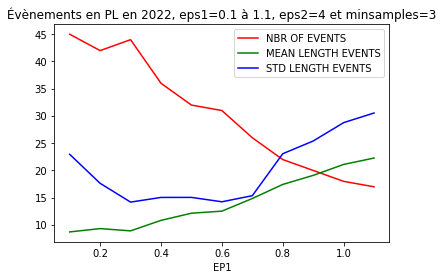

In [ ]:
x="PL"
find_eps1(x,2022,4,3,1,12)

    EPS2  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS
0      1          39           10.025000          15.756948
1      2          38           10.282051          14.878364
2      3          36           10.837838          15.047173
3      4          36           10.837838          15.047173
4      5          36           10.837838          15.047173
5      6          36           10.837838          14.915528
6      7          36           10.837838          14.915528
7      8          36           10.837838          14.915528
8      9          36           10.837838          14.915528
9     10          36           10.837838          14.915528
10    11          36           10.837838          14.915528
11    12          36           10.837838          14.915528


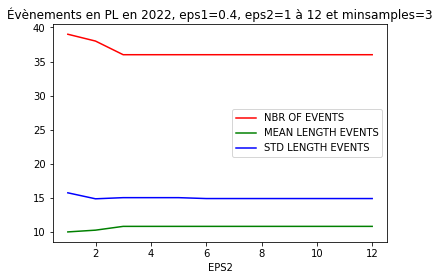

In [ ]:
x="PL"
find_eps2(x,2022,0.4,3,1,13)

   MINPT  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS
0      1          99            4.010000           7.043150
1      2          50            7.862745          10.785211
2      3          36           10.837838          15.047173
3      4          31           12.531250          17.953316
4      5          23           16.708333          26.635183
5      6          15           25.062500          40.900642
6      7          12           30.846154          51.629846


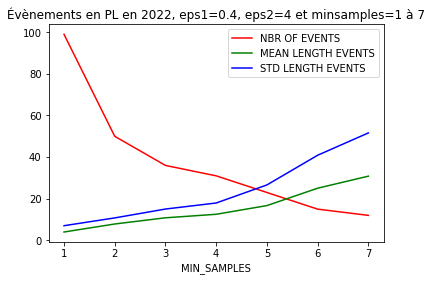

In [ ]:
x="PL"
find_minPts(x,2022,0.4,4,1,8)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             88        88         88       88
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              4         4          4        4
 8              7         7          7        7
 9             41        41         41       41
 10             6         6          6        6
 11             5         5          5        5
 12             4         4          4        4
 13             6         6          6        6
 14             6         6          6        6
 15             5         5          5        5
 16             3         3          3        3
 17             4         4          4  

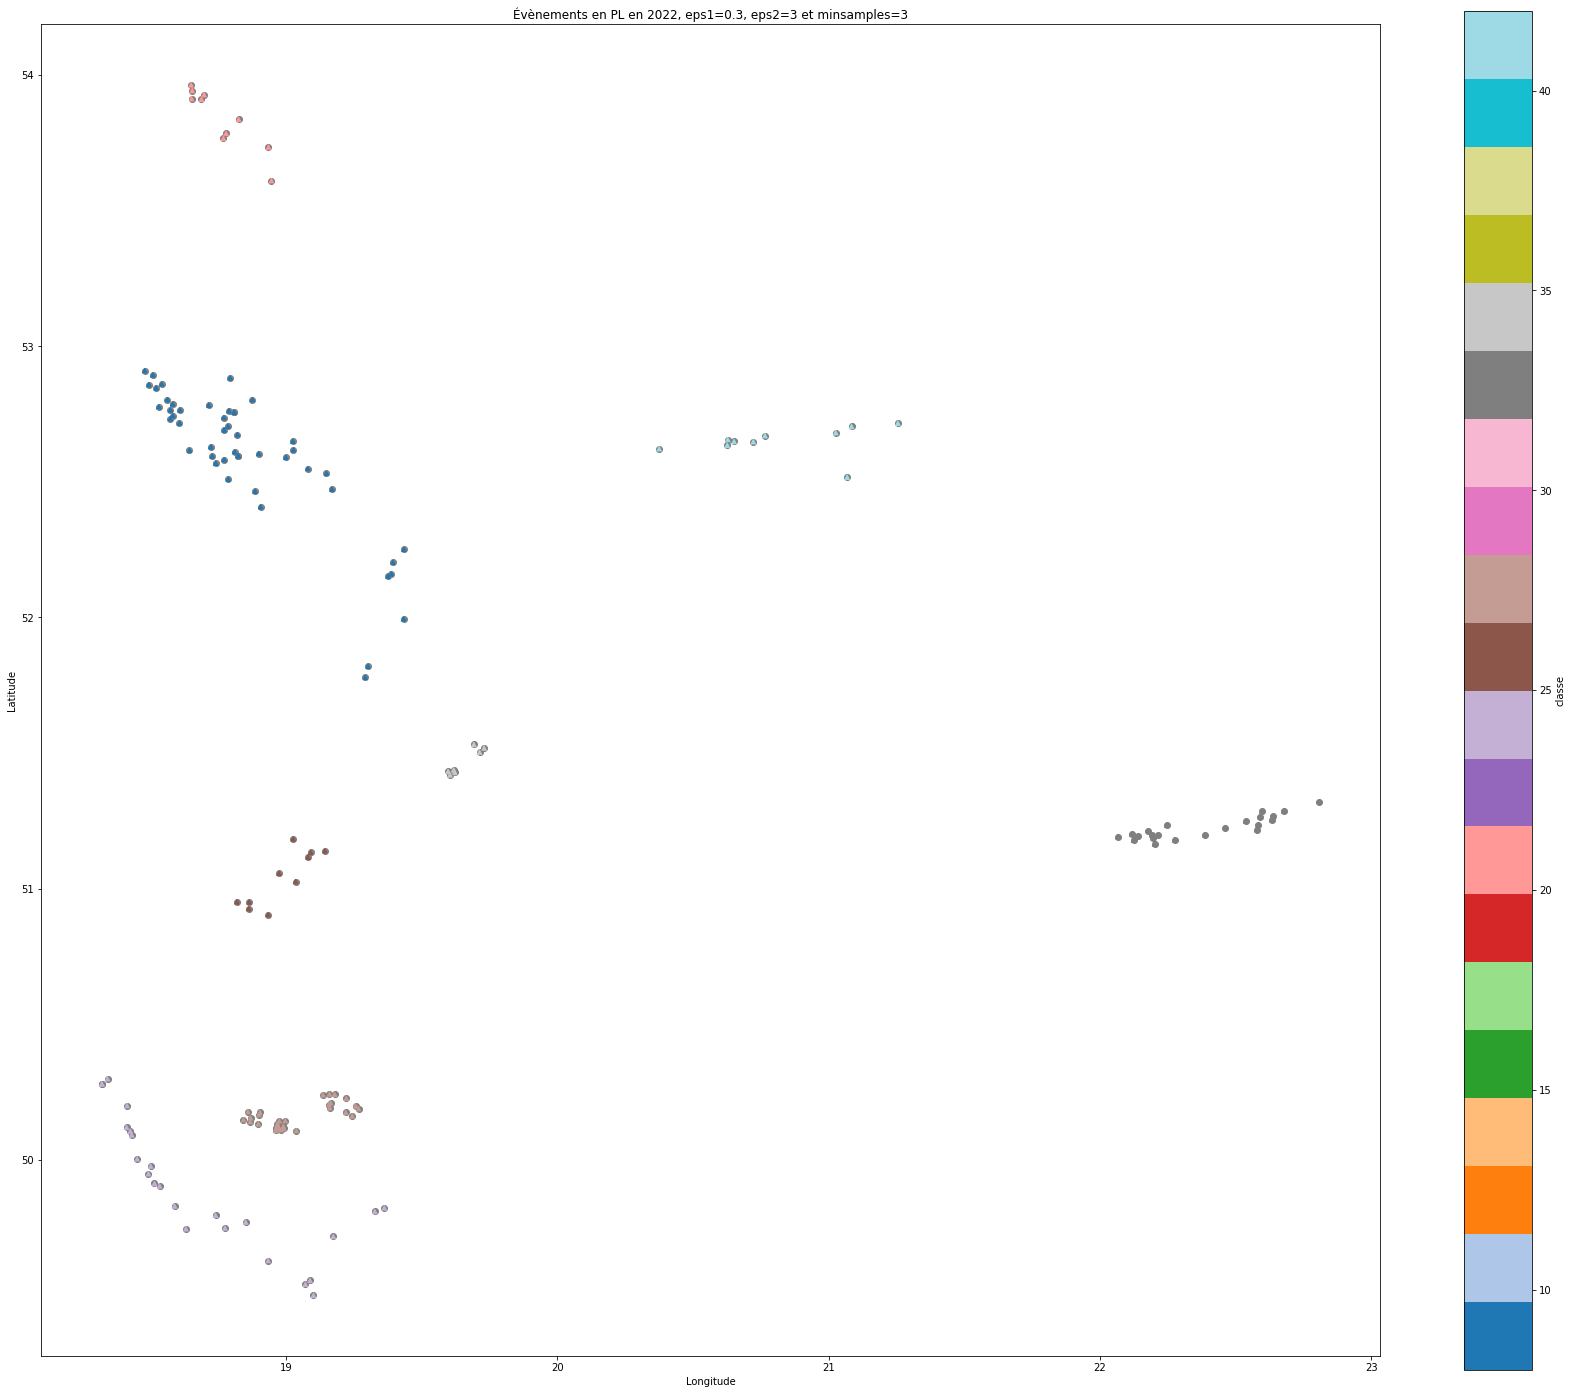

In [ ]:
x="PL"

clusterise_country_year(x, 2022, 0.3, 3, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             96        96         96       96
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              7         7          7        7
 8             41        41         41       41
 9              6         6          6        6
 10             5         5          5        5
 11             6         6          6        6
 12             6         6          6        6
 13             5         5          5        5
 14             3         3          3        3
 15             3         3          3        3
 16             4         4          4        4
 17             4         4          4  

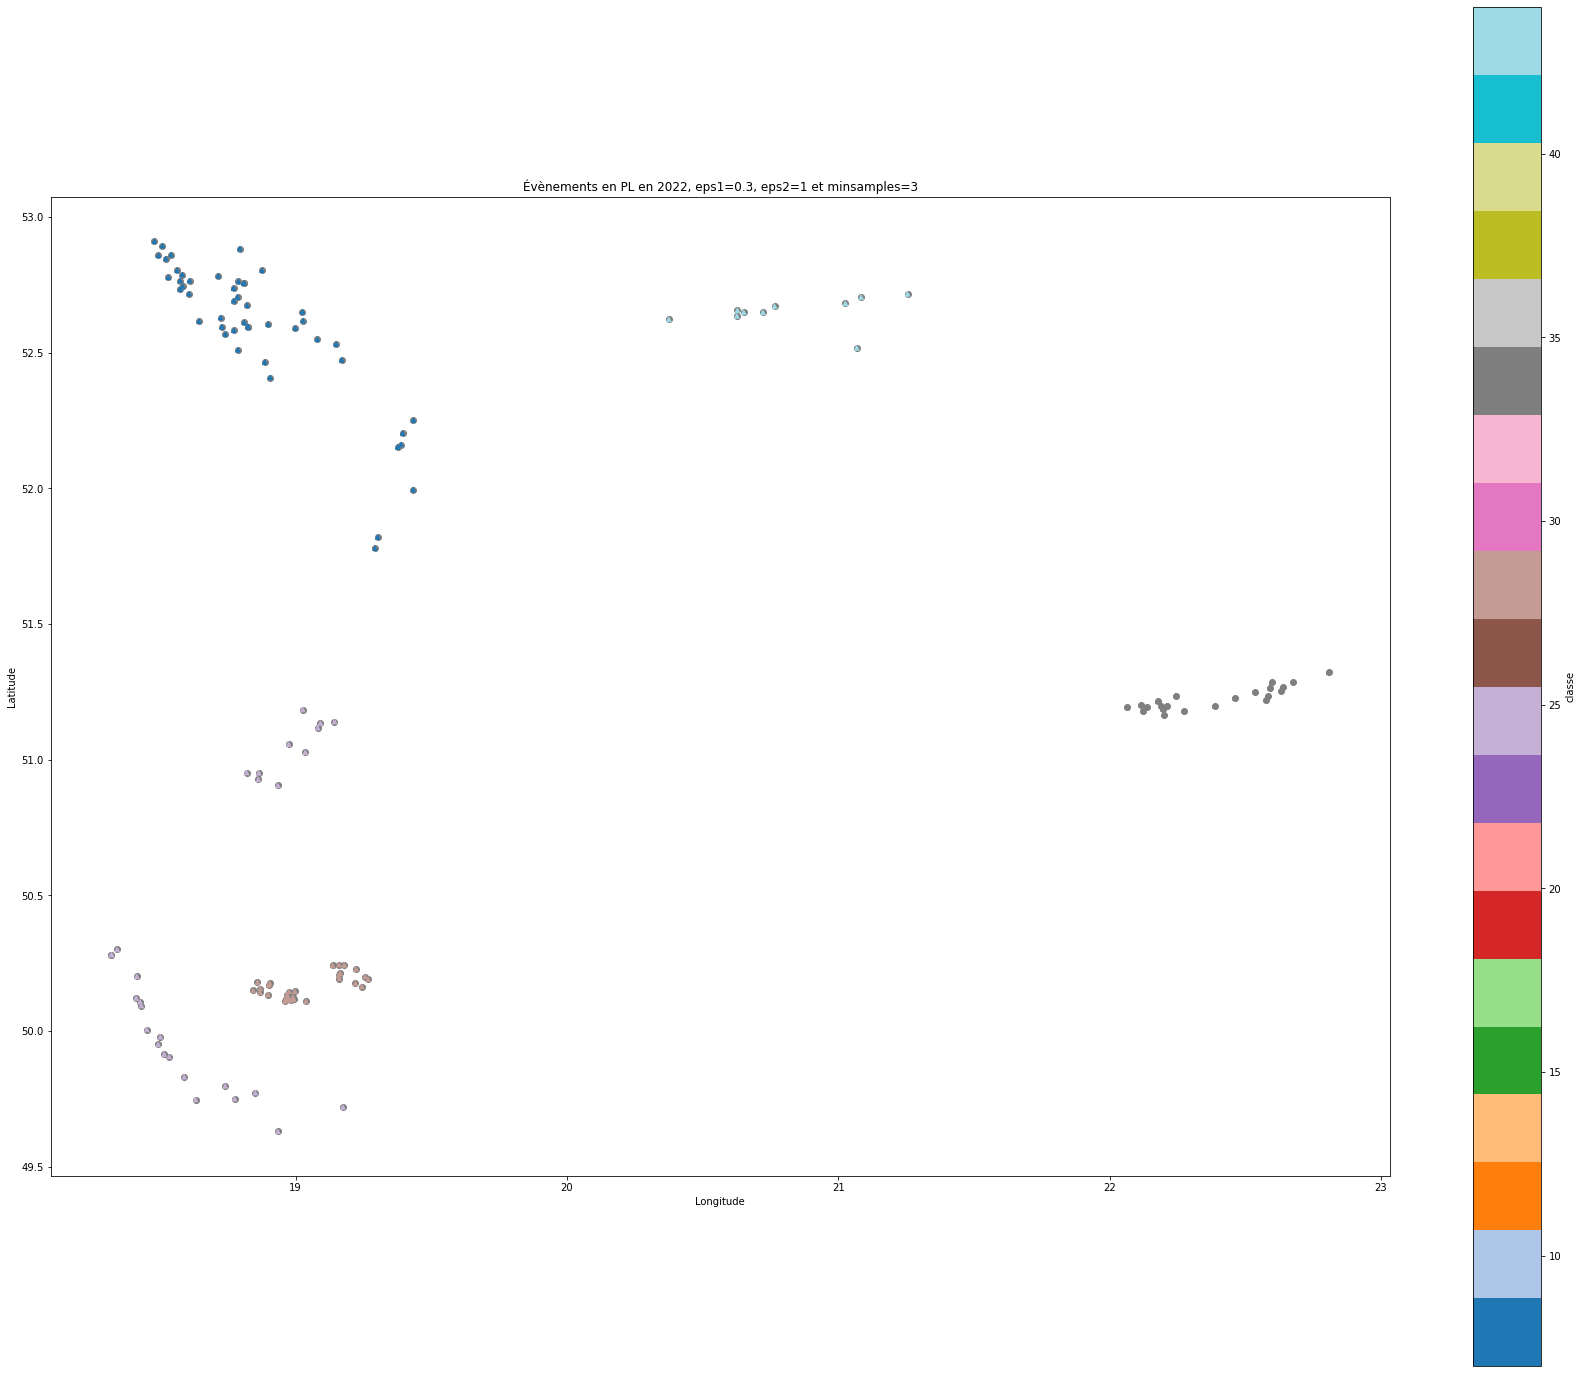

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             88        88         88       88
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              4         4          4        4
 8              7         7          7        7
 9             41        41         41       41
 10             6         6          6        6
 11             5         5          5        5
 12             4         4          4        4
 13             6         6          6        6
 14             6         6          6        6
 15             5         5          5        5
 16             3         3          3        3
 17             4         4          4  

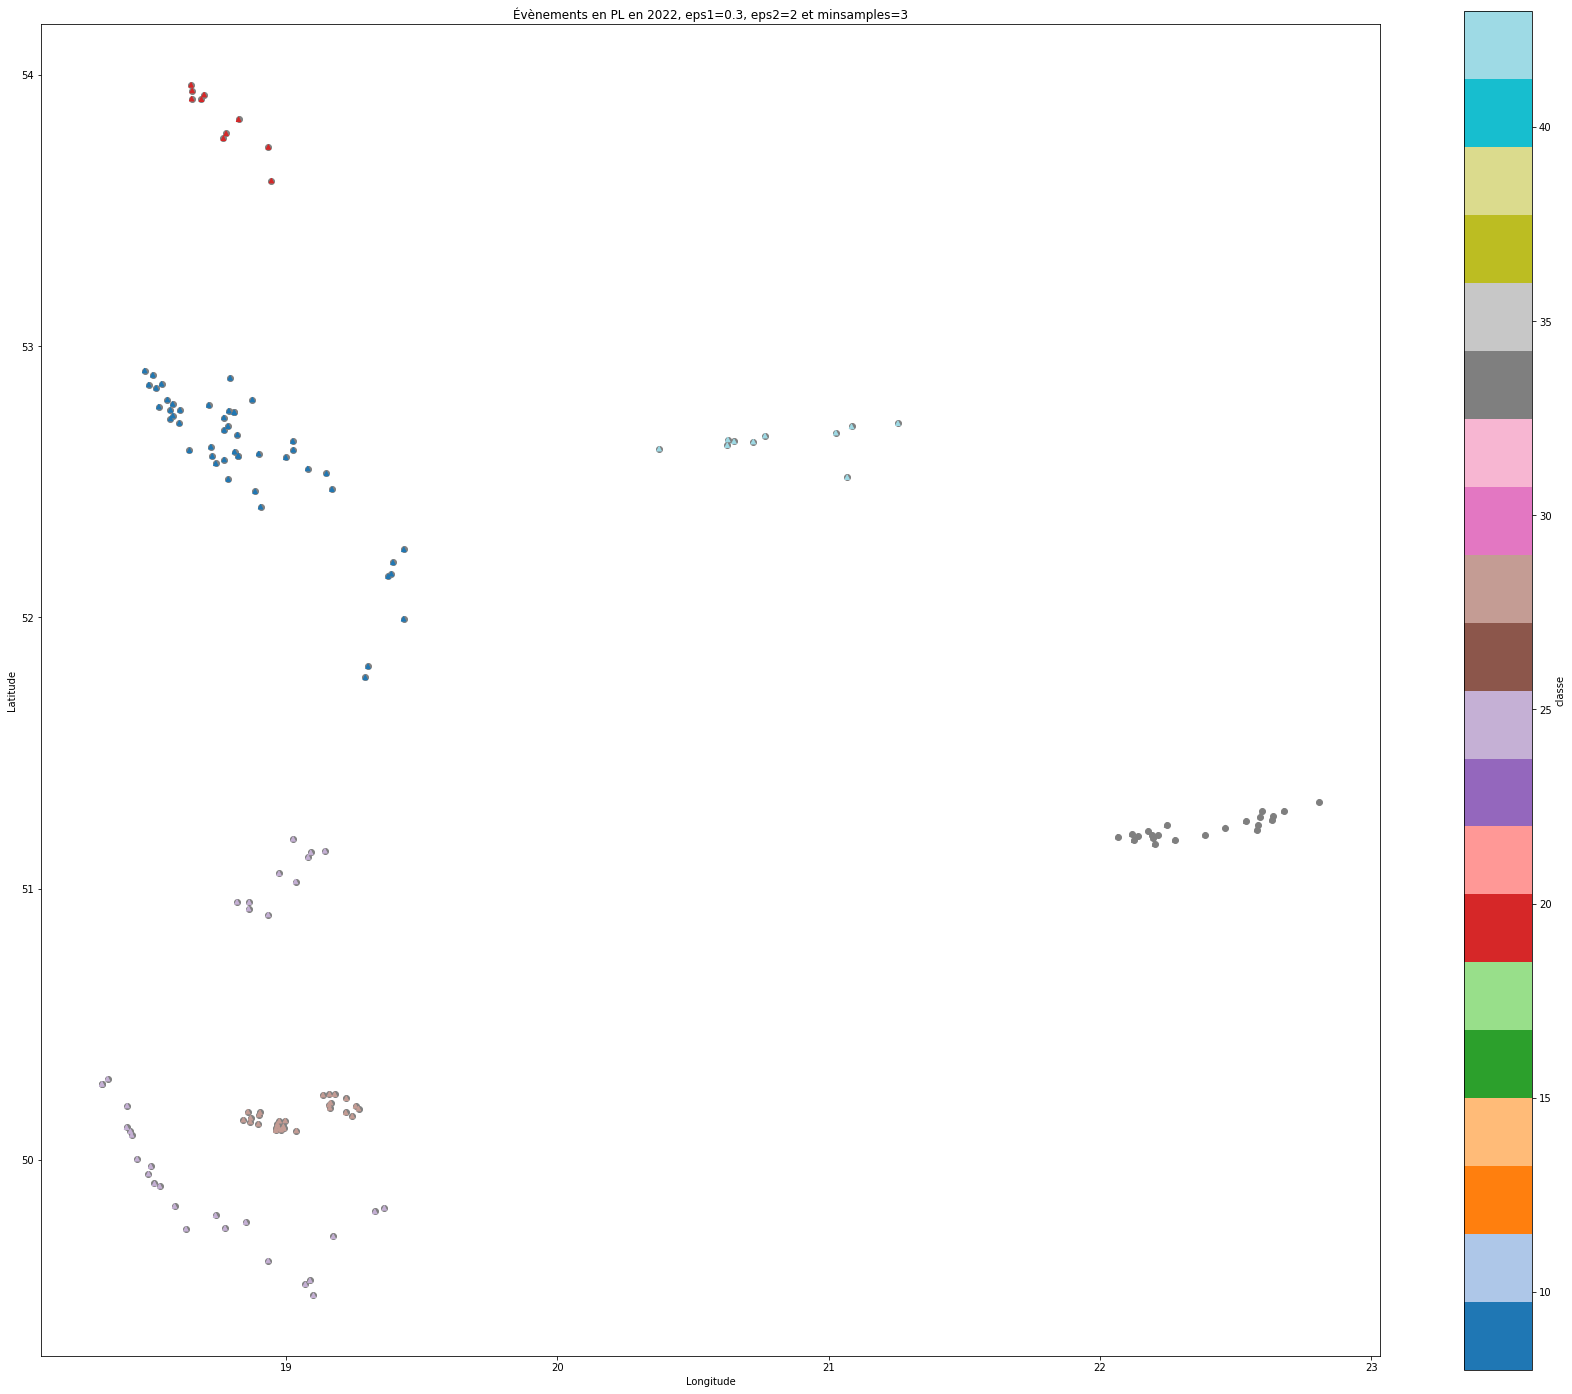

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             88        88         88       88
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              4         4          4        4
 8              7         7          7        7
 9             41        41         41       41
 10             6         6          6        6
 11             5         5          5        5
 12             4         4          4        4
 13             6         6          6        6
 14             6         6          6        6
 15             5         5          5        5
 16             3         3          3        3
 17             4         4          4  

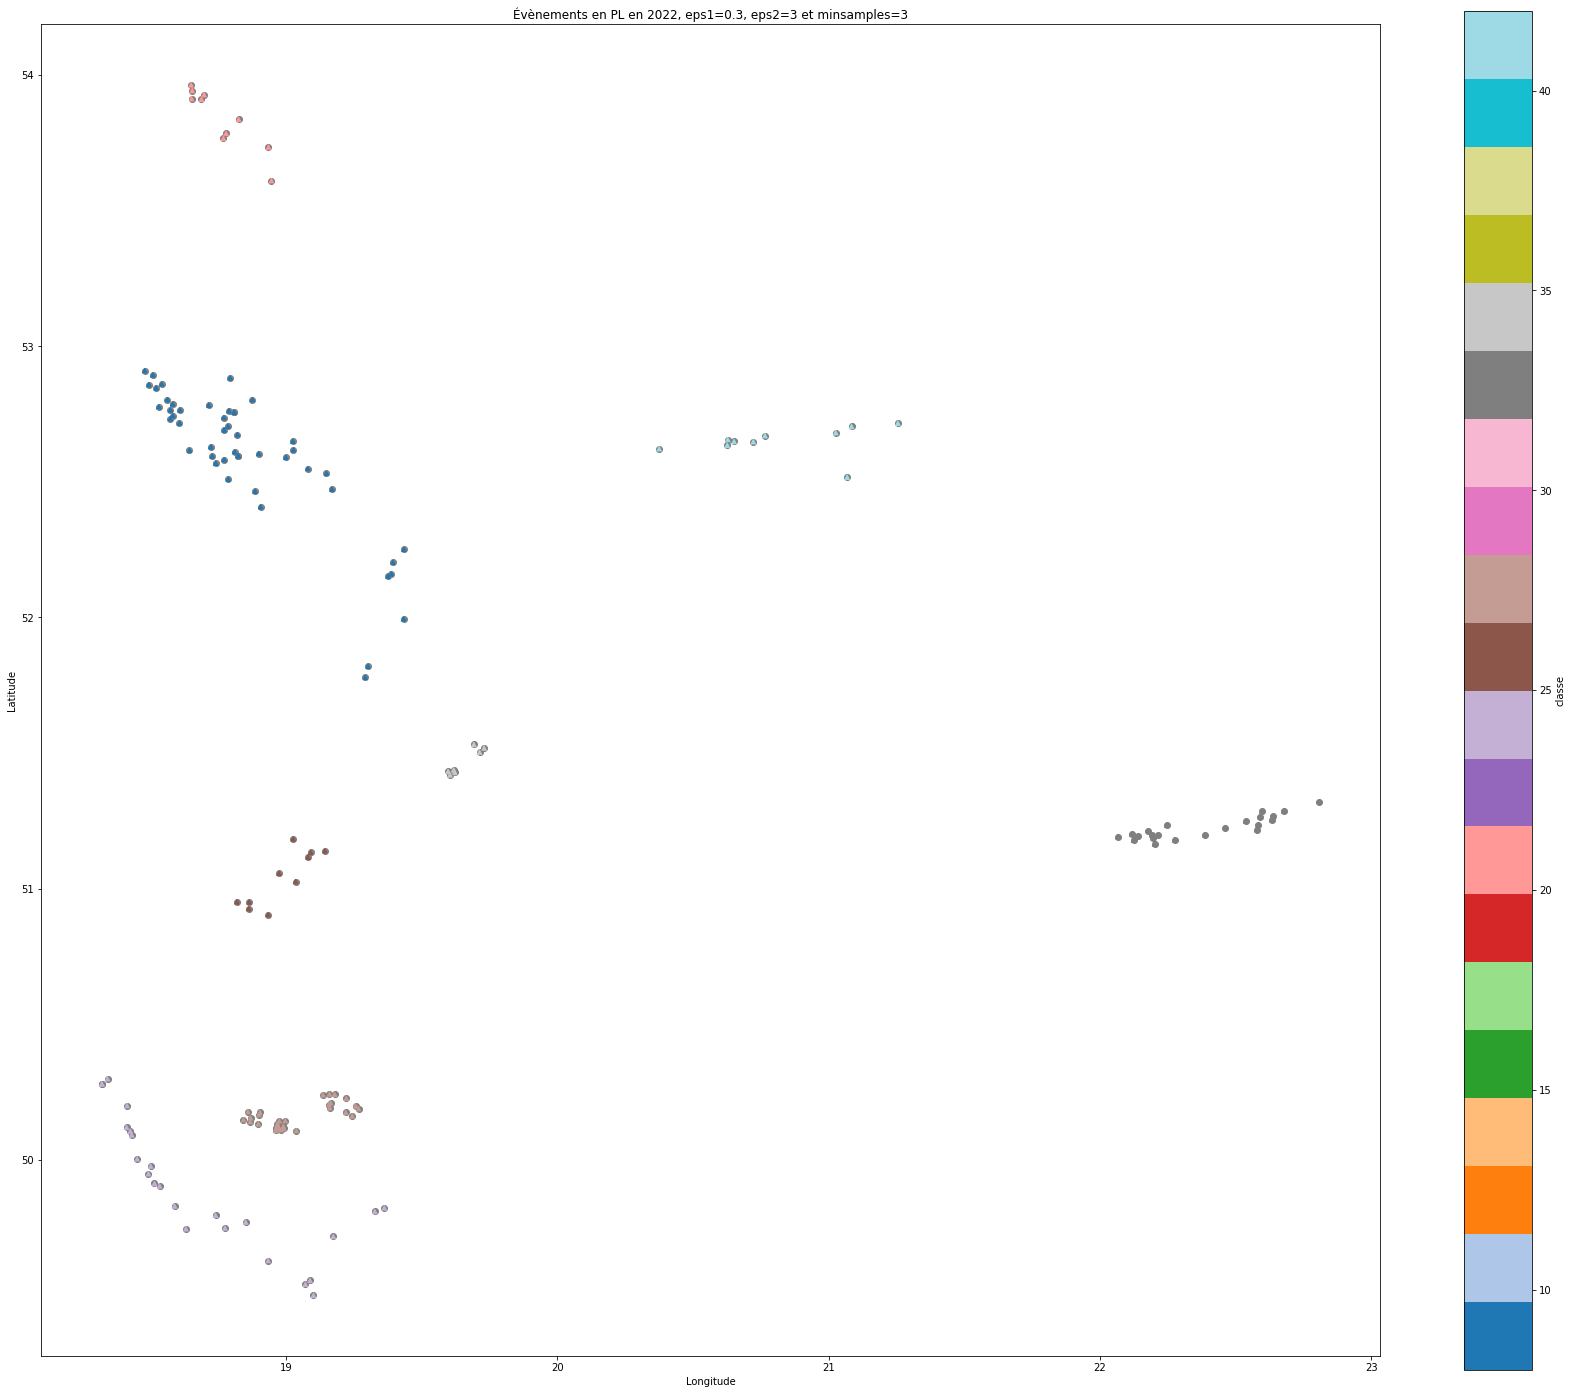

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             88        88         88       88
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              4         4          4        4
 8              7         7          7        7
 9             41        41         41       41
 10             6         6          6        6
 11             5         5          5        5
 12             4         4          4        4
 13             6         6          6        6
 14             6         6          6        6
 15             5         5          5        5
 16             3         3          3        3
 17             4         4          4  

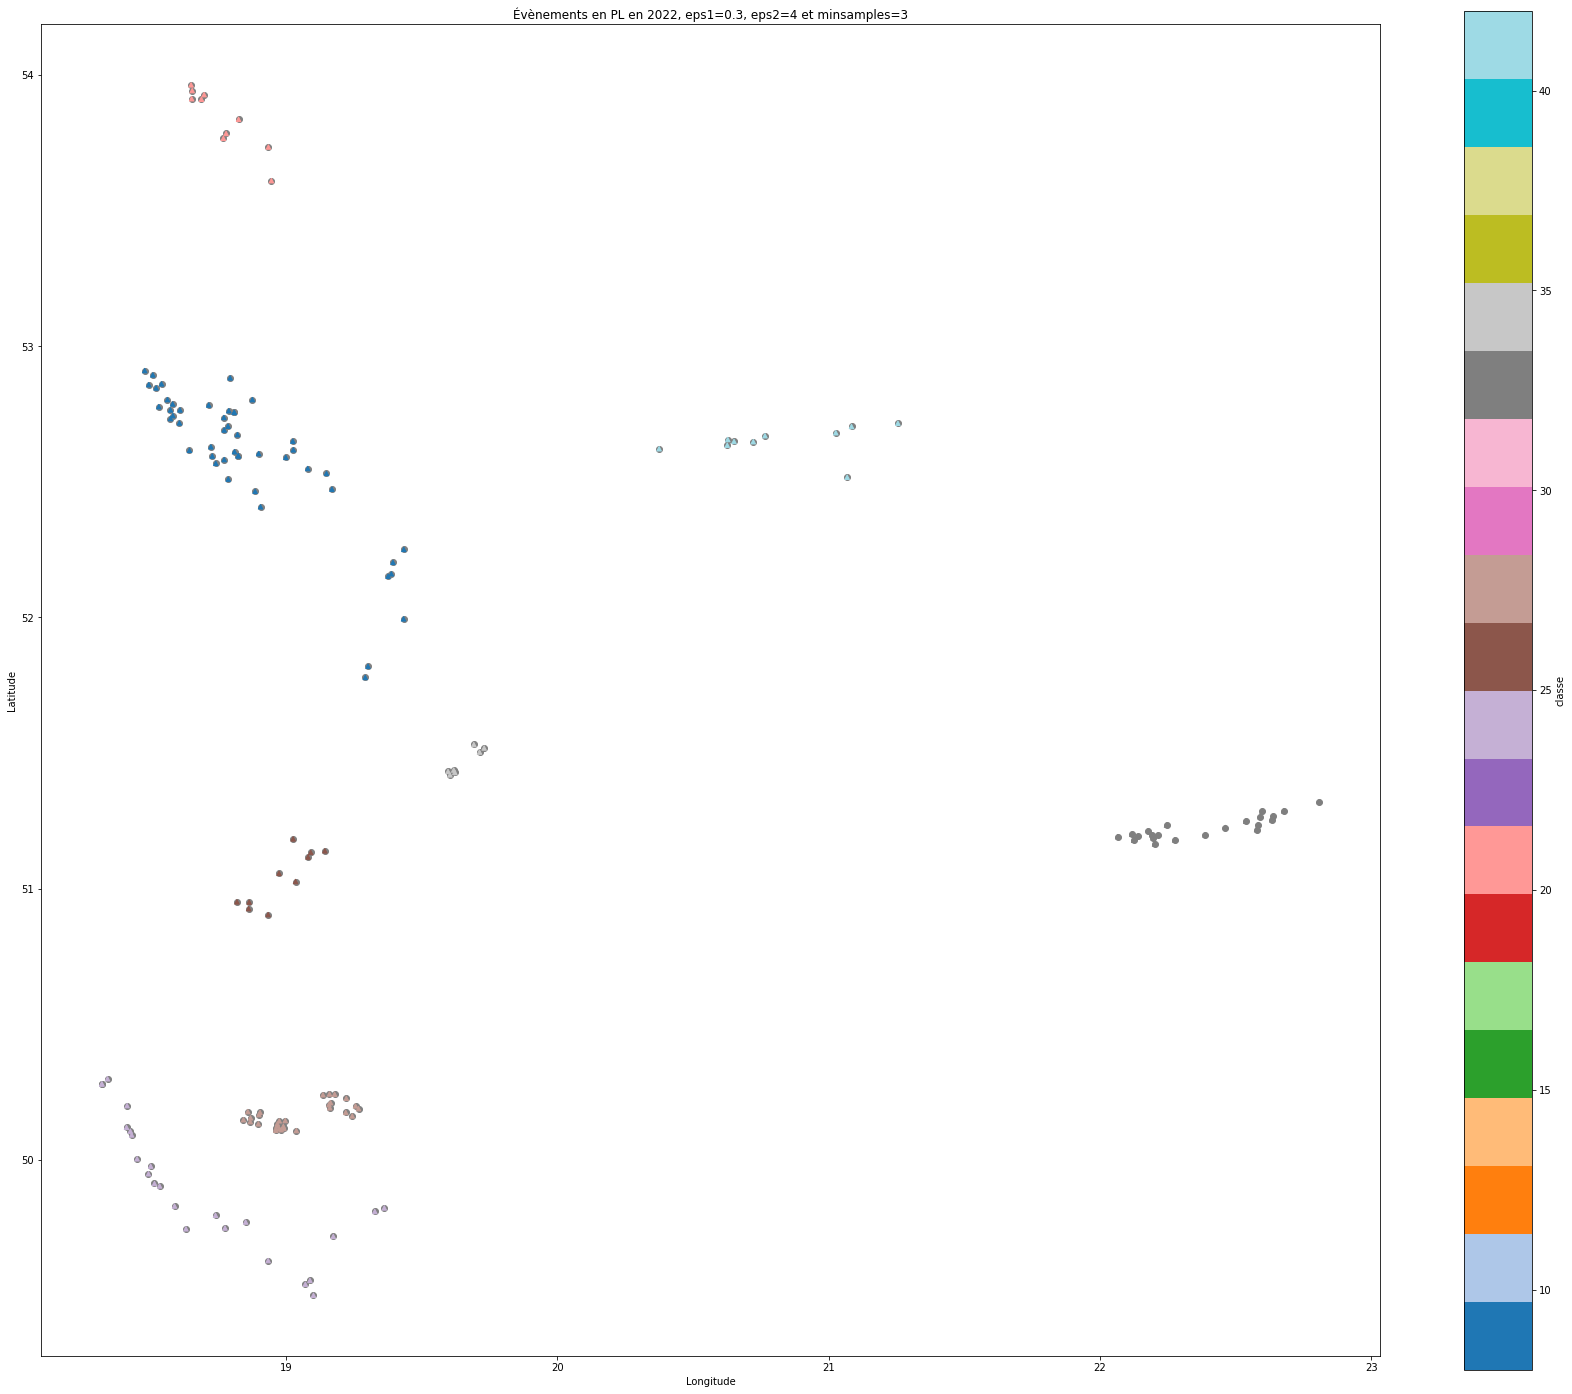

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             88        88         88       88
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              4         4          4        4
 8              7         7          7        7
 9             41        41         41       41
 10             6         6          6        6
 11             5         5          5        5
 12             4         4          4        4
 13             6         6          6        6
 14             6         6          6        6
 15             5         5          5        5
 16             3         3          3        3
 17             4         4          4  

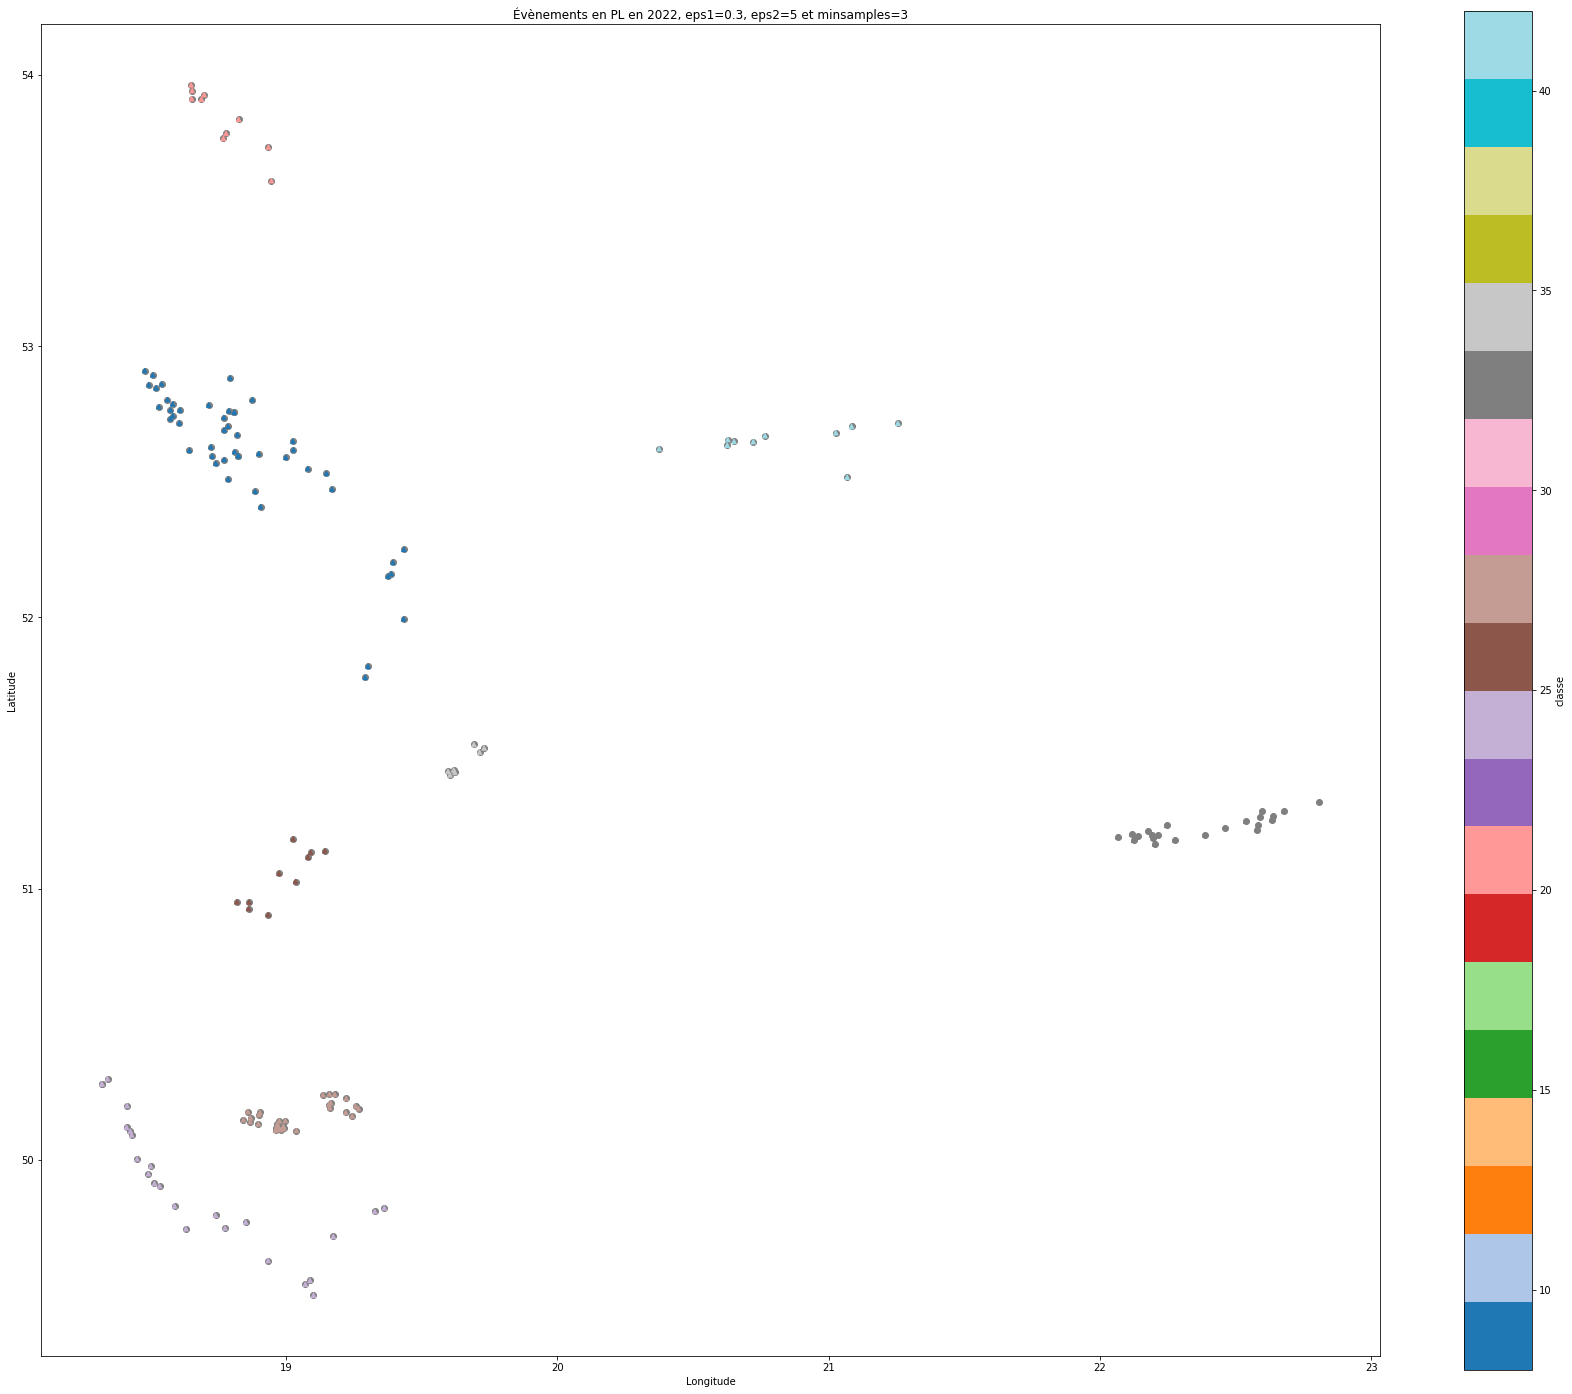

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             88        88         88       88
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              4         4          4        4
 8              7         7          7        7
 9             41        41         41       41
 10             6         6          6        6
 11             5         5          5        5
 12             4         4          4        4
 13             6         6          6        6
 14             6         6          6        6
 15             5         5          5        5
 16             3         3          3        3
 17             4         4          4  

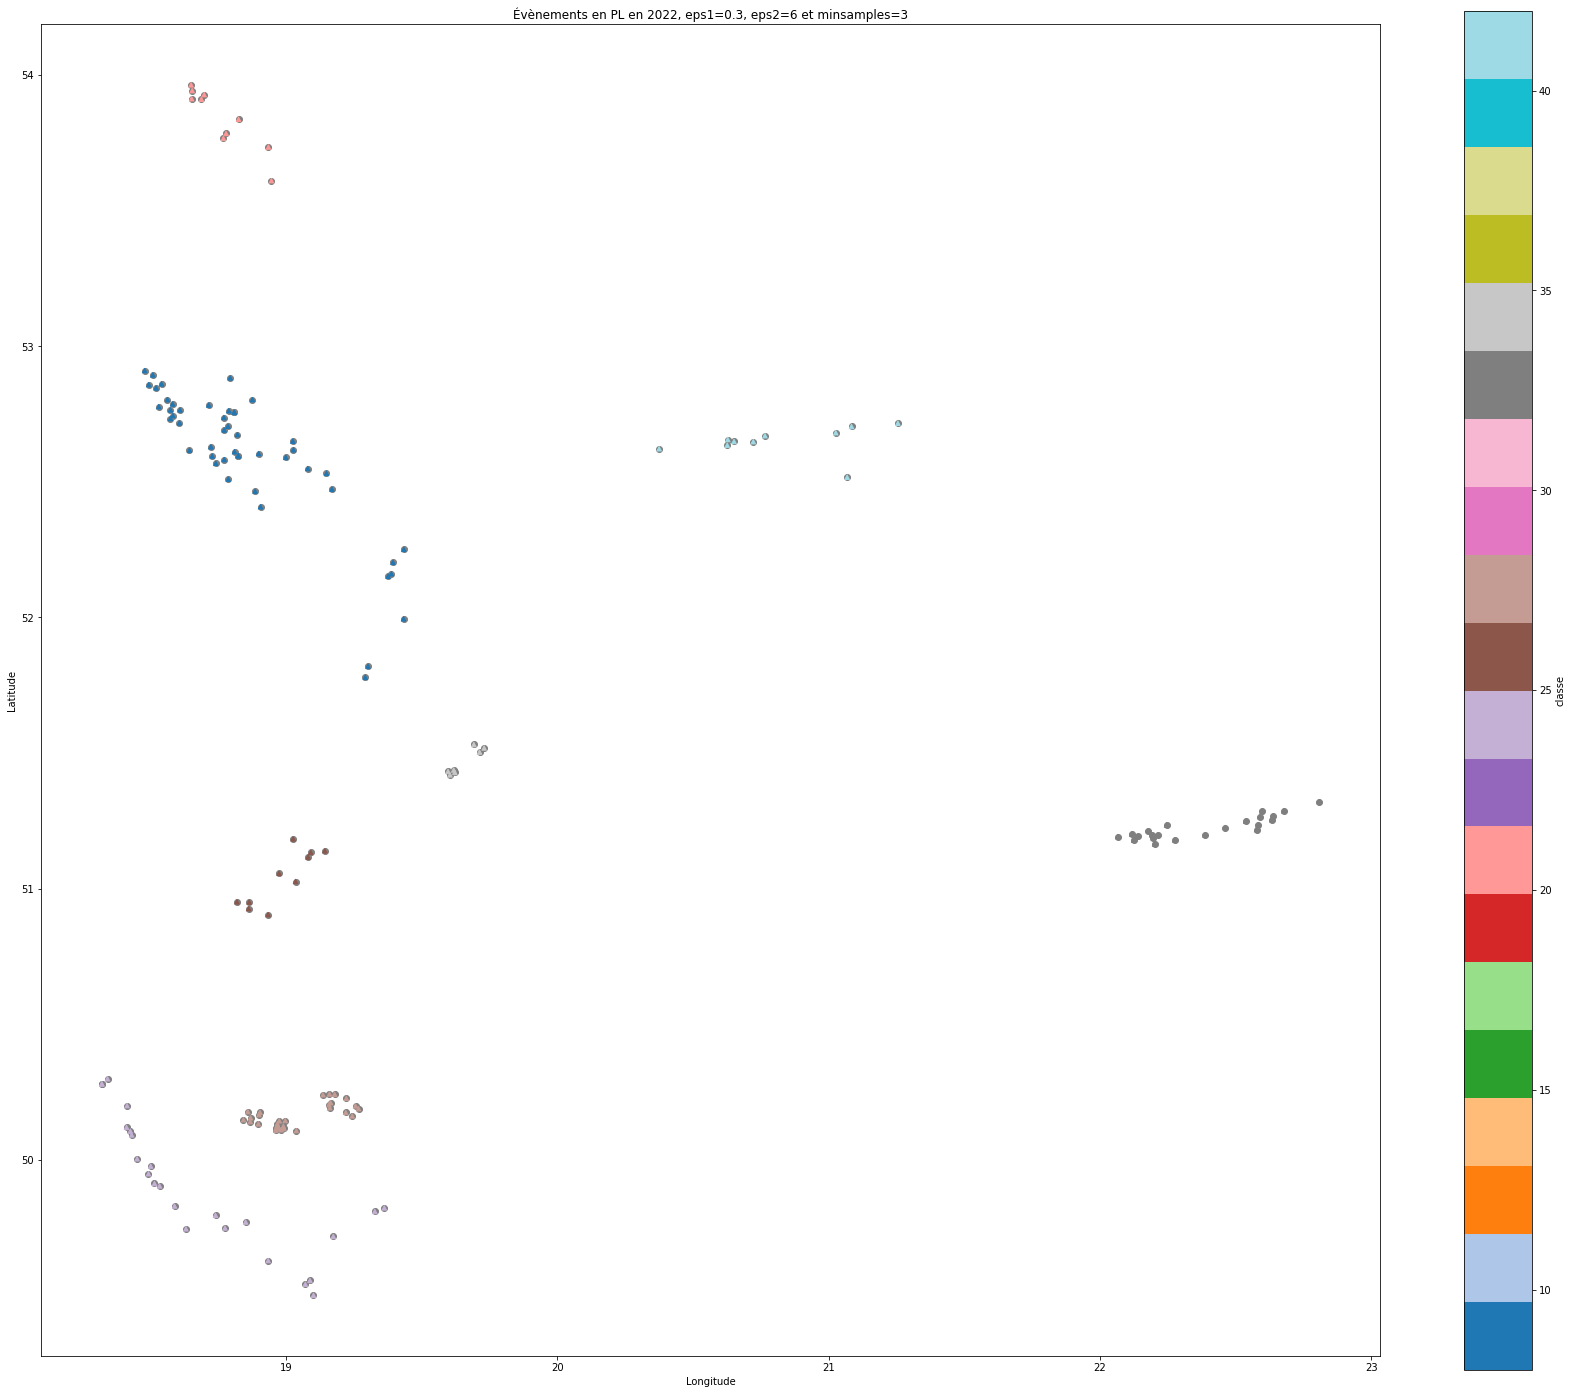

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             88        88         88       88
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              4         4          4        4
 8              7         7          7        7
 9             41        41         41       41
 10             6         6          6        6
 11             5         5          5        5
 12             4         4          4        4
 13             6         6          6        6
 14             6         6          6        6
 15             5         5          5        5
 16             3         3          3        3
 17             4         4          4  

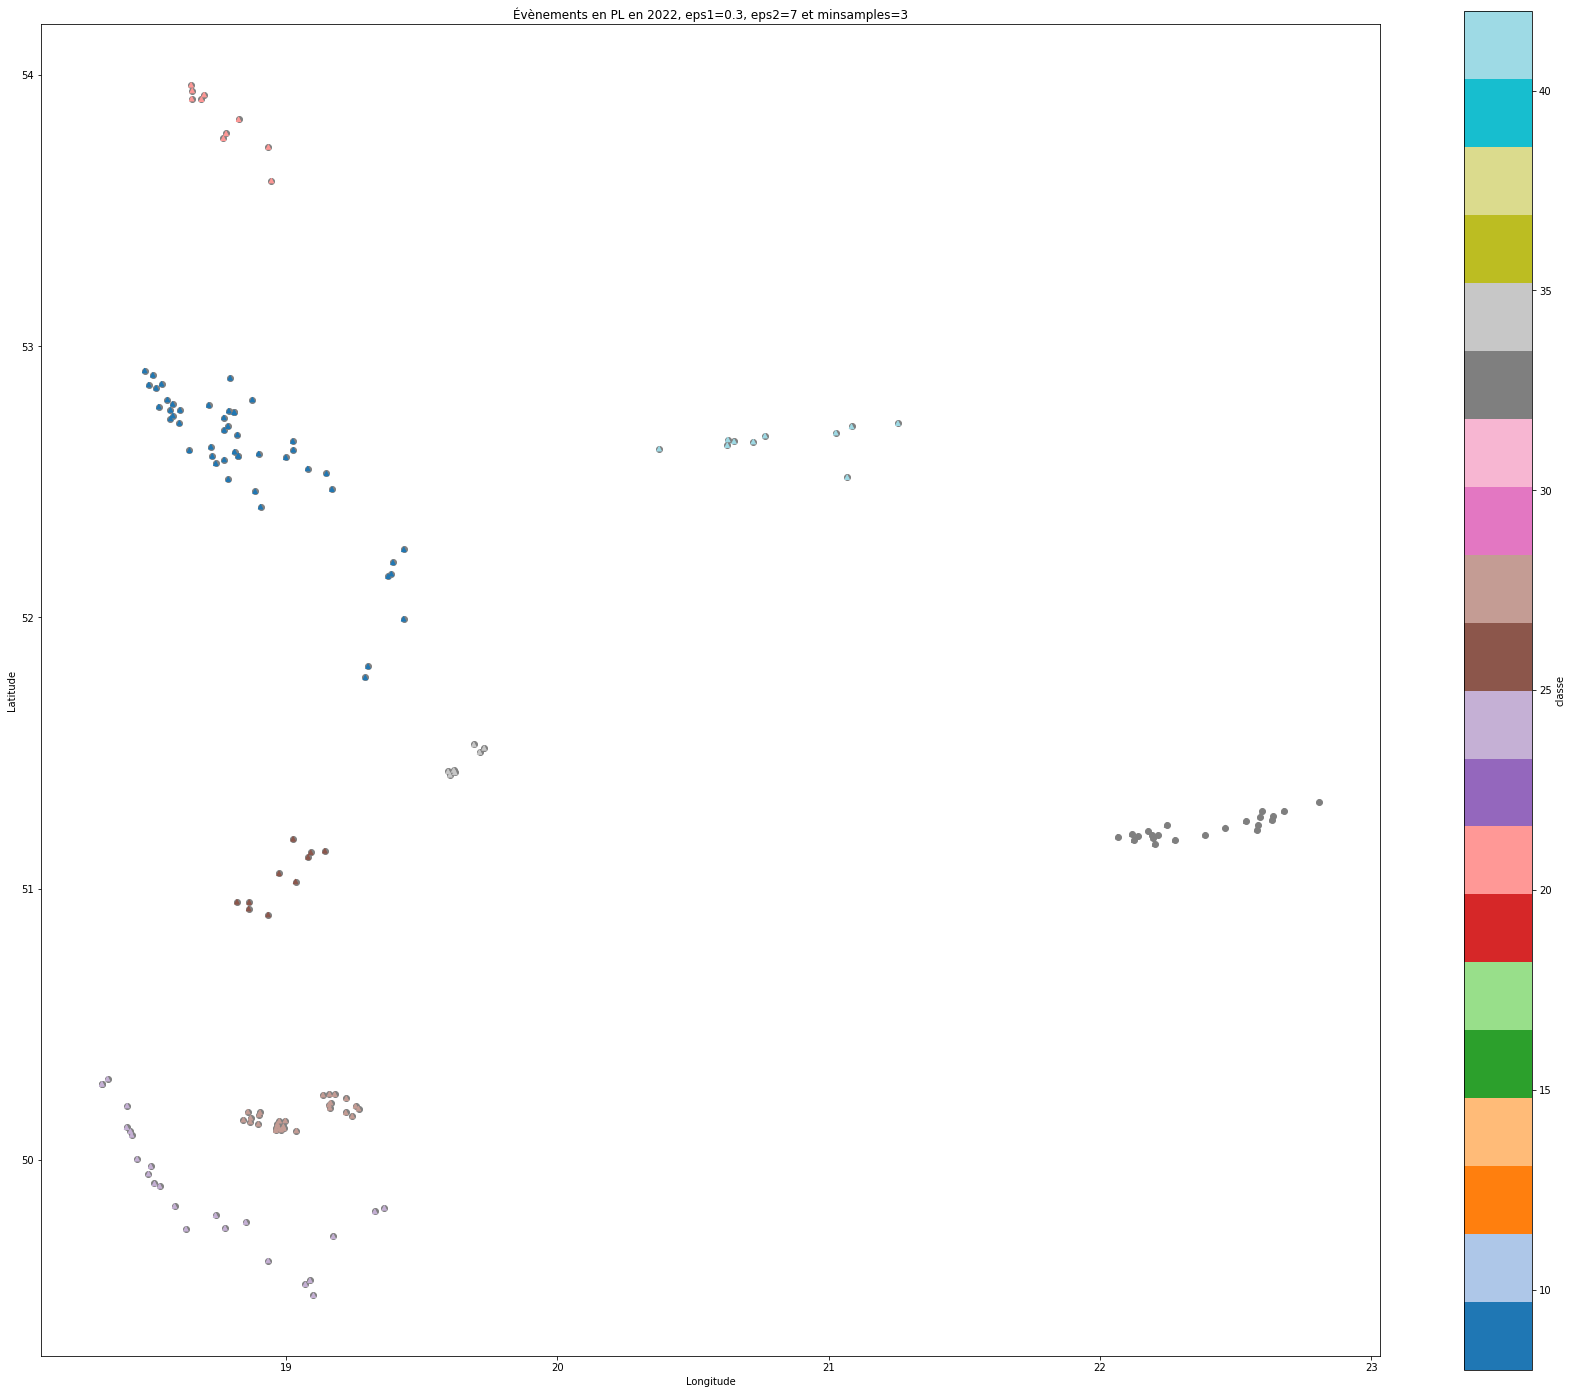

In [ ]:
x="PL"

for i in range(1 ,8 ):
    
    clusterise_country_year(x, 2022, 0.3, i, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            159       159        159      159
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              6         6          6        6
 5              4         4          4        4
 6              6         6          6        6
 7             19        19         19       19
 8              4         4          4        4
 9             13        13         13       13
 10             4         4          4        4
 11             4         4          4        4
 12             5         5          5        5
 13             4         4          4        4
 14             4         4          4        4
 15             4         4          4        4
 16             3         3          3        3
 17             3         3          3  

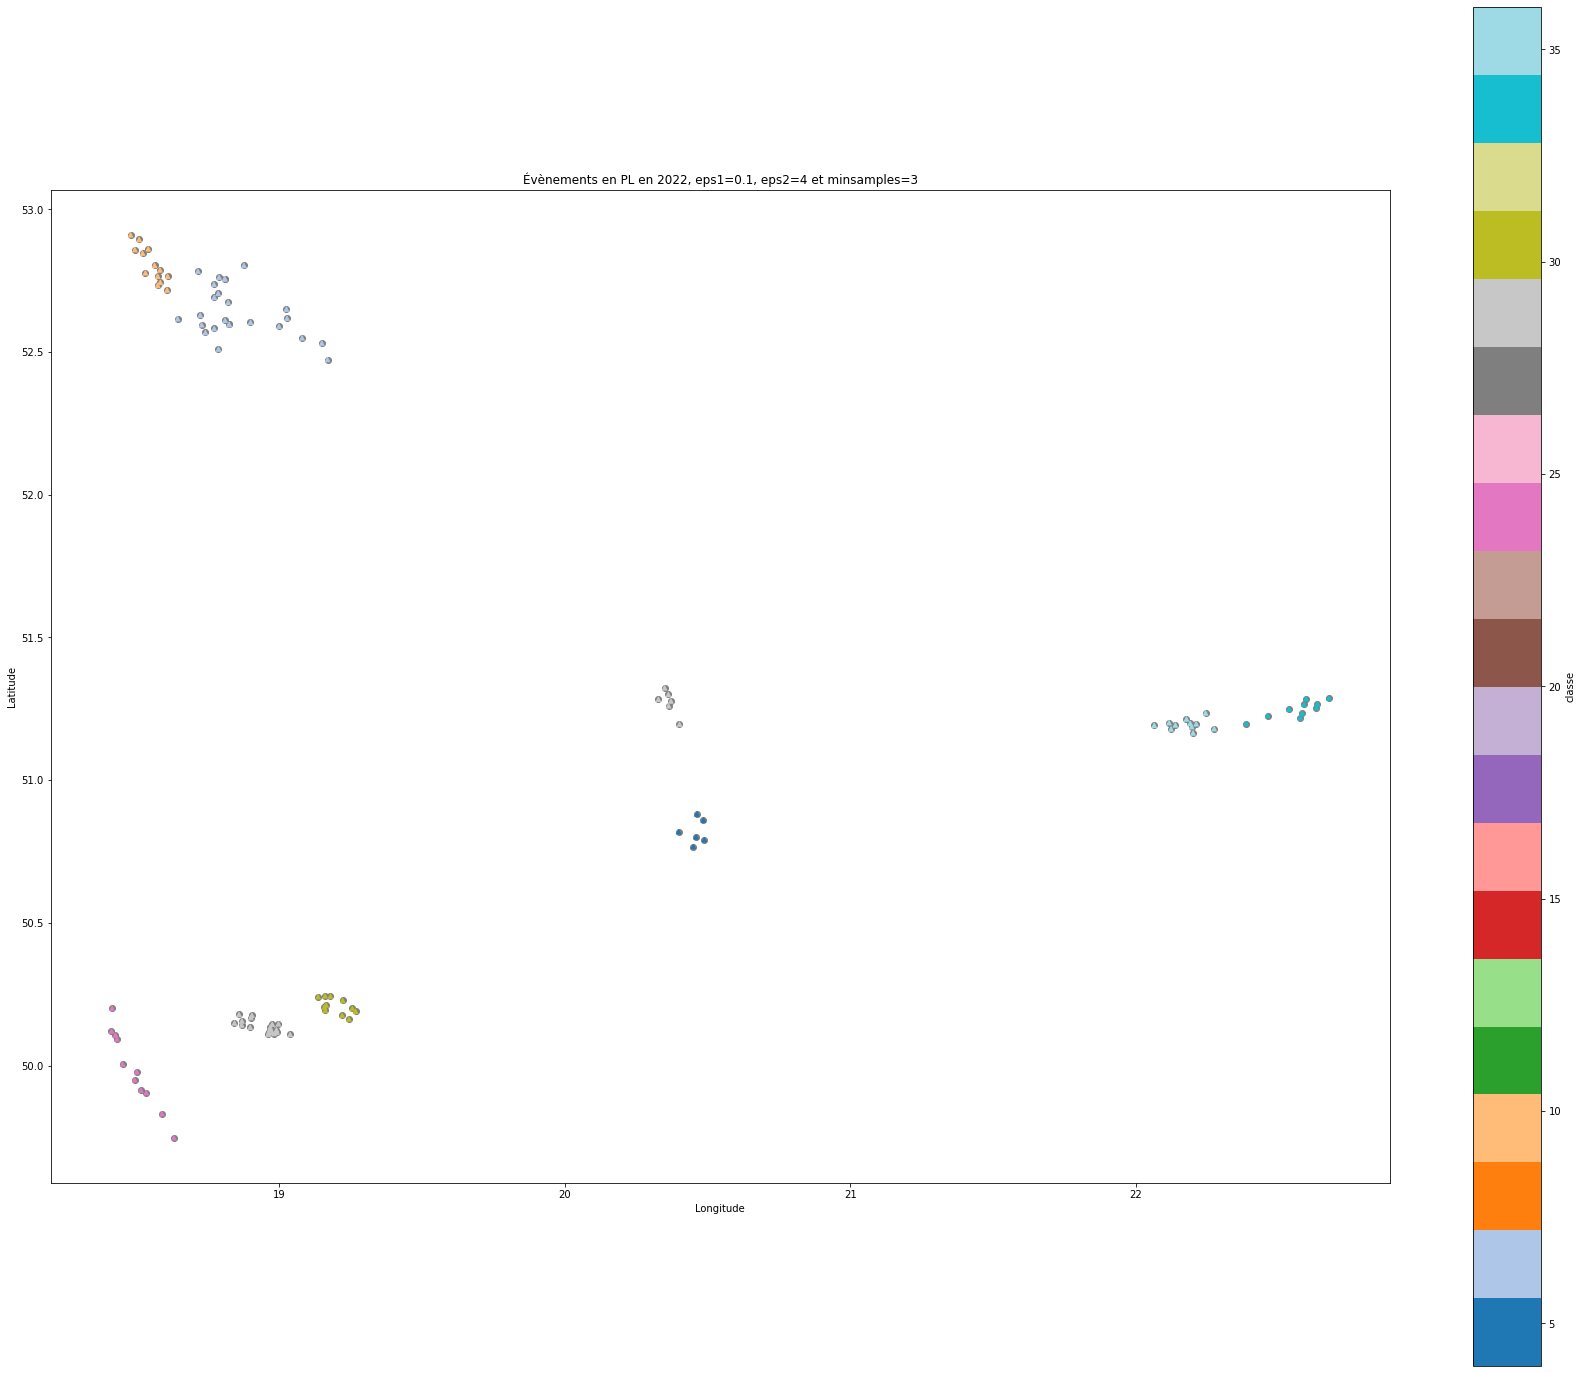

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            111       111        111      111
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              5         5          5        5
 8             41        41         41       41
 9              6         6          6        6
 10             5         5          5        5
 11             4         4          4        4
 12             5         5          5        5
 13             5         5          5        5
 14             4         4          4        4
 15             3         3          3        3
 16             4         4          4        4
 17             4         4          4  

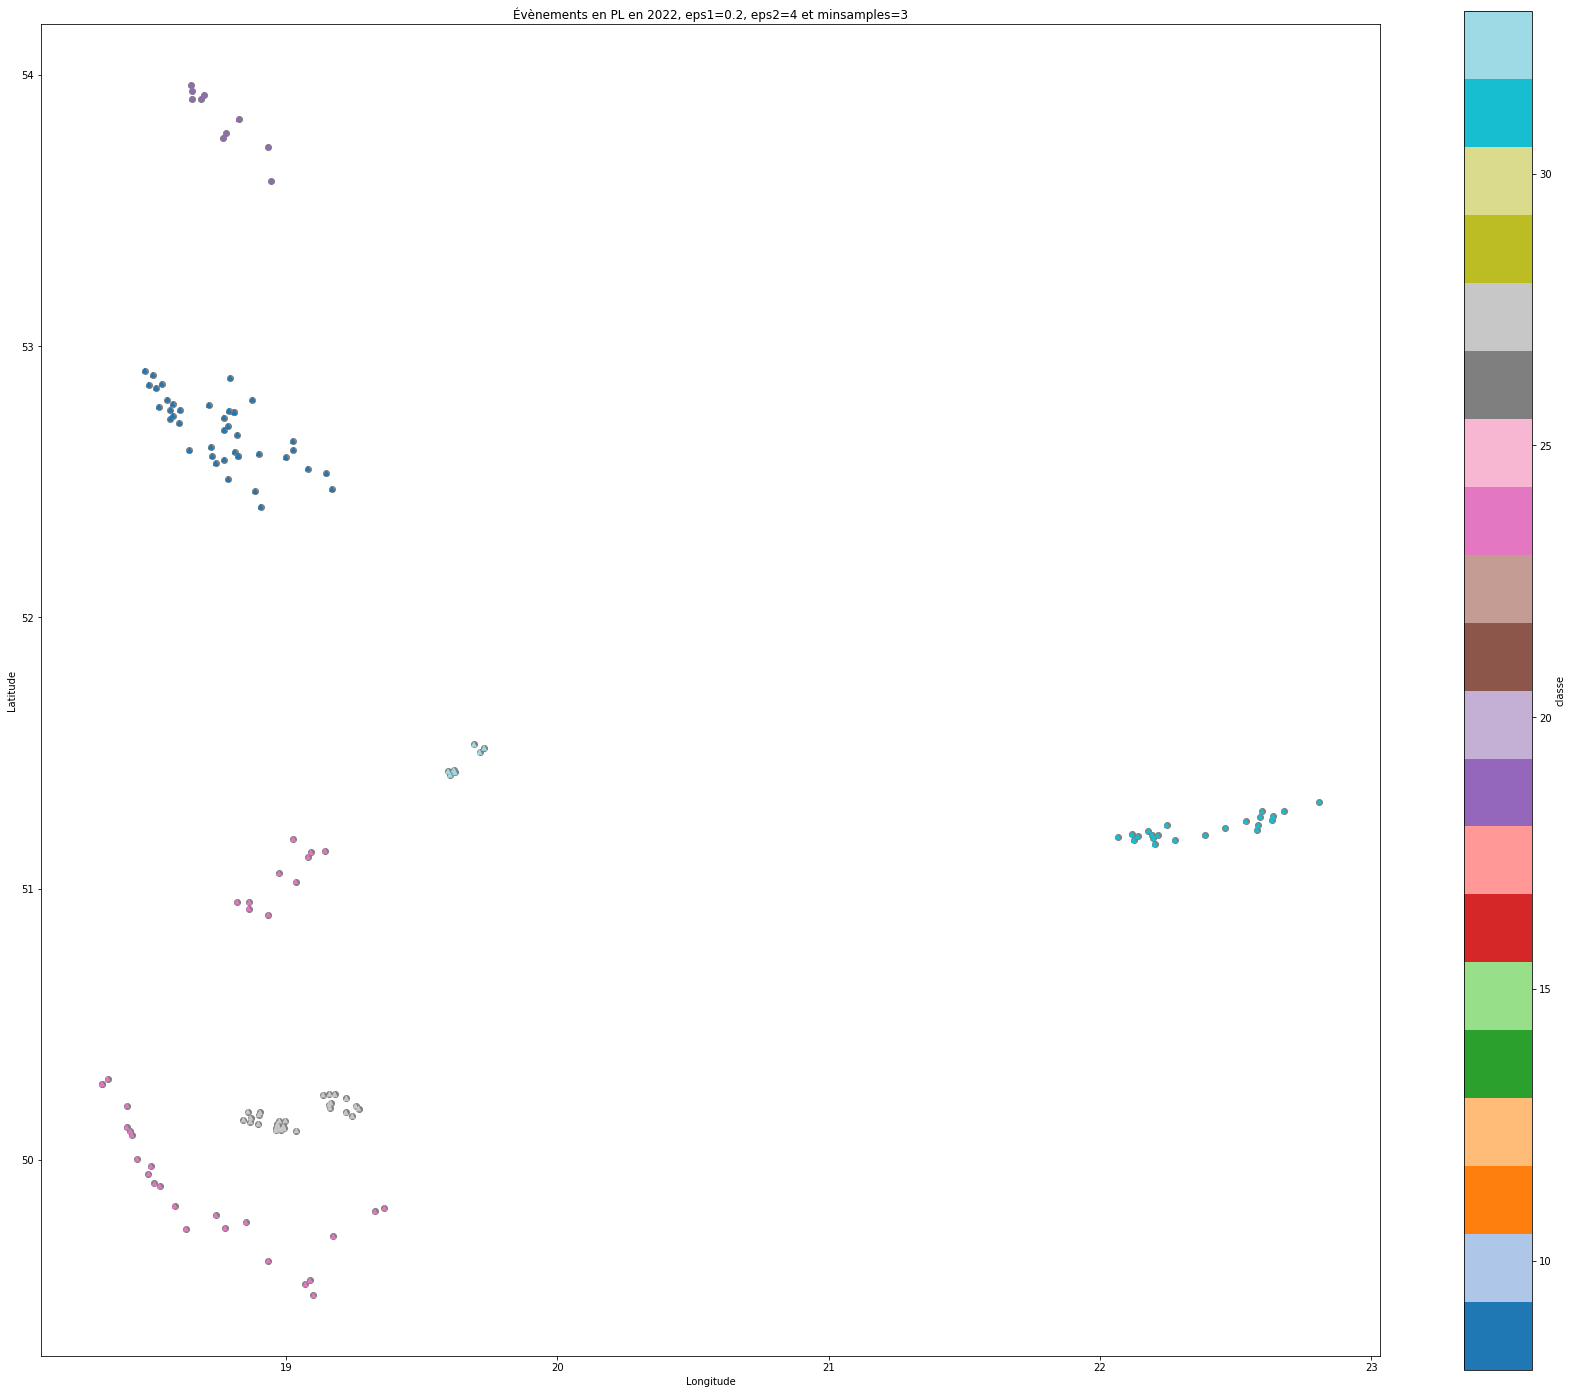

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             88        88         88       88
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              4         4          4        4
 8              7         7          7        7
 9             41        41         41       41
 10             6         6          6        6
 11             5         5          5        5
 12             4         4          4        4
 13             6         6          6        6
 14             6         6          6        6
 15             5         5          5        5
 16             3         3          3        3
 17             4         4          4  

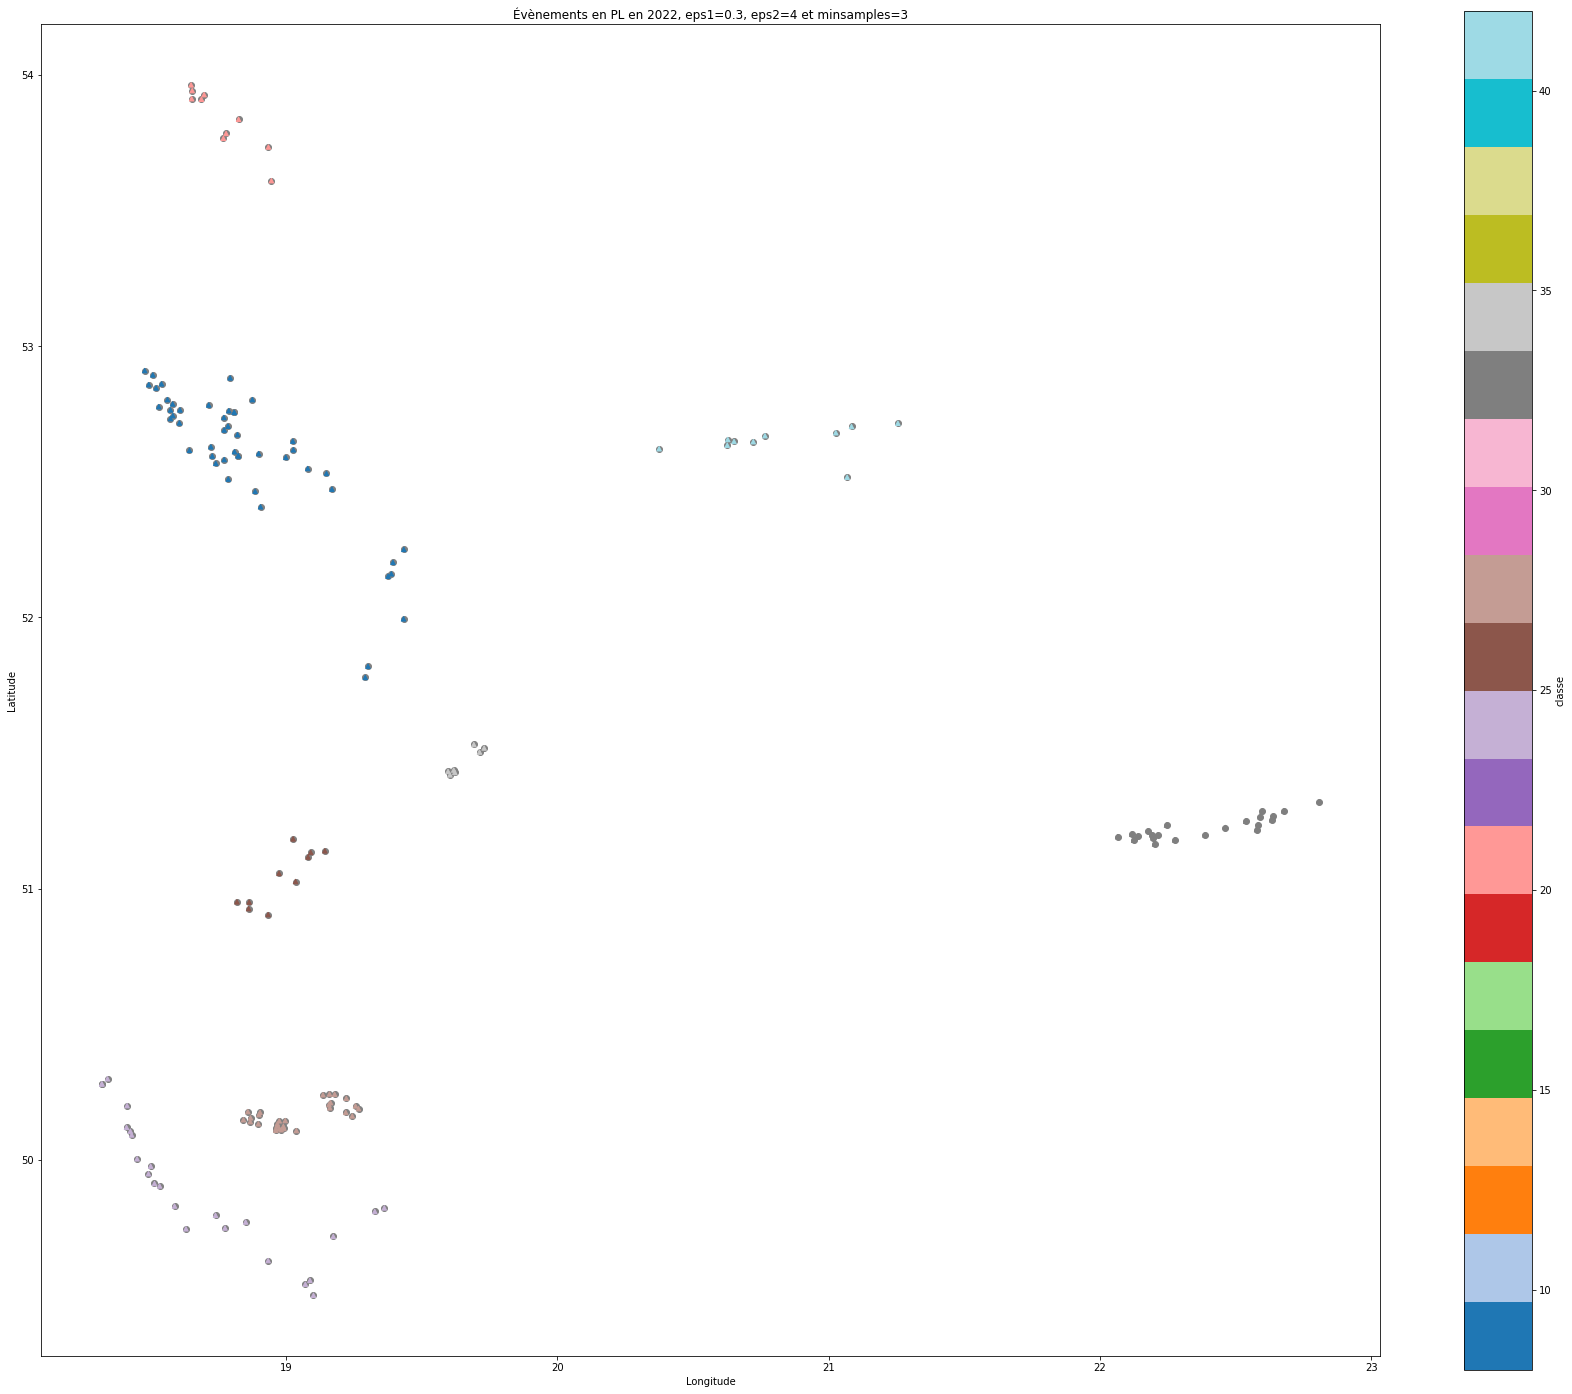

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             78        78         78       78
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              7         7          7        7
 4              4         4          4        4
 5              6         6          6        6
 6              4         4          4        4
 7             54        54         54       54
 8              5         5          5        5
 9              4         4          4        4
 10             8         8          8        8
 11            13        13         13       13
 12             5         5          5        5
 13             3         3          3        3
 14             4         4          4        4
 15             4         4          4        4
 16            14        14         14       14
 17             5         5          5  

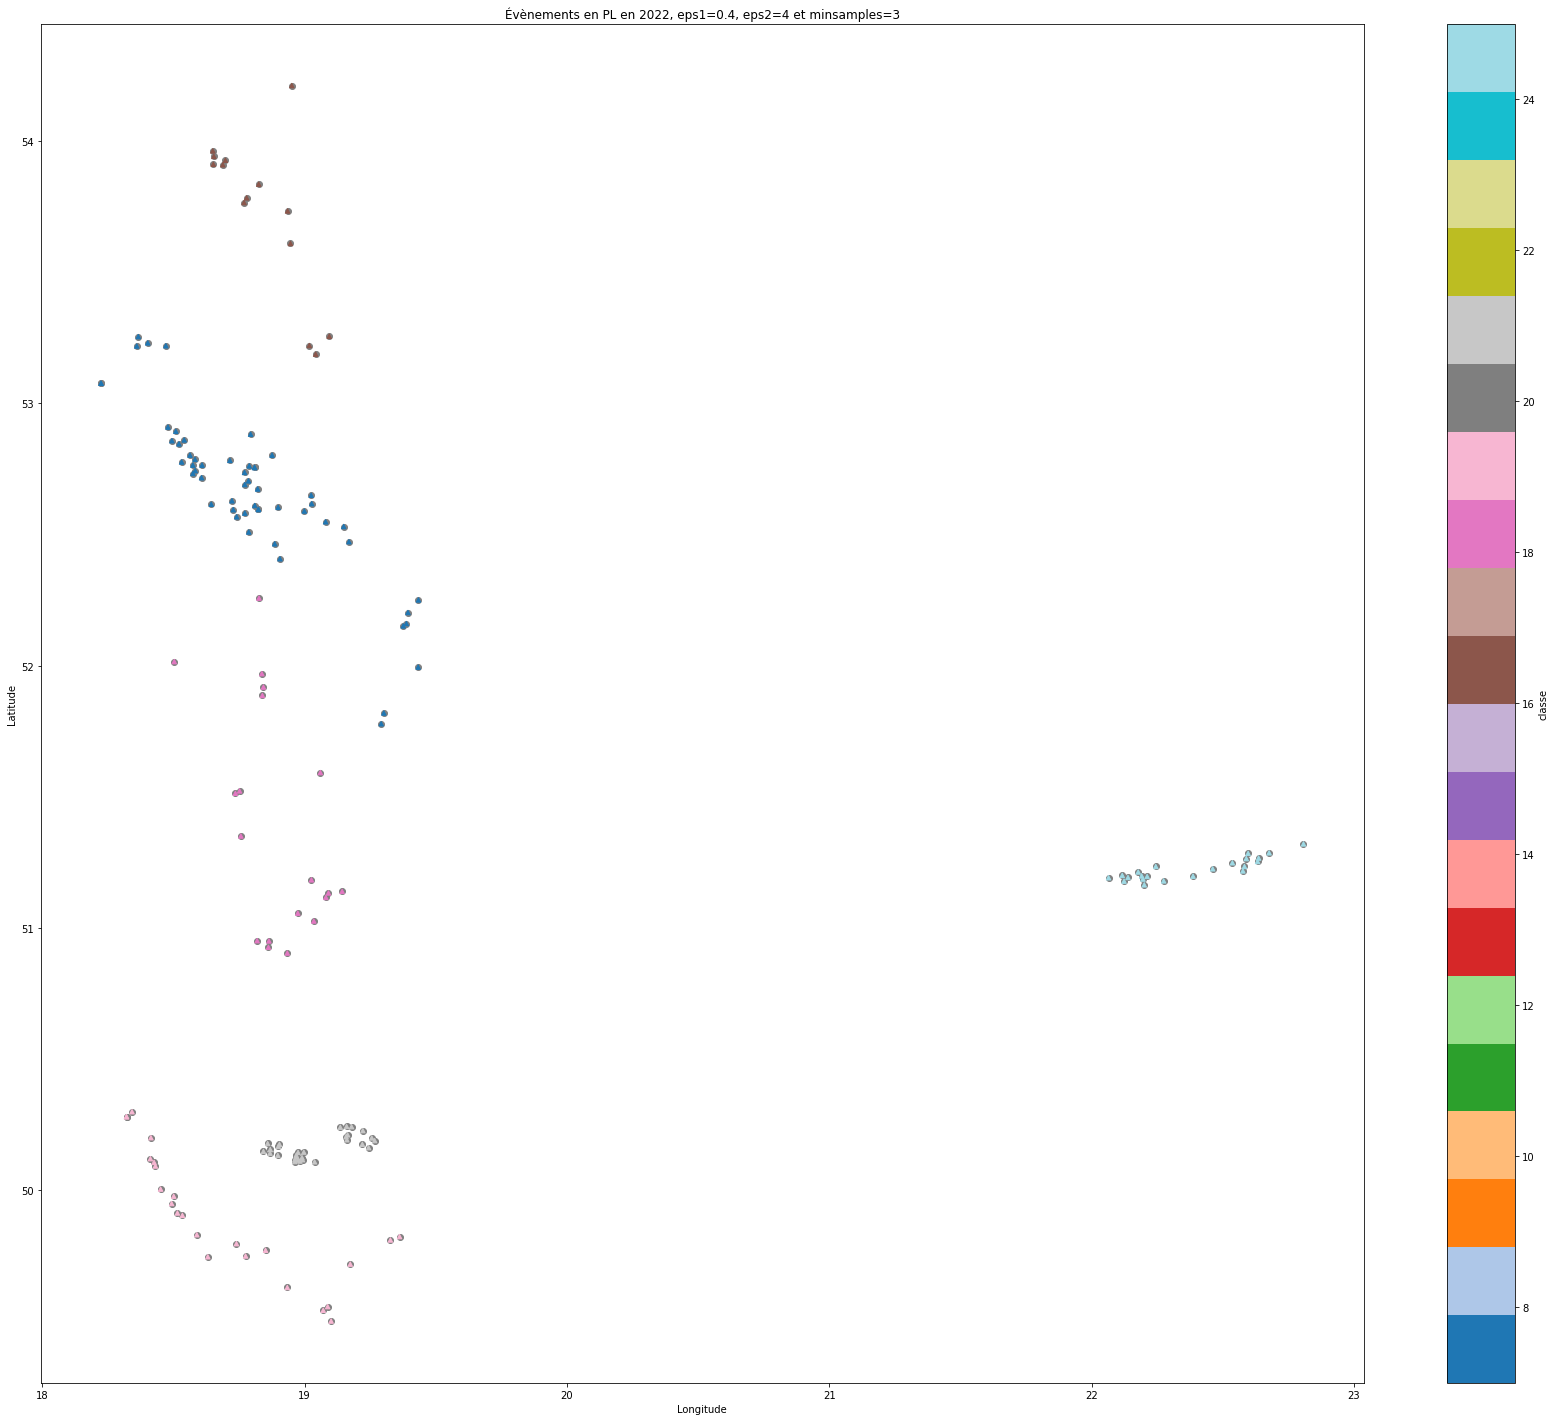

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             66        66         66       66
 0              4         4          4        4
 1              3         3          3        3
 2             10        10         10       10
 3              5         5          5        5
 4              4         4          4        4
 5              6         6          6        6
 6              4         4          4        4
 7             58        58         58       58
 8              5         5          5        5
 9             10        10         10       10
 10             8         8          8        8
 11            13        13         13       13
 12             3         3          3        3
 13             4         4          4        4
 14             4         4          4        4
 15            14        14         14       14
 16             5         5          5        5
 17            19        19         19  

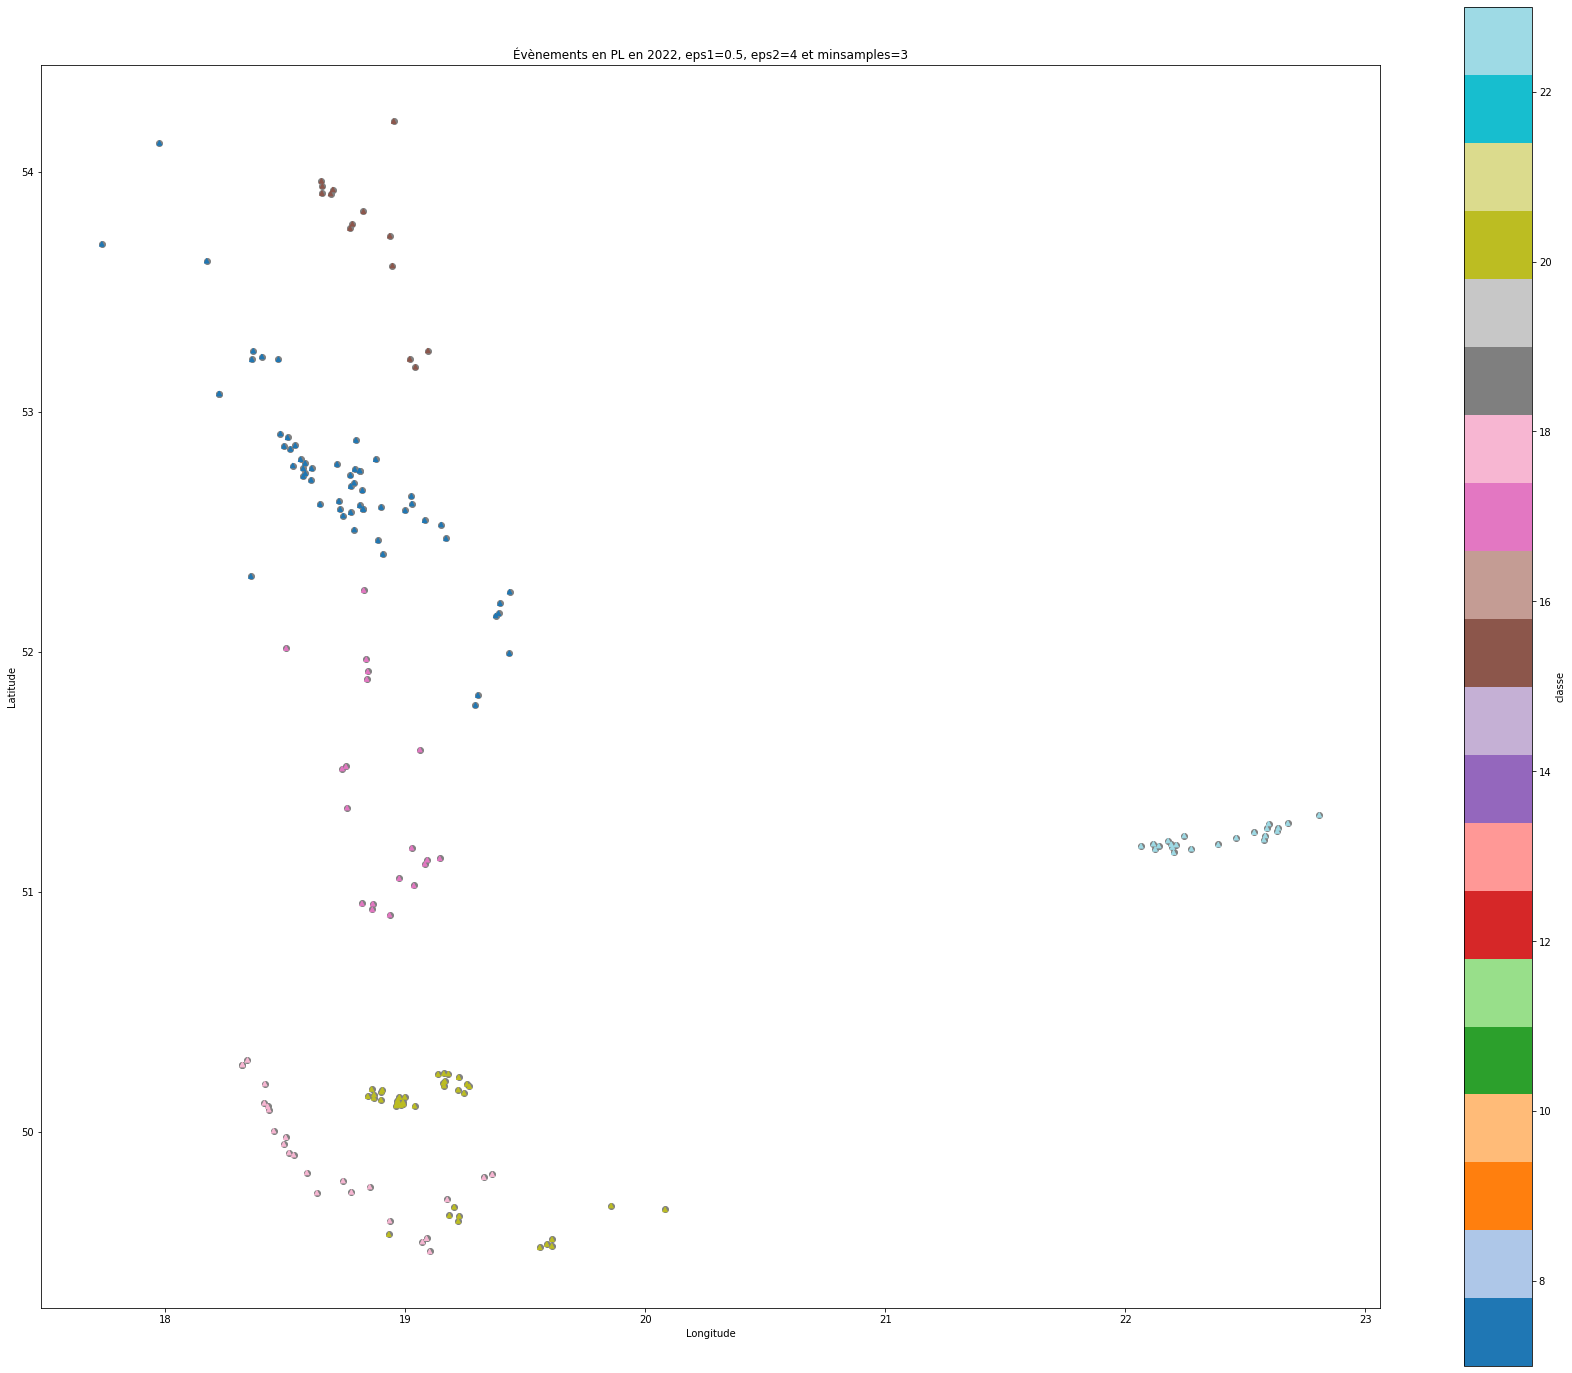

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             56        56         56       56
 0              4         4          4        4
 1              3         3          3        3
 2             10        10         10       10
 3              5         5          5        5
 4              4         4          4        4
 5              6         6          6        6
 6              4         4          4        4
 7             59        59         59       59
 8              5         5          5        5
 9             16        16         16       16
 10            10        10         10       10
 11            14        14         14       14
 12             3         3          3        3
 13             4         4          4        4
 14            14        14         14       14
 15             5         5          5        5
 16            20        20         20       20
 17            24        24         24  

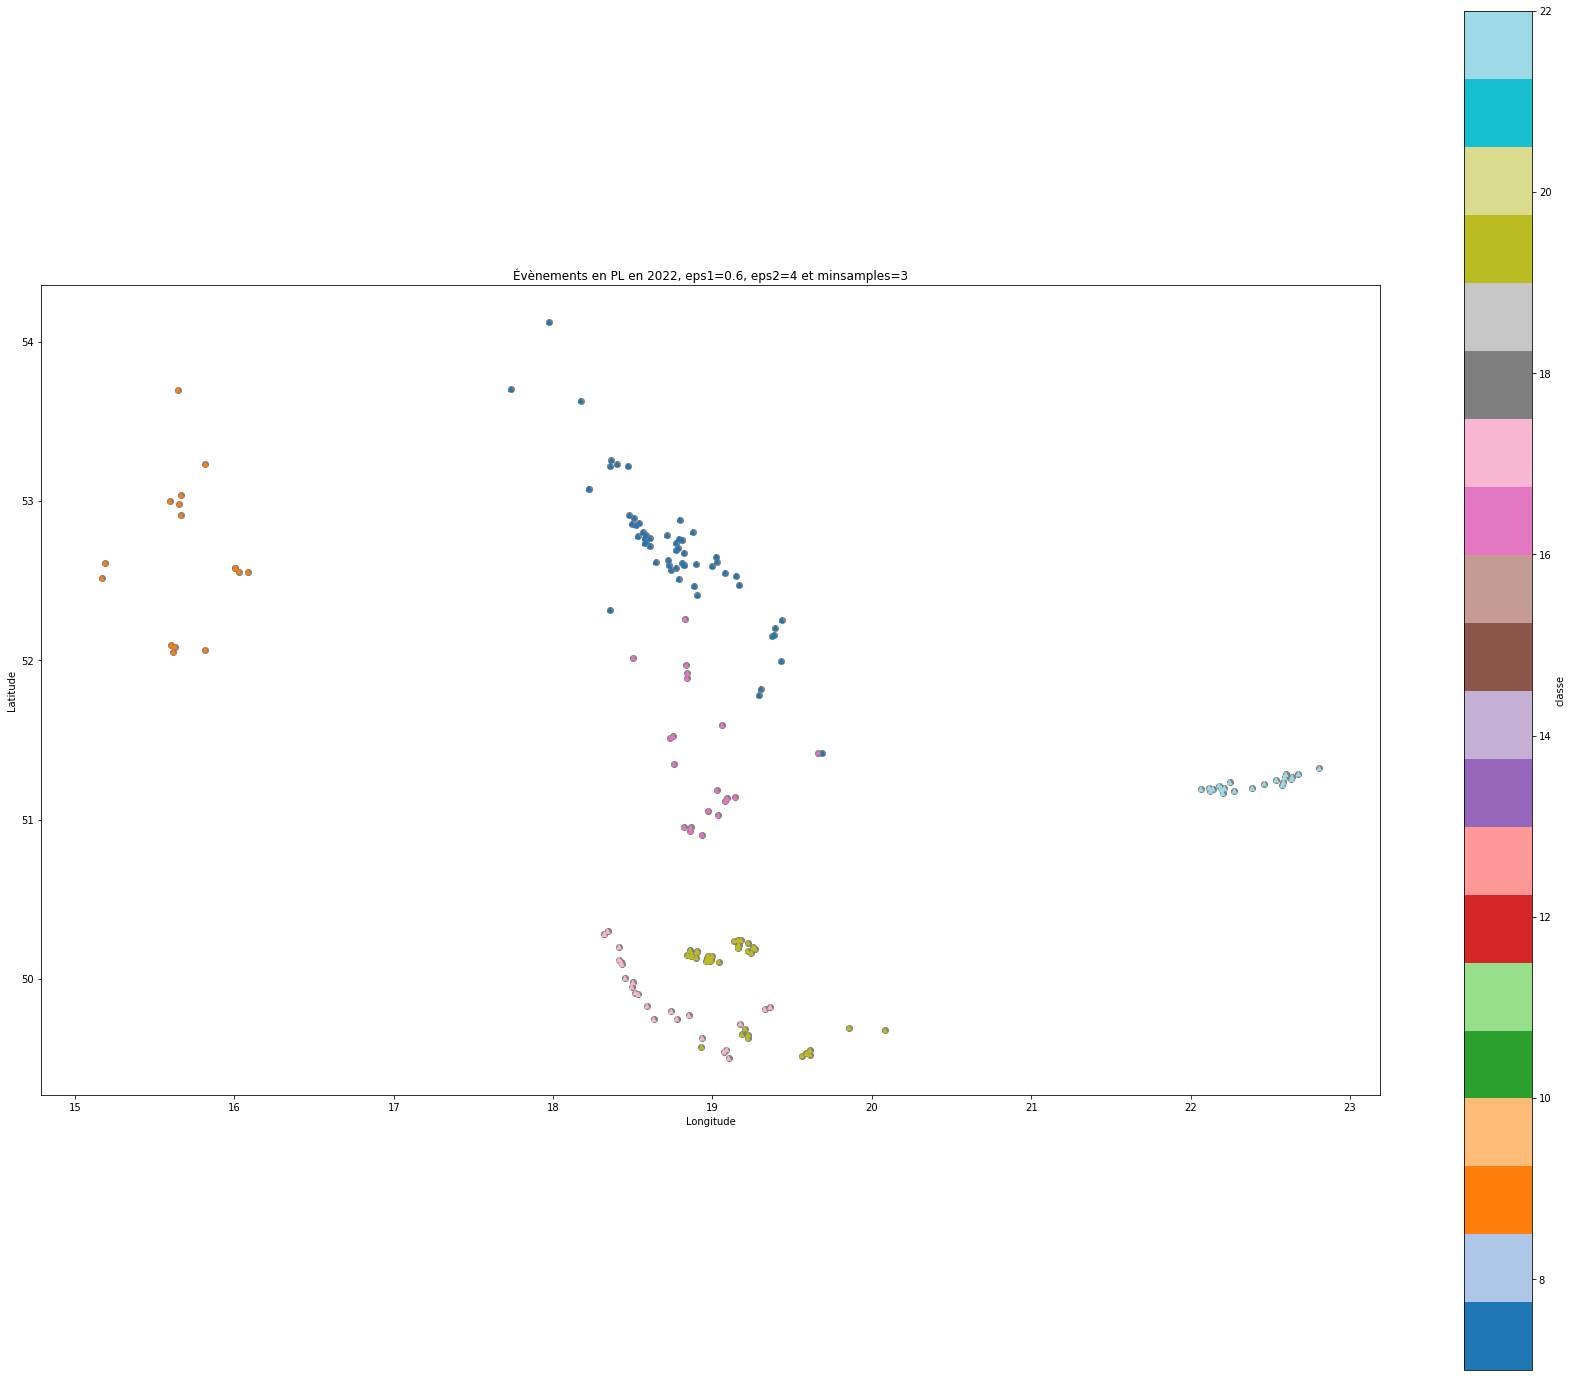

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             47        47         47       47
 0              4         4          4        4
 1              3         3          3        3
 2              6         6          6        6
 3             10        10         10       10
 4              5         5          5        5
 5              6         6          6        6
 6              5         5          5        5
 7             59        59         59       59
 8              5         5          5        5
 9             33        33         33       33
 10            10        10         10       10
 11             4         4          4        4
 12            14        14         14       14
 13             5         5          5        5
 14            29        29         29       29
 15            24        24         24       24
 16            40        40         40       40
 17             3         3          3  

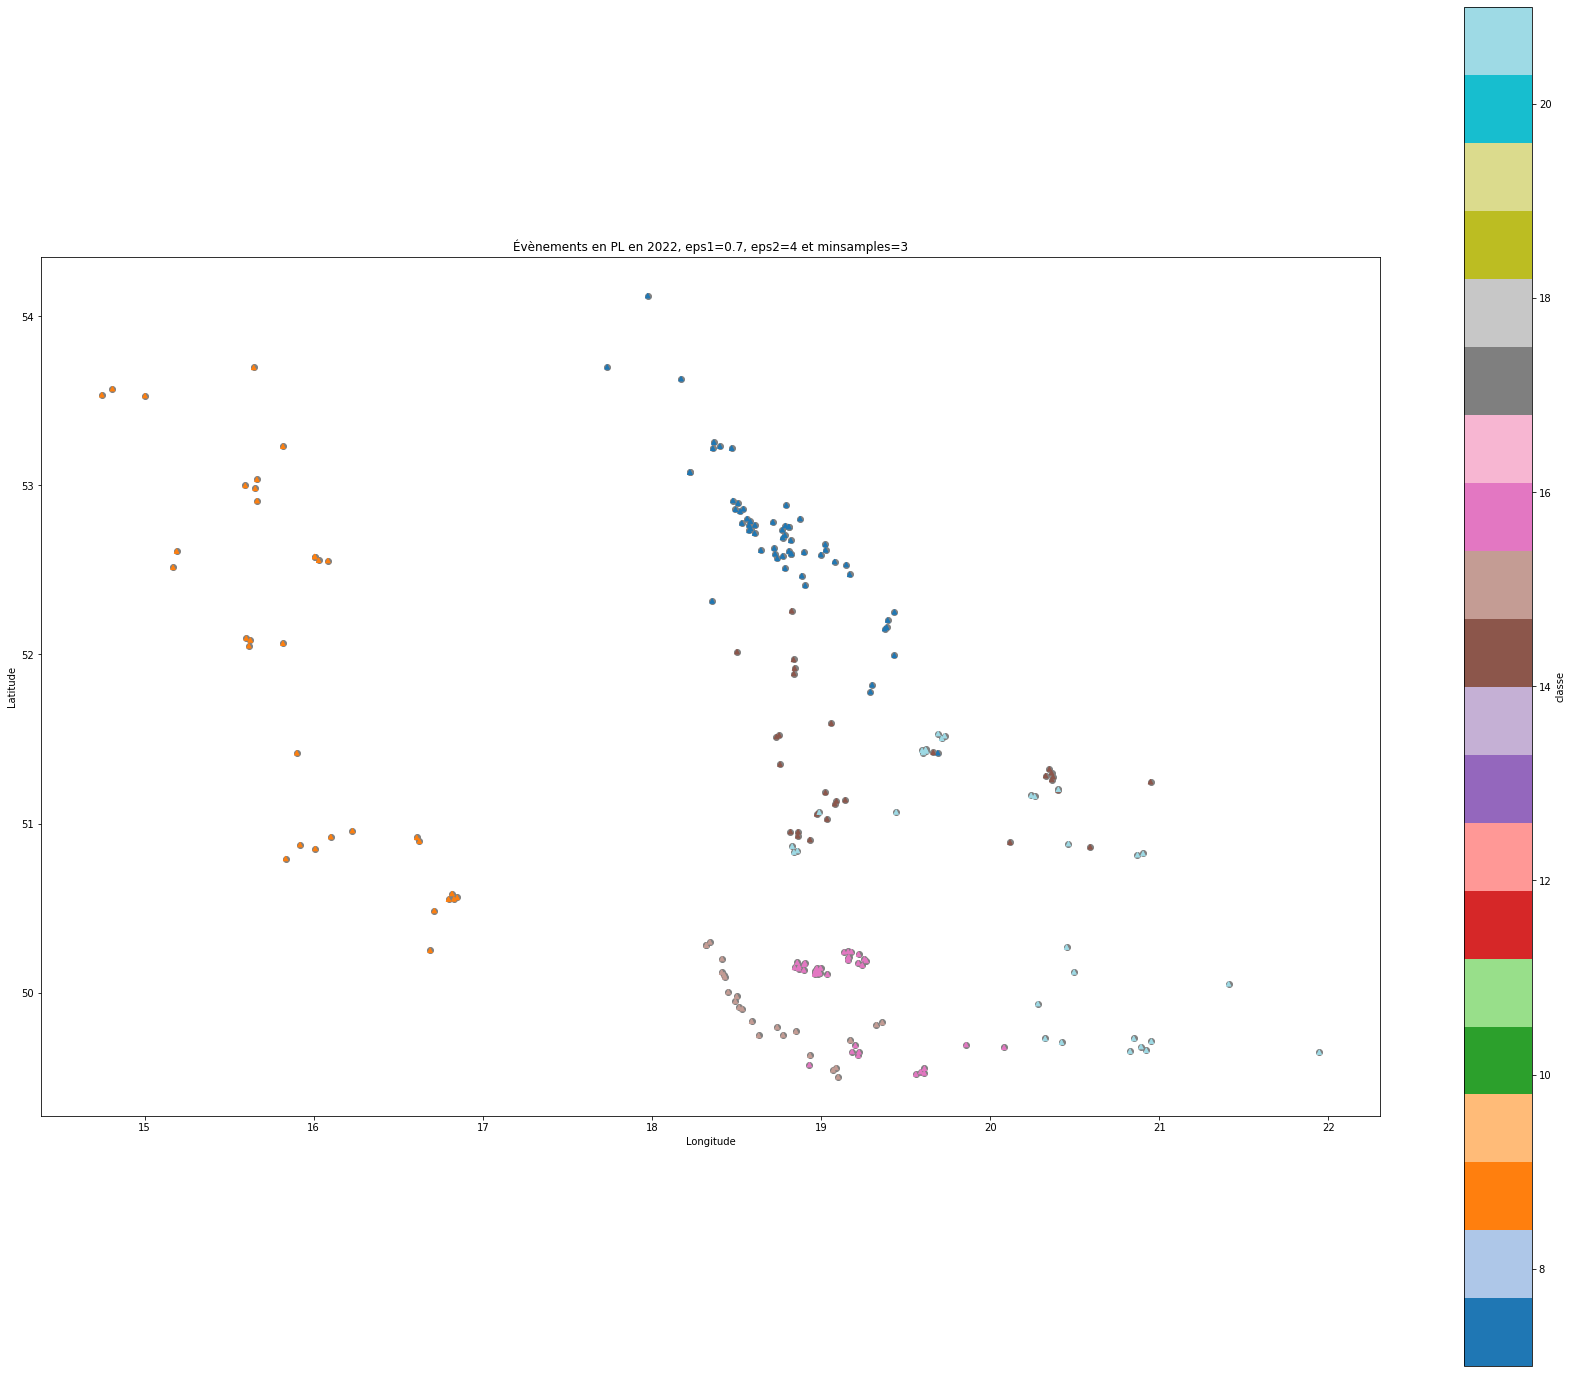

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             45        45         45       45
 0              4         4          4        4
 1              3         3          3        3
 2             16        16         16       16
 3              5         5          5        5
 4              5         5          5        5
 5              6         6          6        6
 6            106       106        106      106
 7              5         5          5        5
 8             14        14         14       14
 9              5         5          5        5
 10            31        31         31       31
 11            24        24         24       24
 12            40        40         40       40
 13             3         3          3        3
 14             6         6          6        6
 15            22        22         22       22
 16             5         5          5        5
 17            30        30         30  

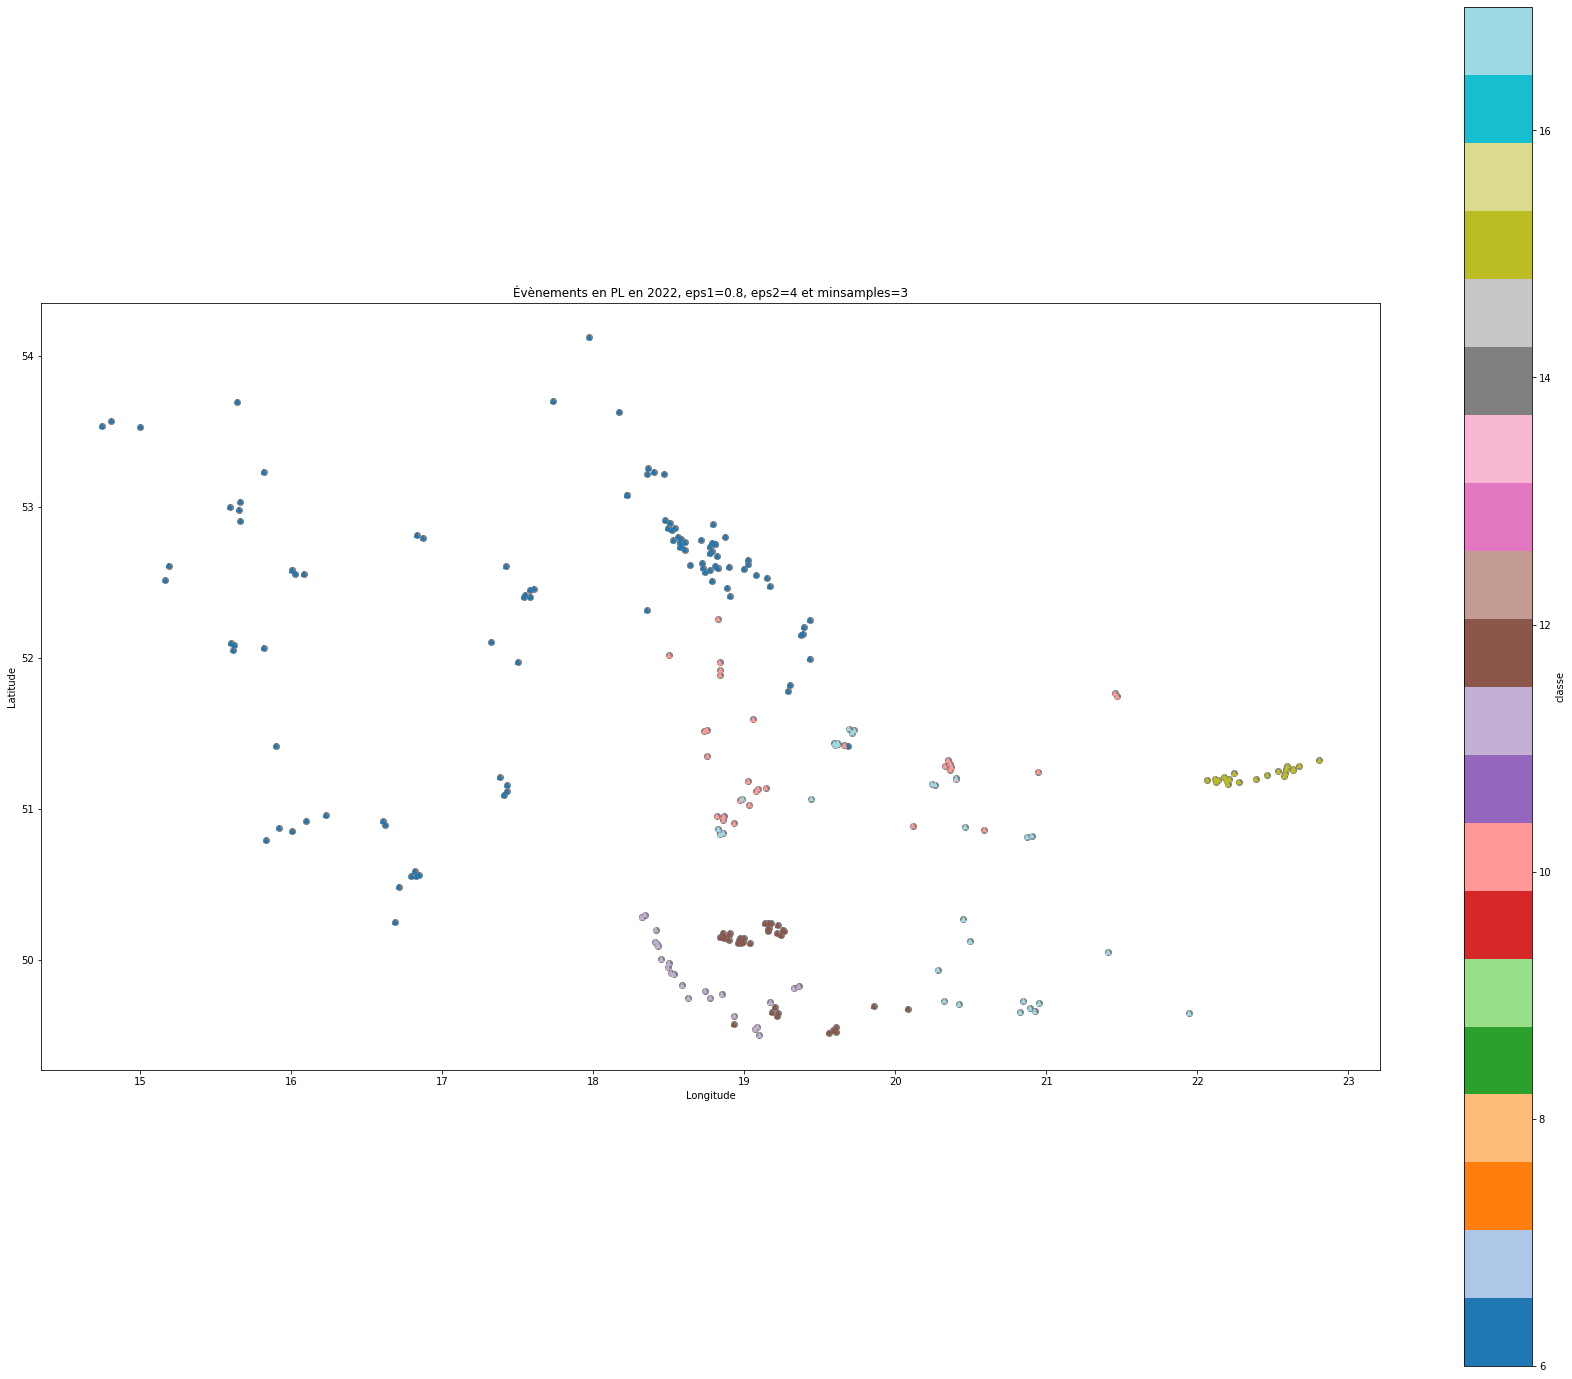

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             42        42         42       42
 0              4         4          4        4
 1              3         3          3        3
 2             16        16         16       16
 3              6         6          6        6
 4              5         5          5        5
 5              6         6          6        6
 6            106       106        106      106
 7              5         5          5        5
 8             14        14         14       14
 9             60        60         60       60
 10            40        40         40       40
 11             3         3          3        3
 12             6         6          6        6
 13            22        22         22       22
 14             5         5          5        5
 15            31        31         31       31
 16             8         8          8        8
 17            13        13         13  

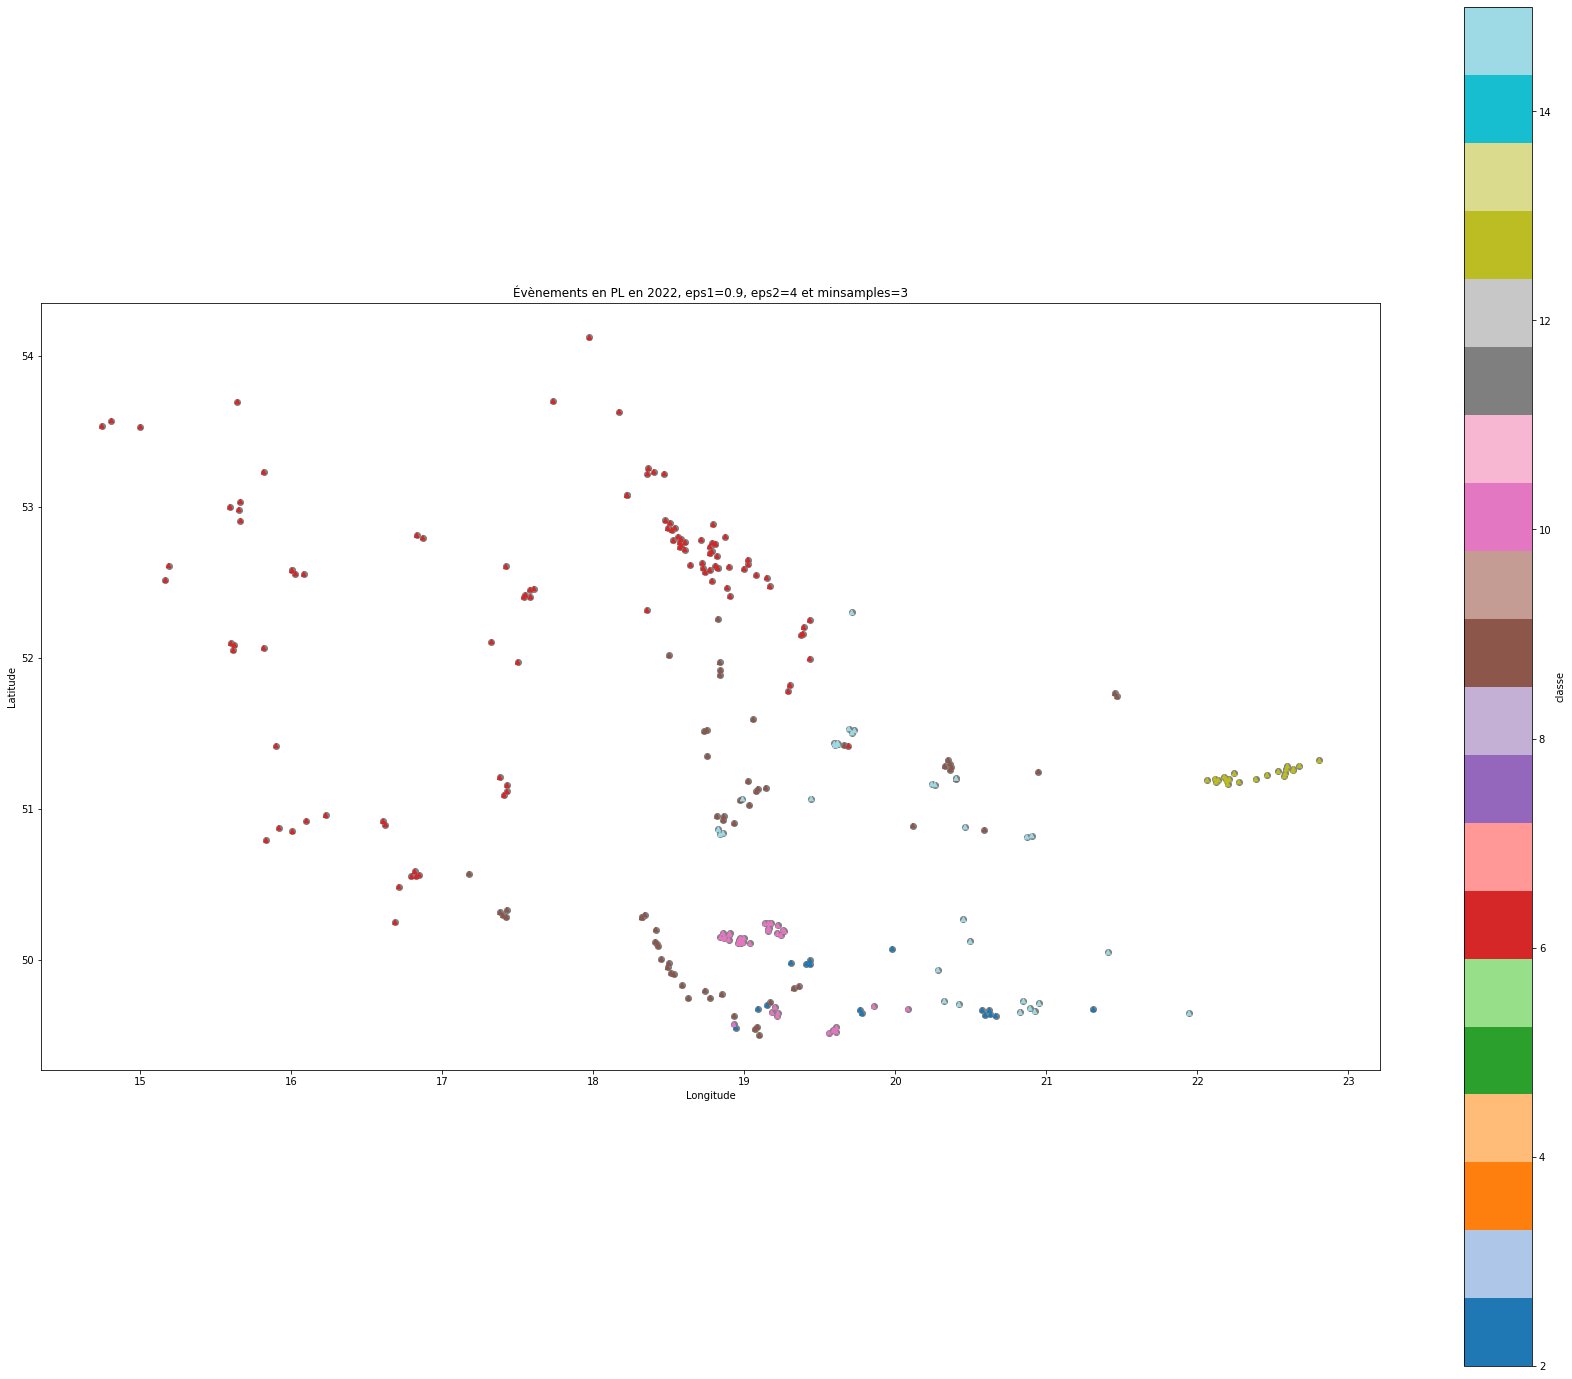

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             40        40         40       40
 0              4         4          4        4
 1              3         3          3        3
 2             16        16         16       16
 3              6         6          6        6
 4              5         5          5        5
 5            112       112        112      112
 6              5         5          5        5
 7             74        74         74       74
 8             40        40         40       40
 9              5         5          5        5
 10             6         6          6        6
 11            22        22         22       22
 12             5         5          5        5
 13            31        31         31       31
 14             8         8          8        8
 15            13        13         13       13
 16             3         3          3        3
 17             3         3          3  

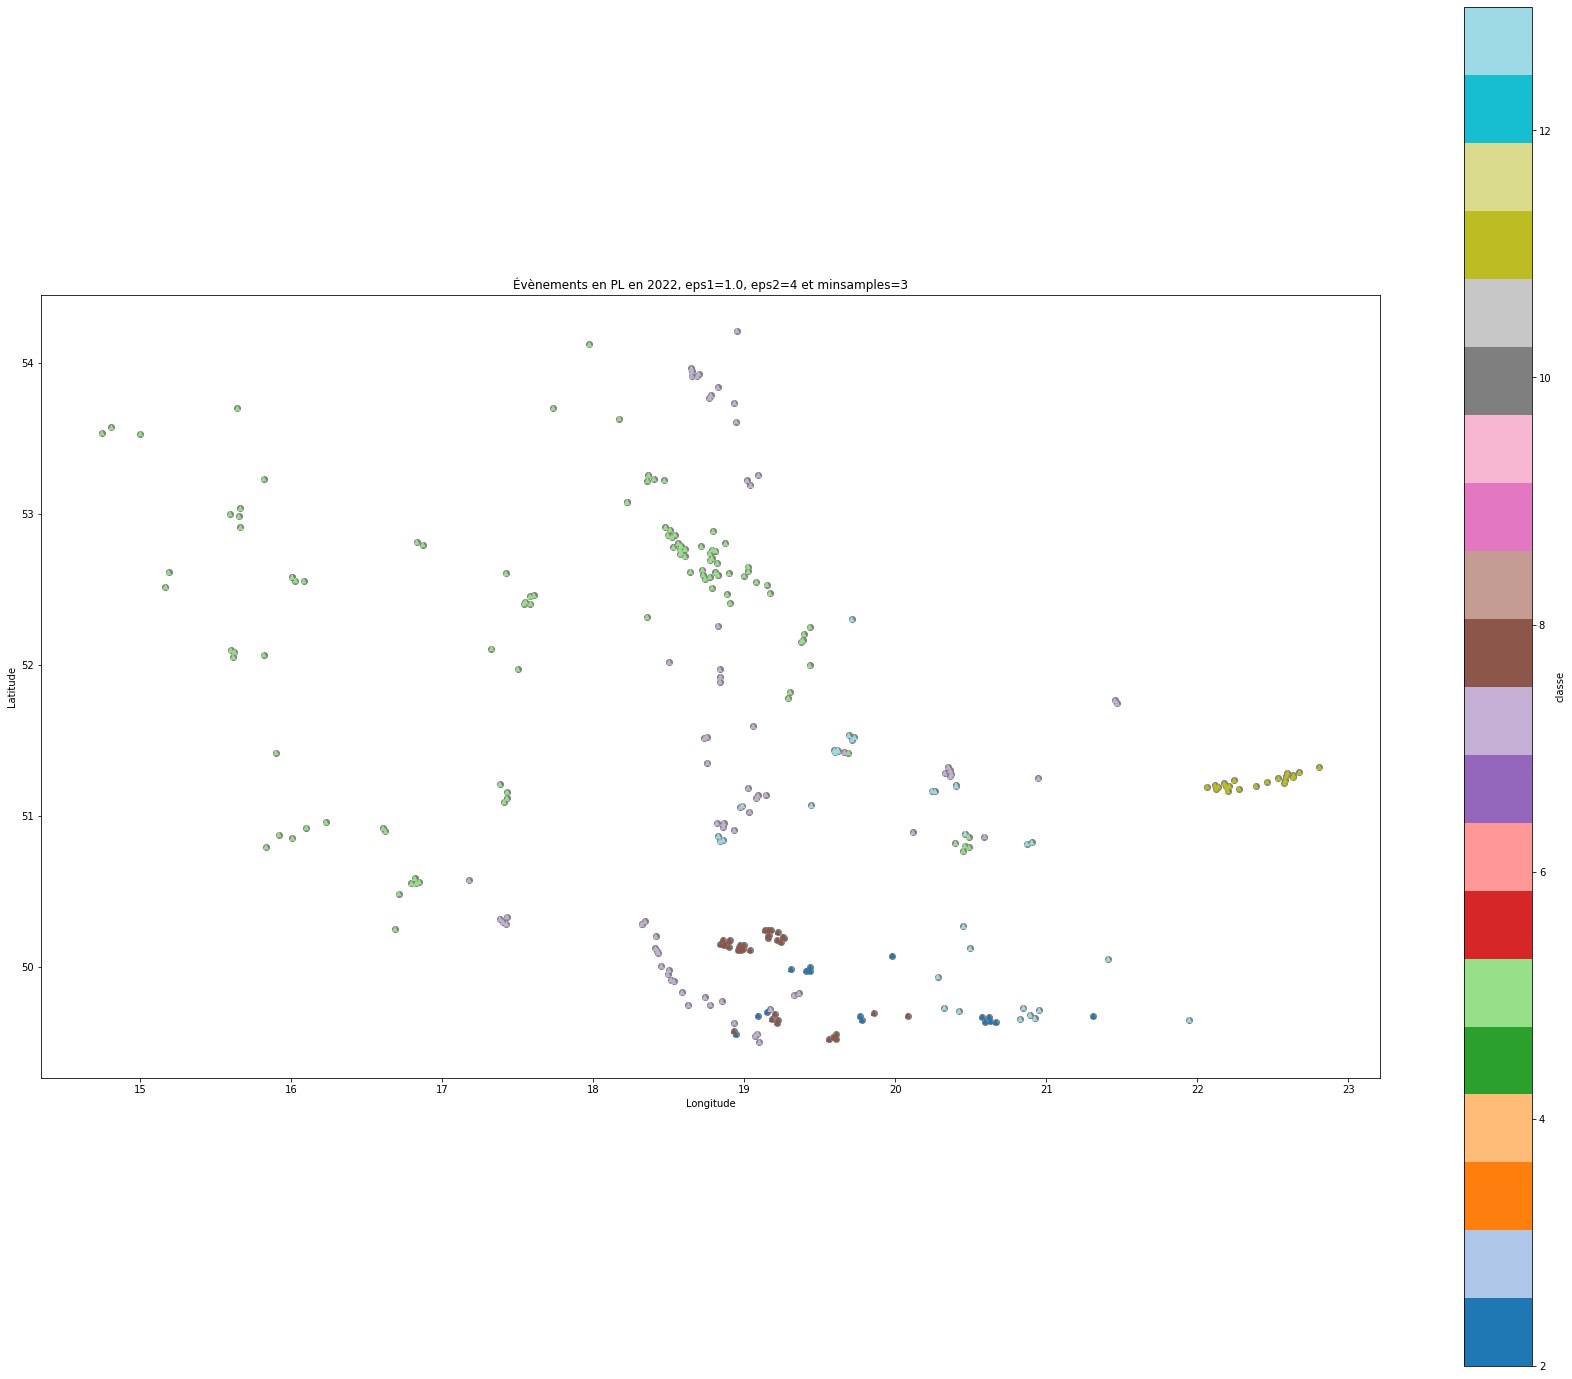

In [ ]:
x="PL"

for i in range(1,11,1):
    y=i/10
    
    clusterise_country_year(x, 2022, y, 4, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             56        56         56       56
 0              2         2          2        2
 1              2         2          2        2
 2              4         4          4        4
 3              2         2          2        2
 4              3         3          3        3
 5              2         2          2        2
 6              2         2          2        2
 7              5         5          5        5
 8              3         3          3        3
 9              2         2          2        2
 10             4         4          4        4
 11             4         4          4        4
 12             6         6          6        6
 13             4         4          4        4
 14             2         2          2        2
 15             7         7          7        7
 16            41        41         41       41
 17             6         6          6  

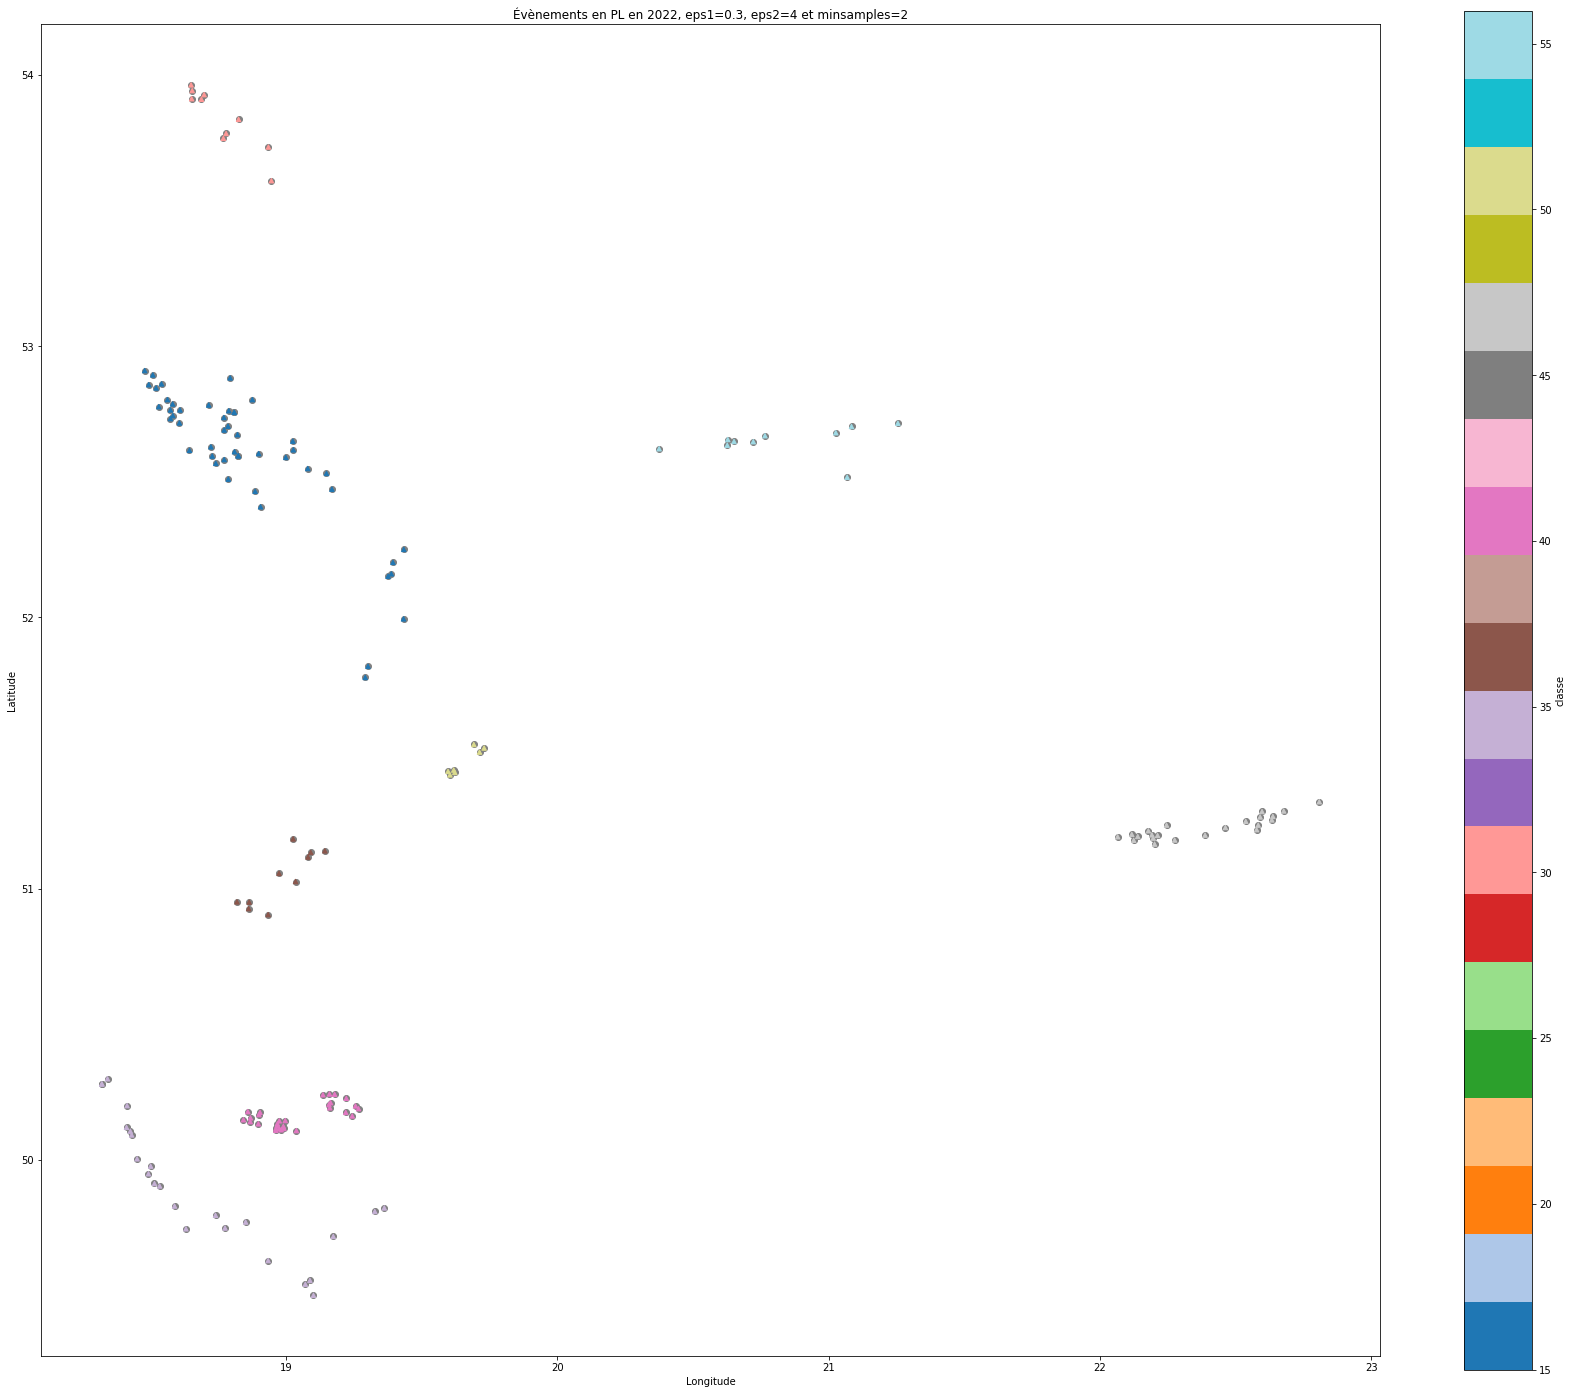

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             88        88         88       88
 0              4         4          4        4
 1              3         3          3        3
 2              5         5          5        5
 3              3         3          3        3
 4              4         4          4        4
 5              4         4          4        4
 6              6         6          6        6
 7              4         4          4        4
 8              7         7          7        7
 9             41        41         41       41
 10             6         6          6        6
 11             5         5          5        5
 12             4         4          4        4
 13             6         6          6        6
 14             6         6          6        6
 15             5         5          5        5
 16             3         3          3        3
 17             4         4          4  

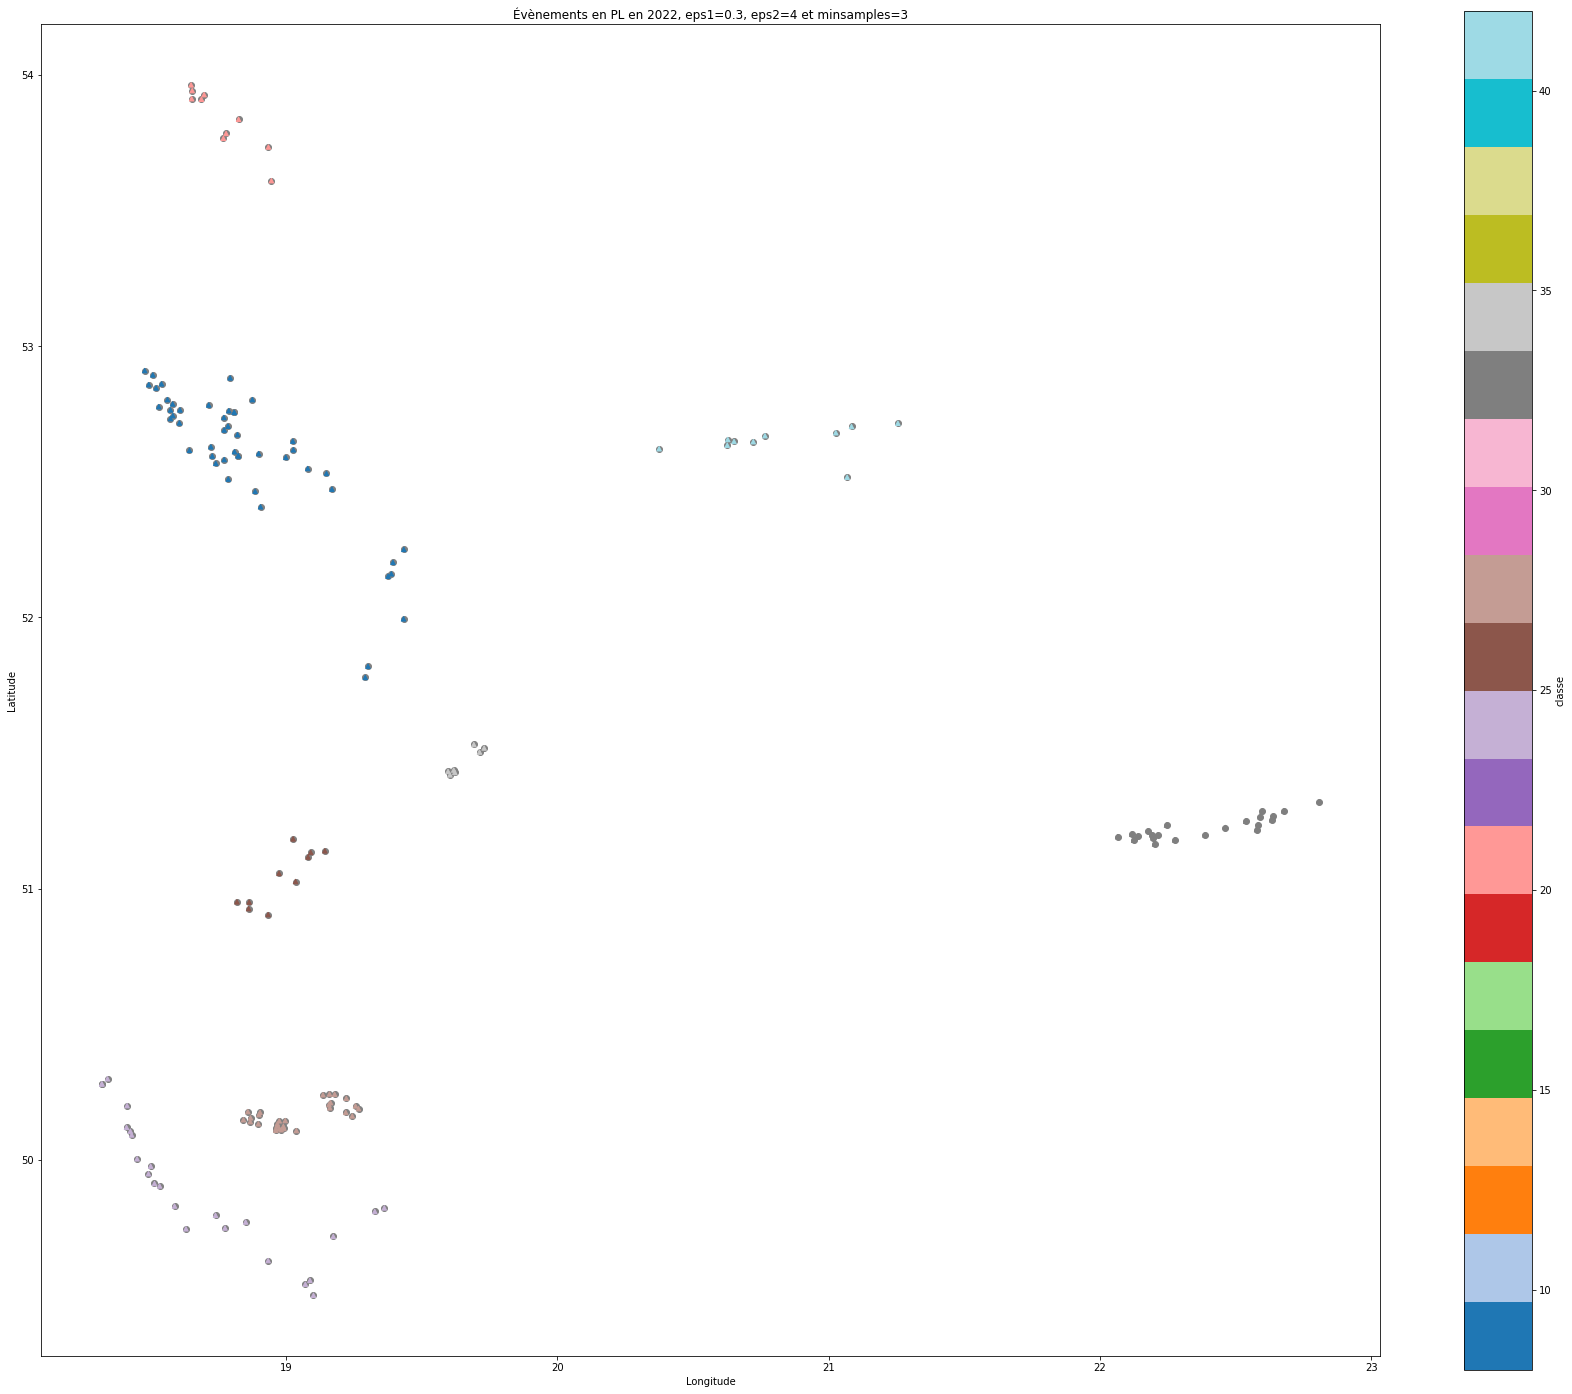

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            116       116        116      116
 0              4         4          4        4
 1              5         5          5        5
 2              4         4          4        4
 3              4         4          4        4
 4              6         6          6        6
 5              7         7          7        7
 6             41        41         41       41
 7              4         4          4        4
 8              6         6          6        6
 9              5         5          5        5
 10             4         4          4        4
 11             6         6          6        6
 12             6         6          6        6
 13             5         5          5        5
 14             4         4          4        4
 15             4         4          4        4
 16             5         5          5        5
 17            10        10         10  

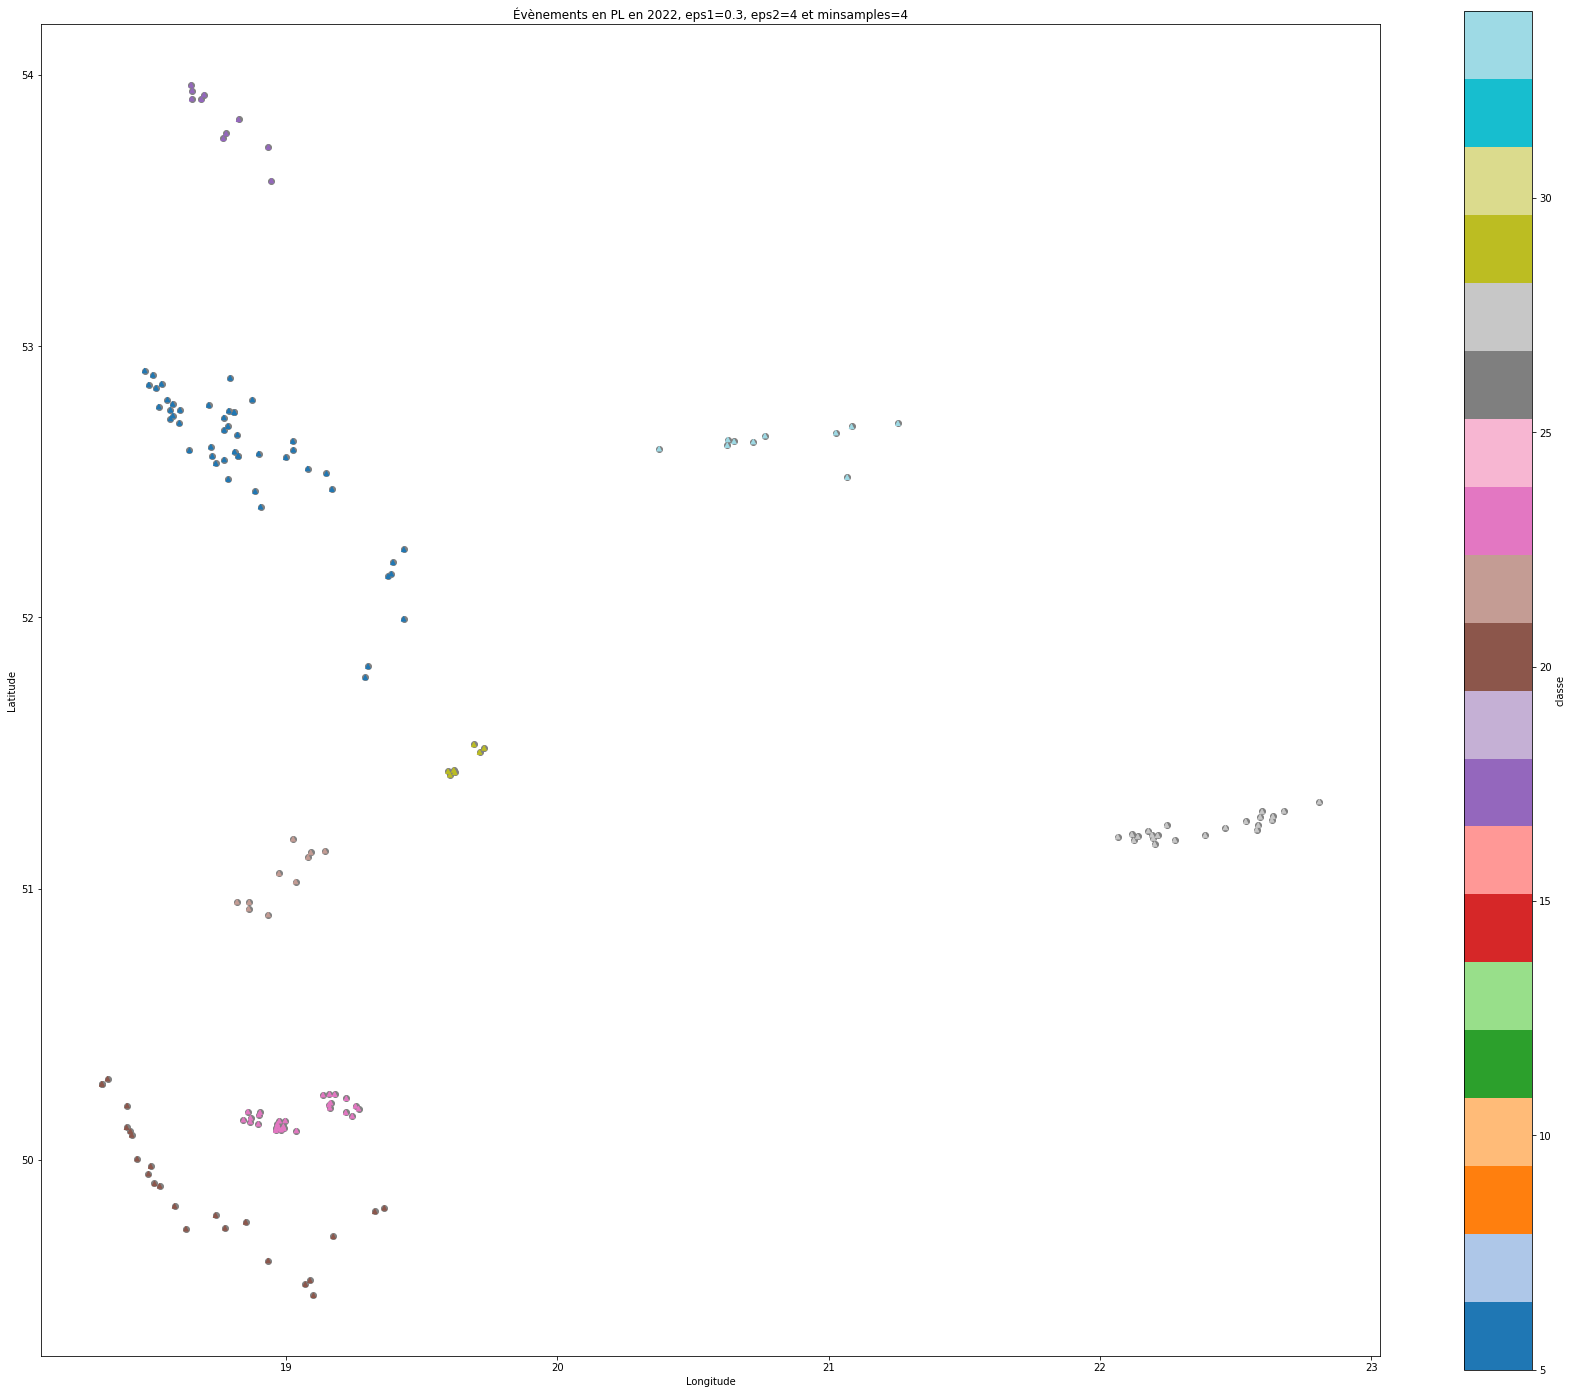

In [ ]:
x="PL"

for i in range(2,5):    
    clusterise_country_year(x, 2022,0.3, 4,i)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            251       251        251      251
 0              7         7          7        7
 1              7         7          7        7
 2              8         8          8        8
 3             17        17         17       17
 4              6         6          6        6
 5              5         5          5        5
 6              3         3          3        3
 7              3         3          3        3
 8              4         4          4        4
 9             19        19         19       19
 10             3         3          3        3
 11            19        19         19       19
 12             6         6          6        6
 13             3         3          3        3
 14             3         3          3        3
 15             4         4          4        4
 16            11        11         11       11
 17             4         4          4  

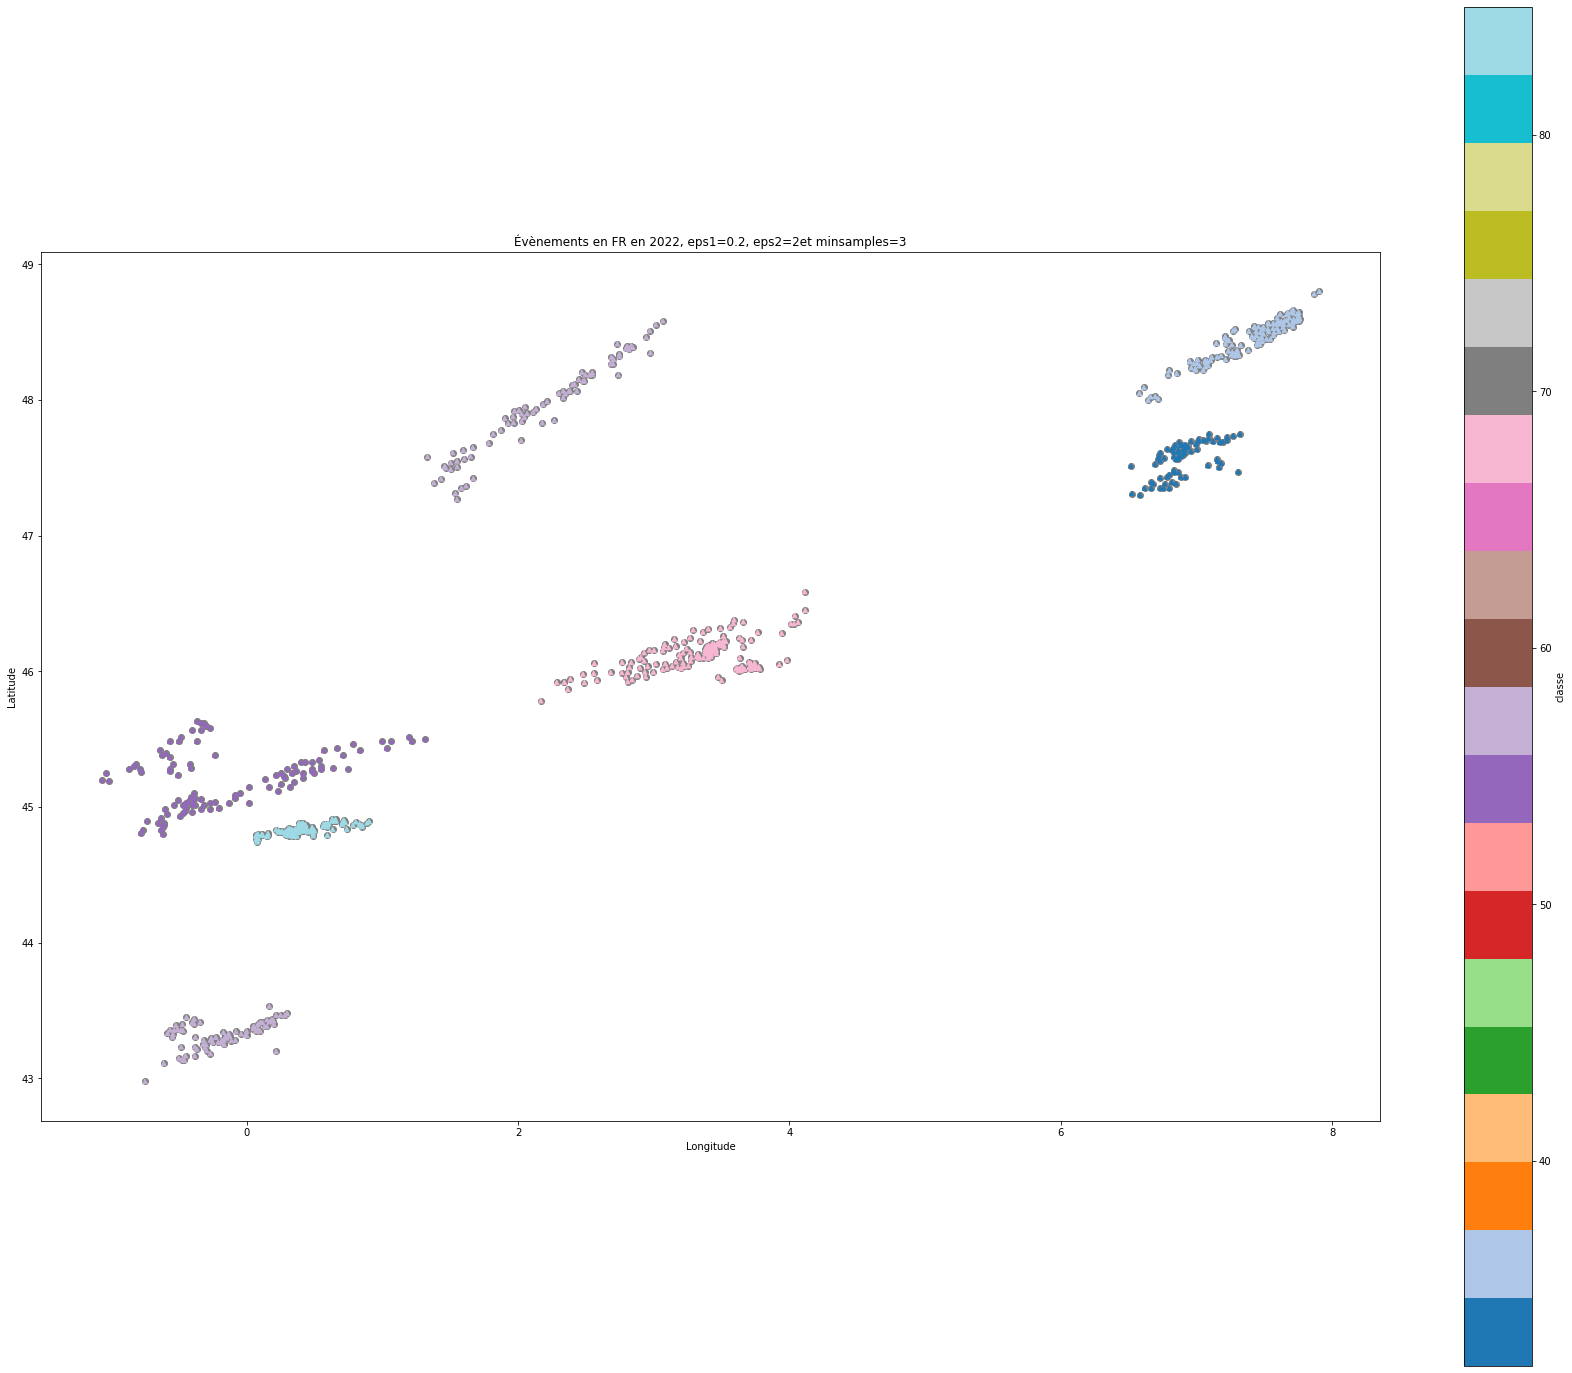

In [ ]:
x="FR"

clusterise_country_year(x, 2022, 0.2, 2, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            212       212        212      212
 0              7         7          7        7
 1             15        15         15       15
 2             18        18         18       18
 3              6         6          6        6
 4              5         5          5        5
 5              3         3          3        3
 6              3         3          3        3
 7              4         4          4        4
 8              3         3          3        3
 9             18        18         18       18
 10            21        21         21       21
 11             6         6          6        6
 12             3         3          3        3
 13             5         5          5        5
 14             4         4          4        4
 15             8         8          8        8
 16             3         3          3        3
 17             4         4          4  

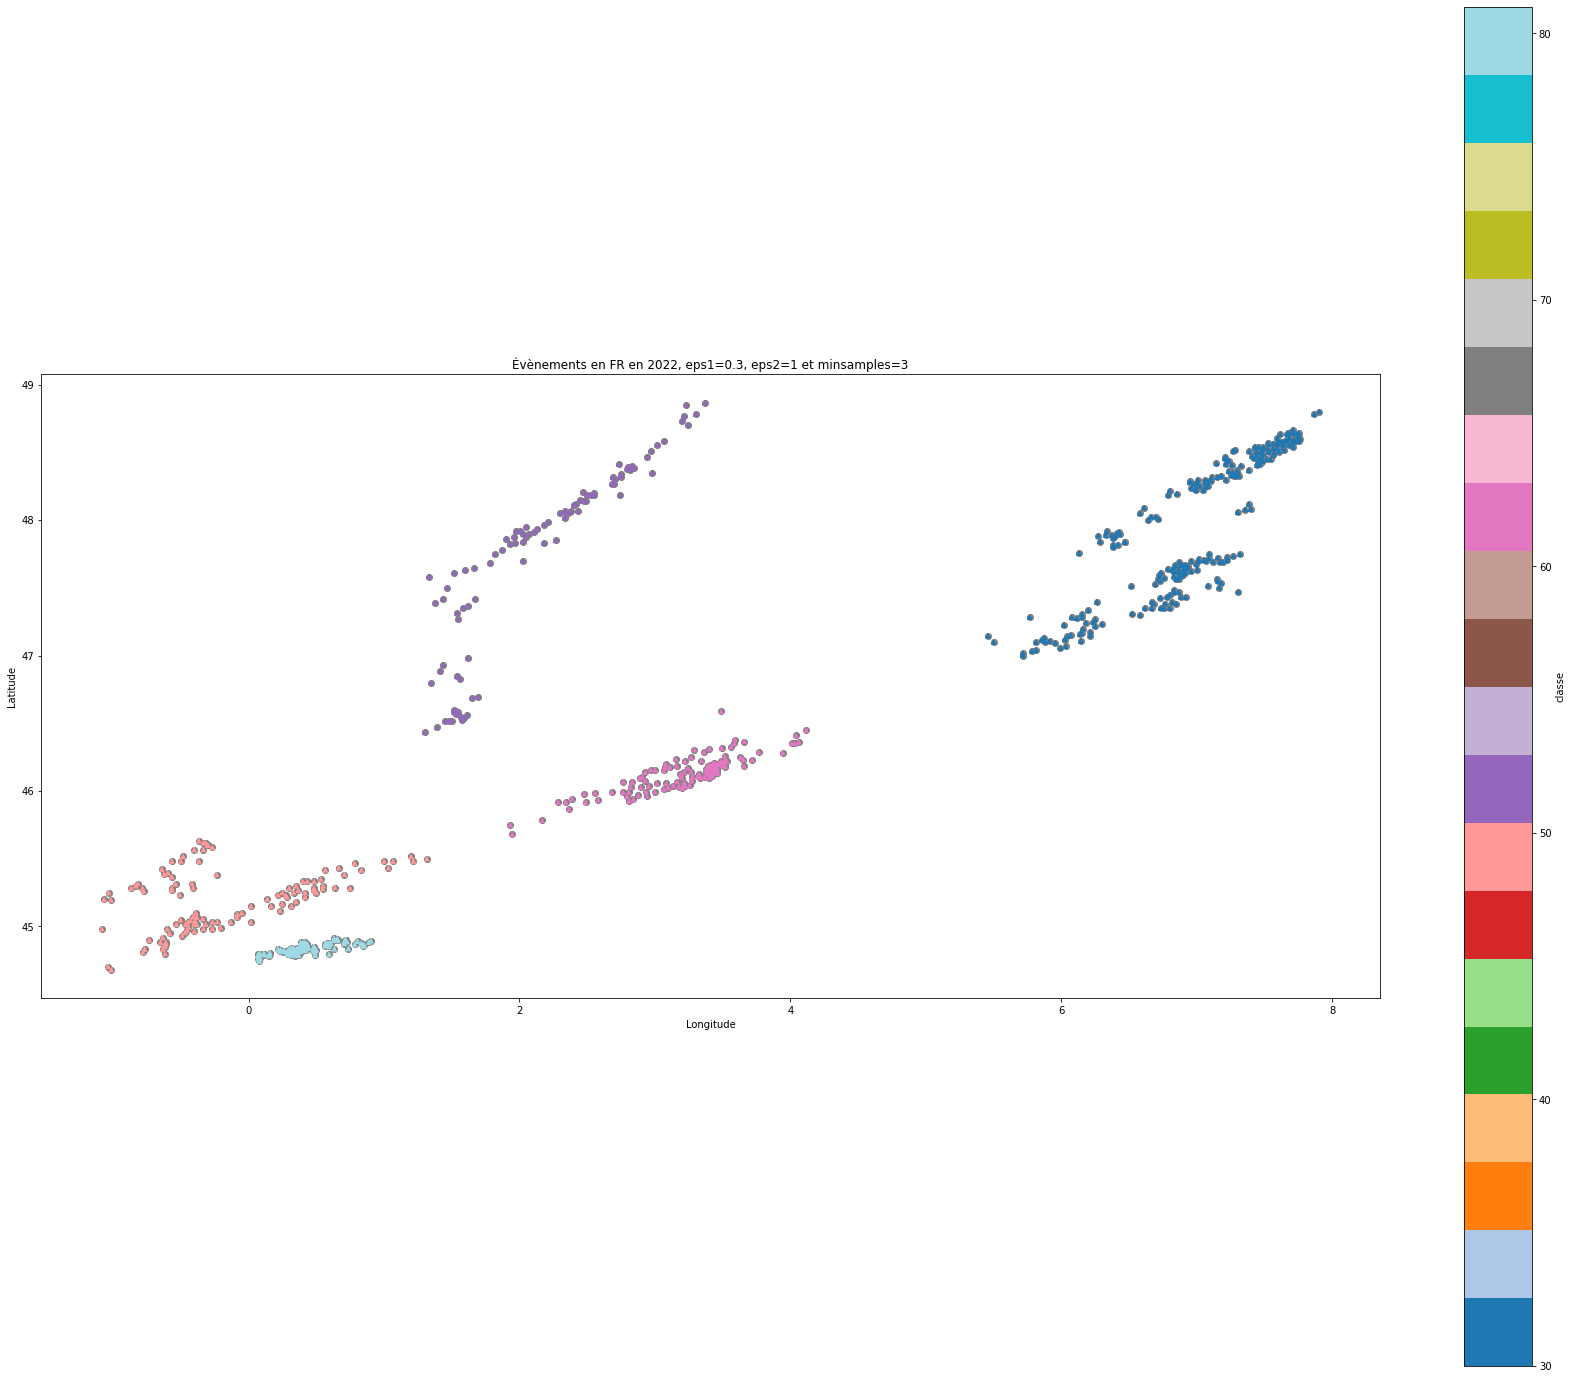

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            192       192        192      192
 0             26        26         26       26
 1             15        15         15       15
 2              6         6          6        6
 3              5         5          5        5
 4              3         3          3        3
 5              3         3          3        3
 6              4         4          4        4
 7             19        19         19       19
 8              3         3          3        3
 9             21        21         21       21
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            11        11         11       11
 15             4         4          4        4
 16            17        17         17       17
 17            17        17         17  

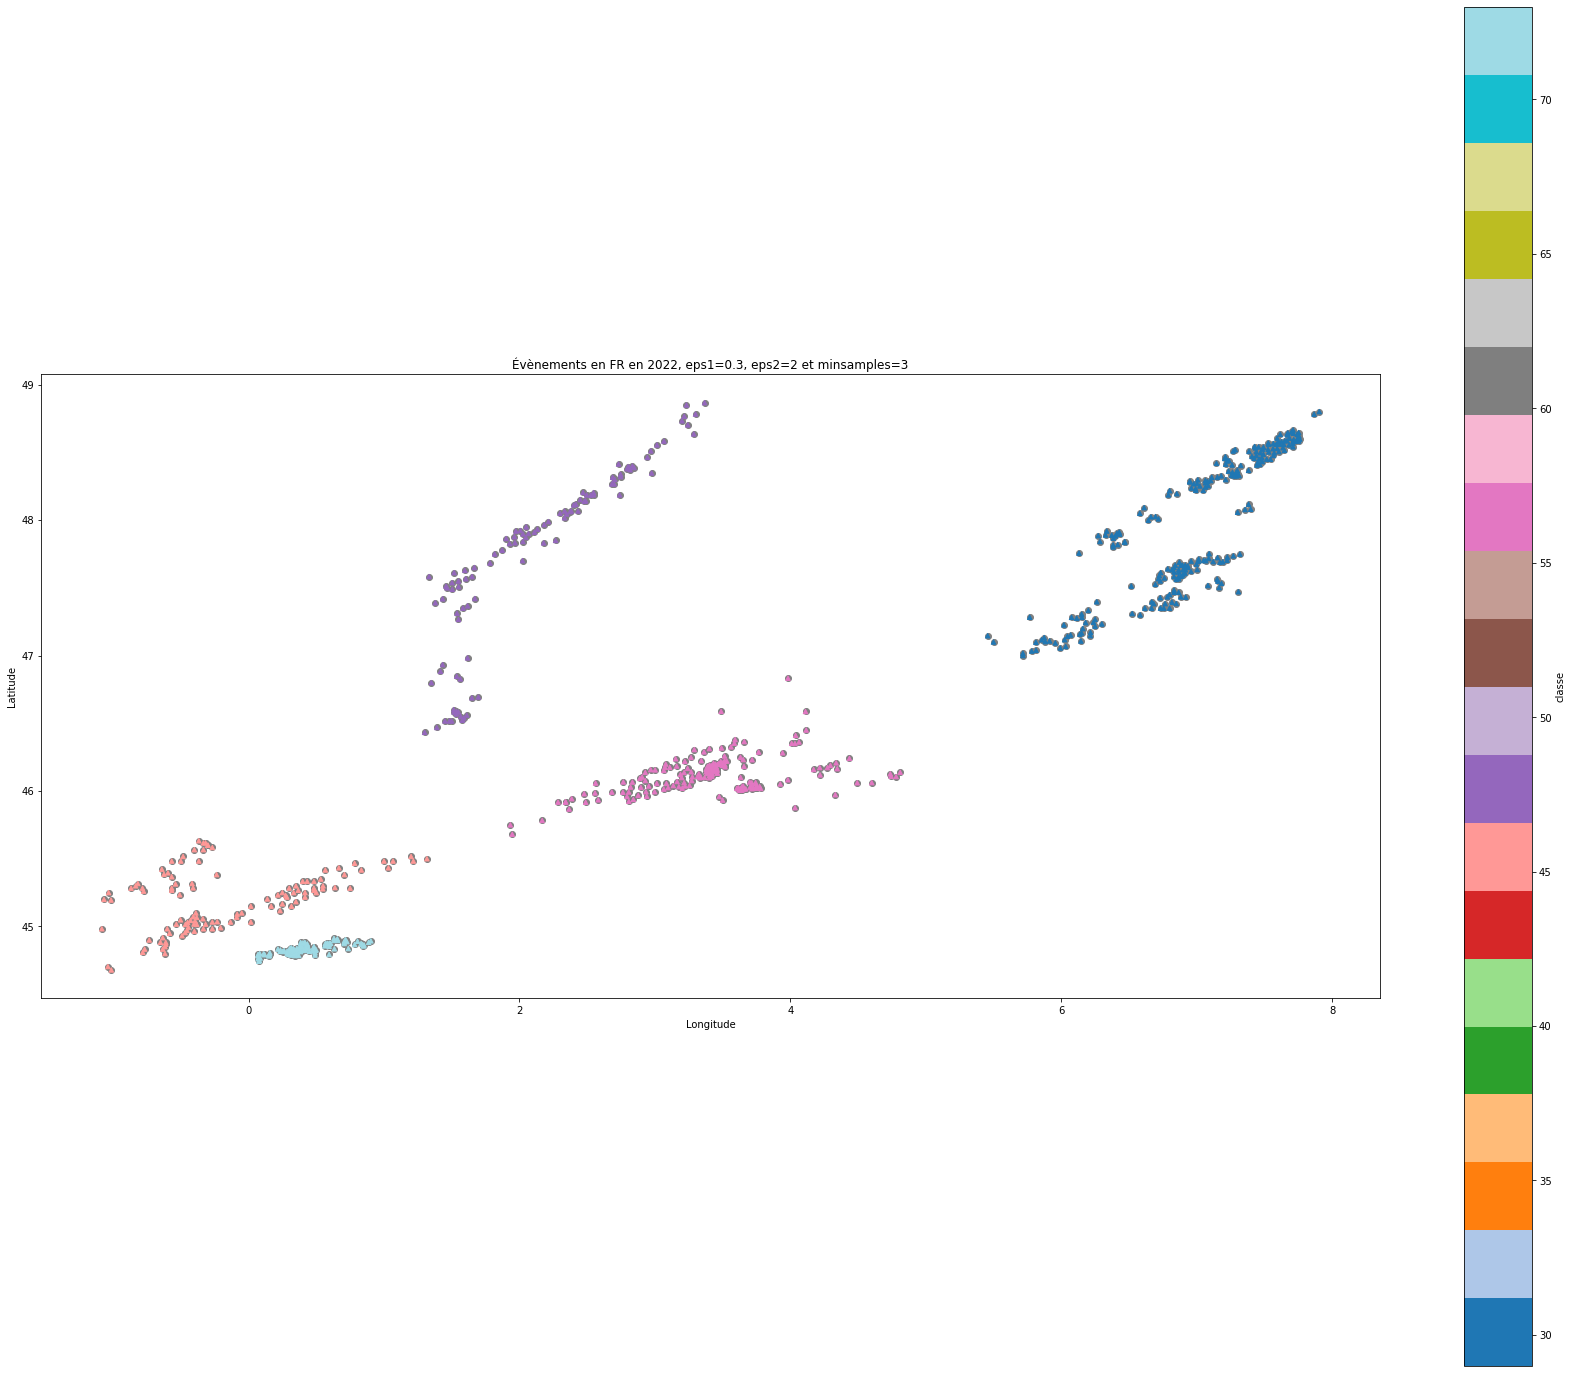

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            189       189        189      189
 0             26        26         26       26
 1             15        15         15       15
 2              6         6          6        6
 3              5         5          5        5
 4              3         3          3        3
 5              3         3          3        3
 6              4         4          4        4
 7             19        19         19       19
 8              3         3          3        3
 9             21        21         21       21
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            11        11         11       11
 15            21        21         21       21
 16            17        17         17       17
 17             4         4          4  

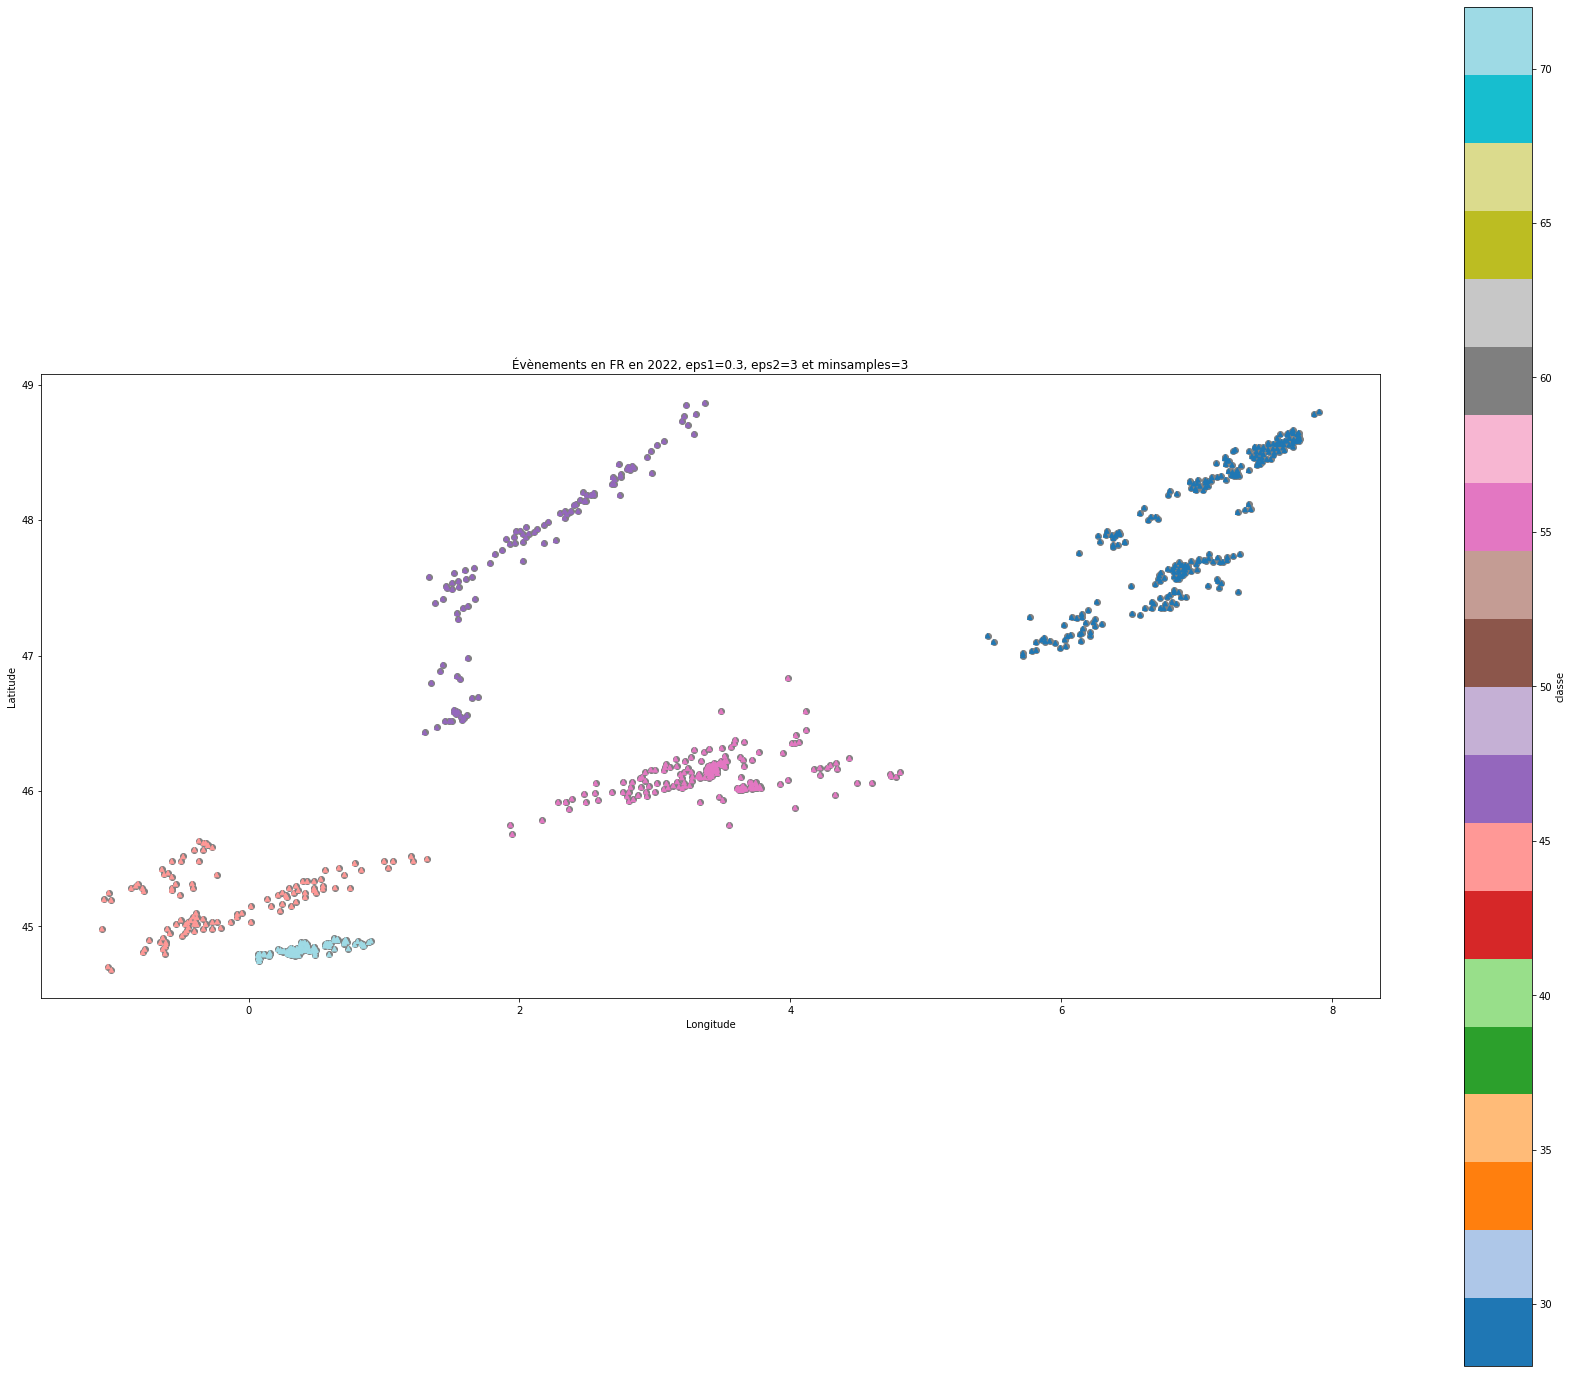

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            185       185        185      185
 0             26        26         26       26
 1             15        15         15       15
 2              6         6          6        6
 3              5         5          5        5
 4              3         3          3        3
 5              3         3          3        3
 6              4         4          4        4
 7             19        19         19       19
 8              3         3          3        3
 9             21        21         21       21
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            11        11         11       11
 15            21        21         21       21
 16            17        17         17       17
 17             4         4          4  

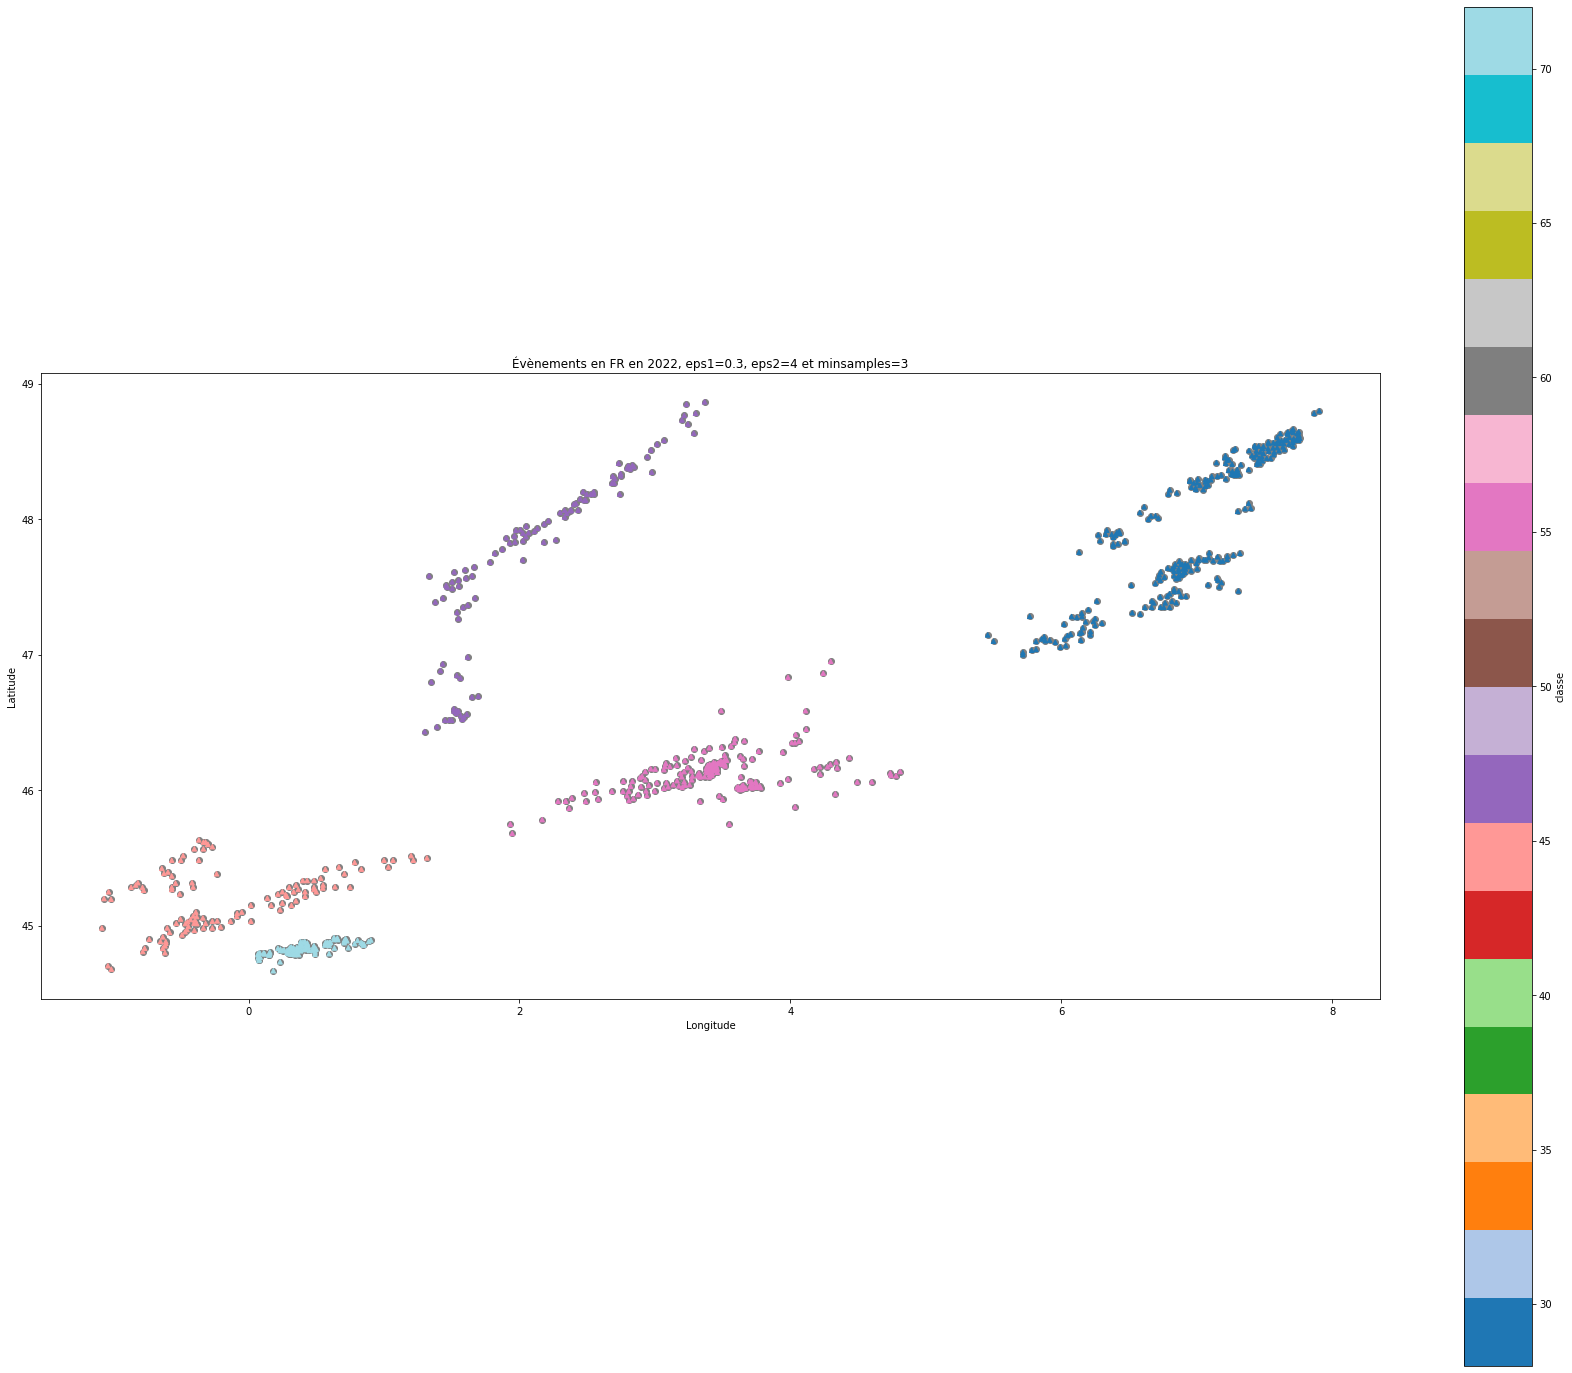

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            185       185        185      185
 0             26        26         26       26
 1             15        15         15       15
 2              6         6          6        6
 3              5         5          5        5
 4              3         3          3        3
 5              3         3          3        3
 6              4         4          4        4
 7             19        19         19       19
 8              3         3          3        3
 9             21        21         21       21
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            11        11         11       11
 15            21        21         21       21
 16            17        17         17       17
 17             4         4          4  

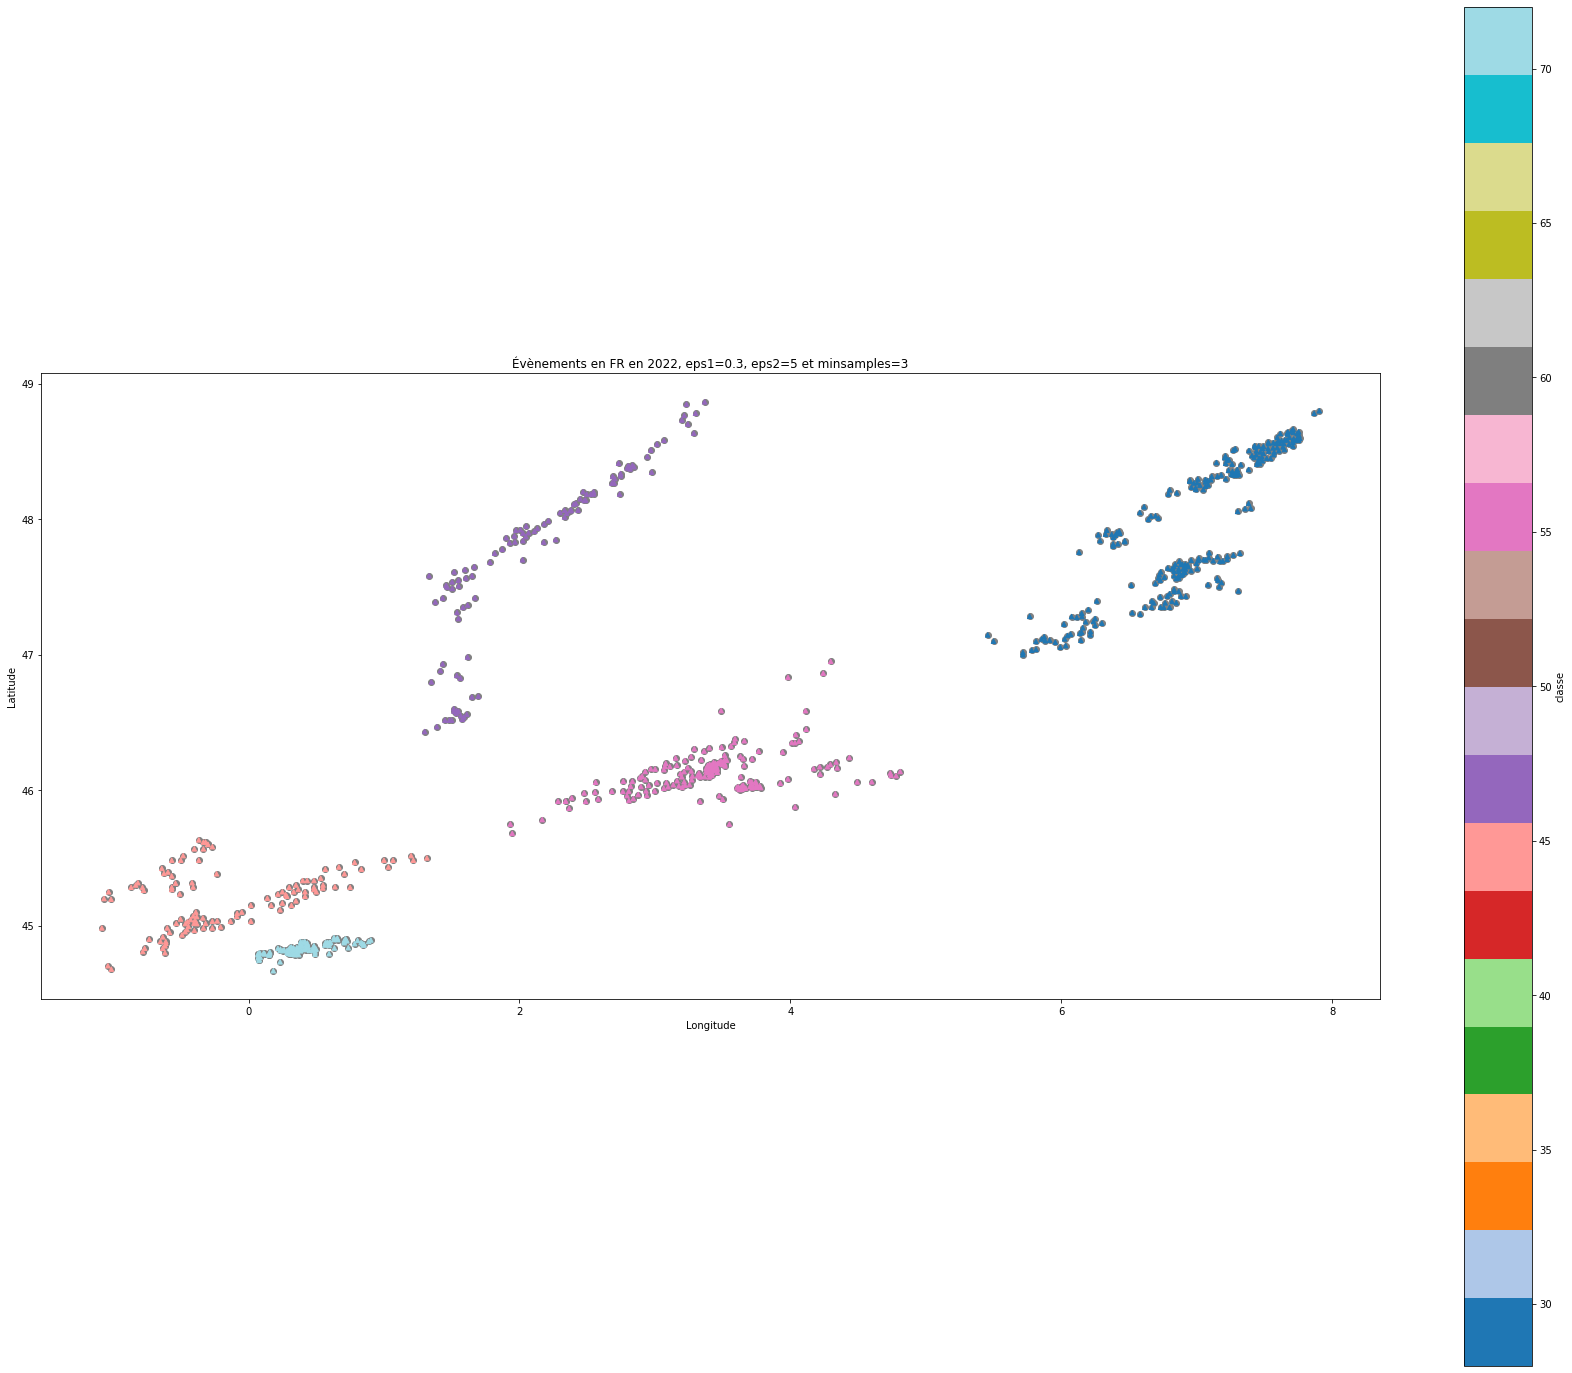

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            185       185        185      185
 0             26        26         26       26
 1             15        15         15       15
 2              6         6          6        6
 3              5         5          5        5
 4              3         3          3        3
 5              3         3          3        3
 6              4         4          4        4
 7             19        19         19       19
 8              3         3          3        3
 9             21        21         21       21
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            11        11         11       11
 15            21        21         21       21
 16            17        17         17       17
 17             4         4          4  

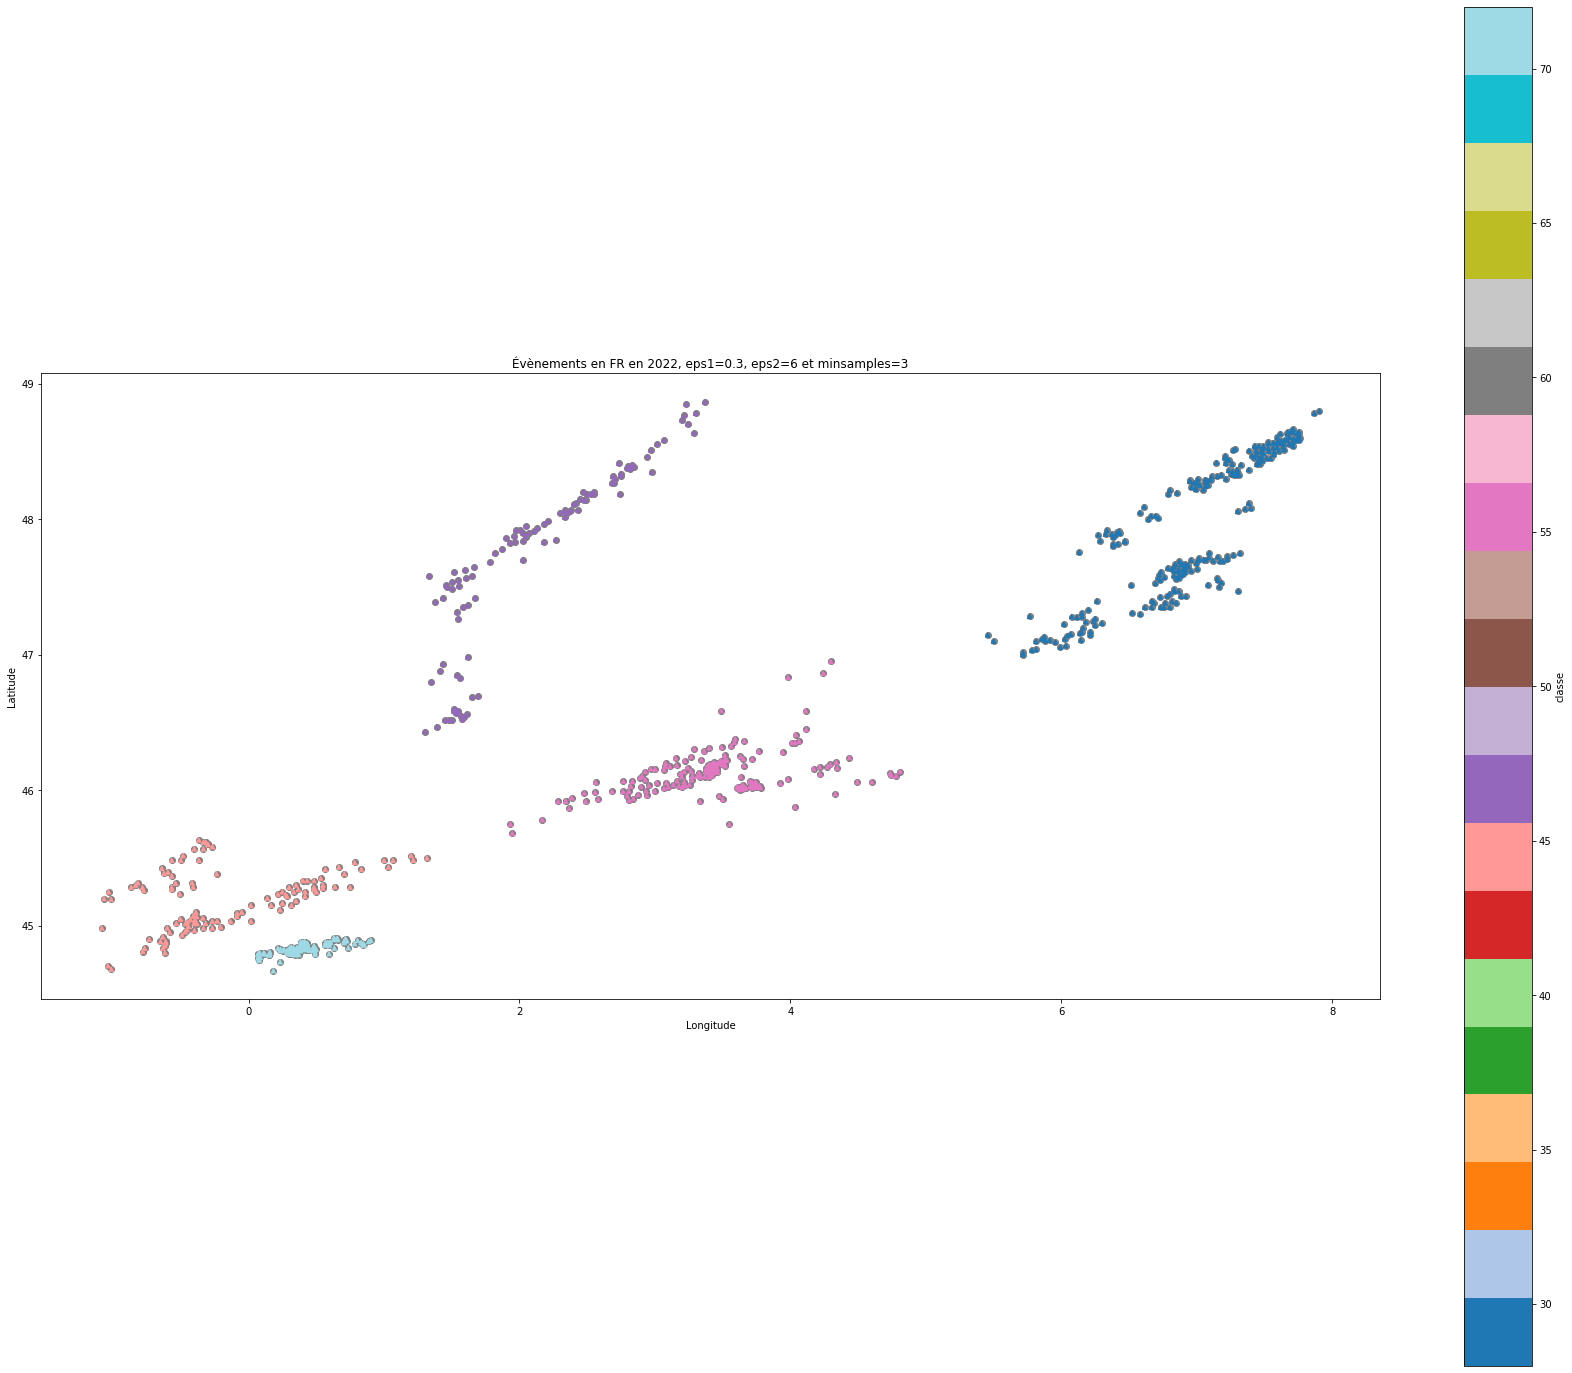

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            182       182        182      182
 0             26        26         26       26
 1             15        15         15       15
 2              6         6          6        6
 3              5         5          5        5
 4              3         3          3        3
 5              3         3          3        3
 6              4         4          4        4
 7             19        19         19       19
 8              3         3          3        3
 9             21        21         21       21
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            11        11         11       11
 15            21        21         21       21
 16            17        17         17       17
 17             4         4          4  

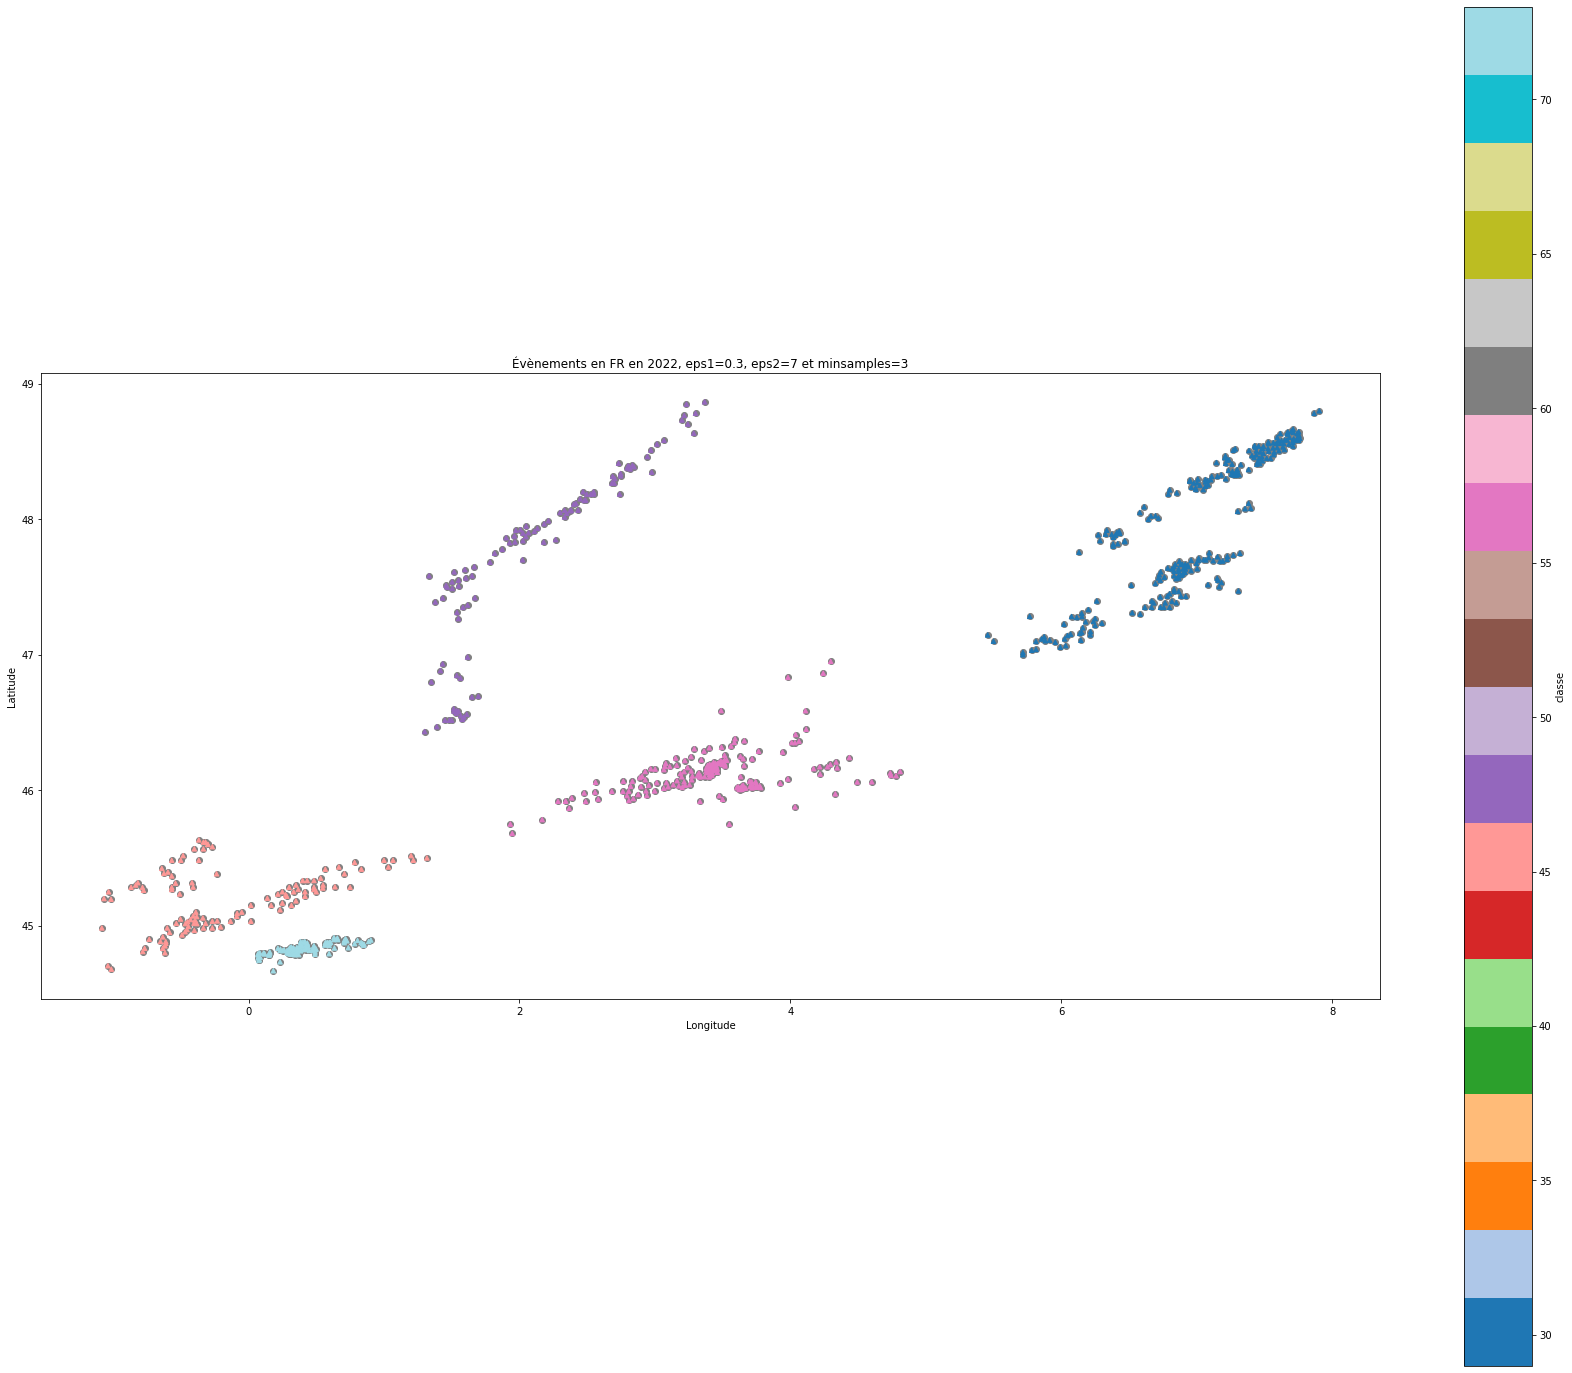

In [ ]:
x="FR"

for i in range(1 ,8 ):
    
    clusterise_country_year(x, 2022, 0.3, i, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            375       375        375      375
 0              6         6          6        6
 1              7         7          7        7
 2              8         8          8        8
 3              5         5          5        5
 4              5         5          5        5
 5              3         3          3        3
 6              4         4          4        4
 7              6         6          6        6
 8              5         5          5        5
 9              3         3          3        3
 10             3         3          3        3
 11            19        19         19       19
 12             3         3          3        3
 13             6         6          6        6
 14             6         6          6        6
 15             3         3          3        3
 16             7         7          7        7
 17             3         3          3  

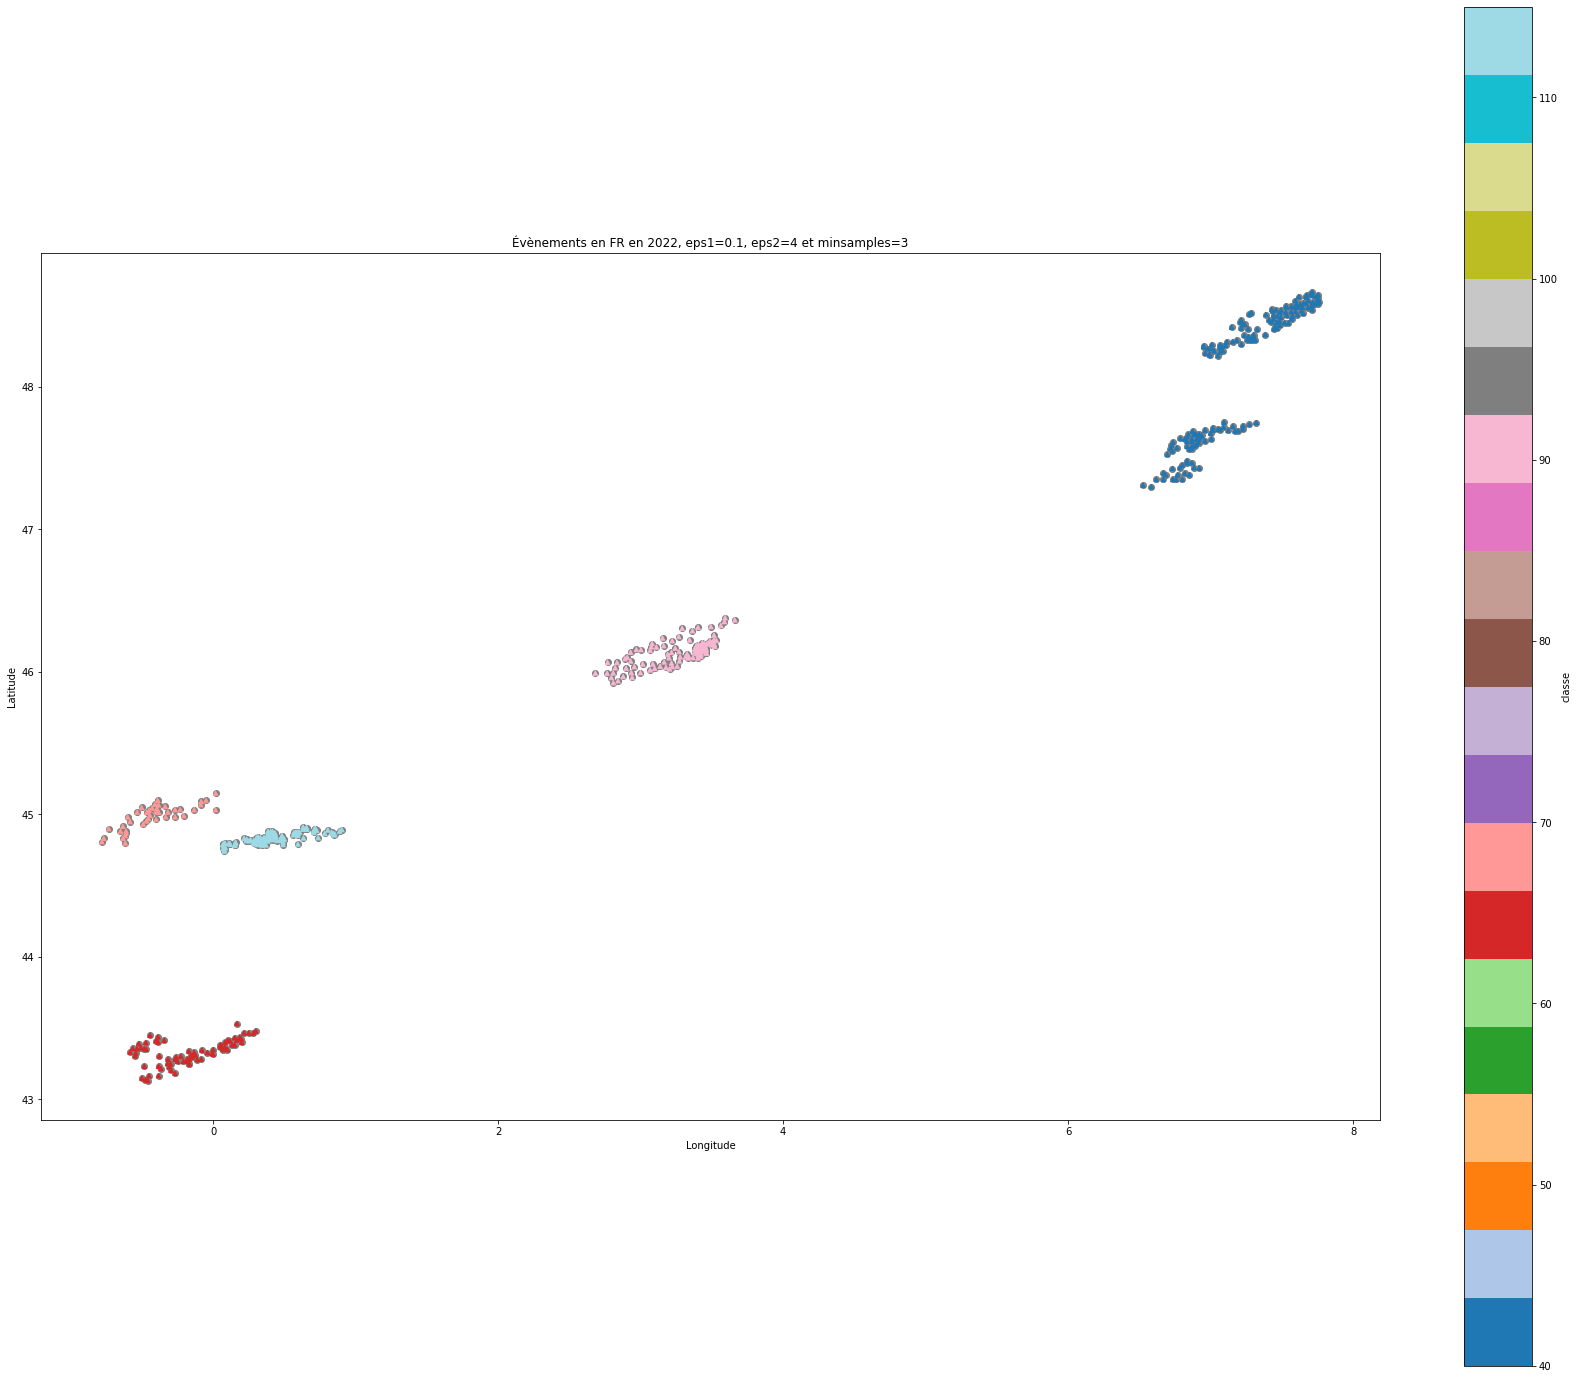

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            249       249        249      249
 0              7         7          7        7
 1              7         7          7        7
 2              8         8          8        8
 3             17        17         17       17
 4              6         6          6        6
 5              5         5          5        5
 6              3         3          3        3
 7              3         3          3        3
 8              4         4          4        4
 9             19        19         19       19
 10             3         3          3        3
 11            19        19         19       19
 12             6         6          6        6
 13             3         3          3        3
 14             3         3          3        3
 15             4         4          4        4
 16            11        11         11       11
 17             4         4          4  

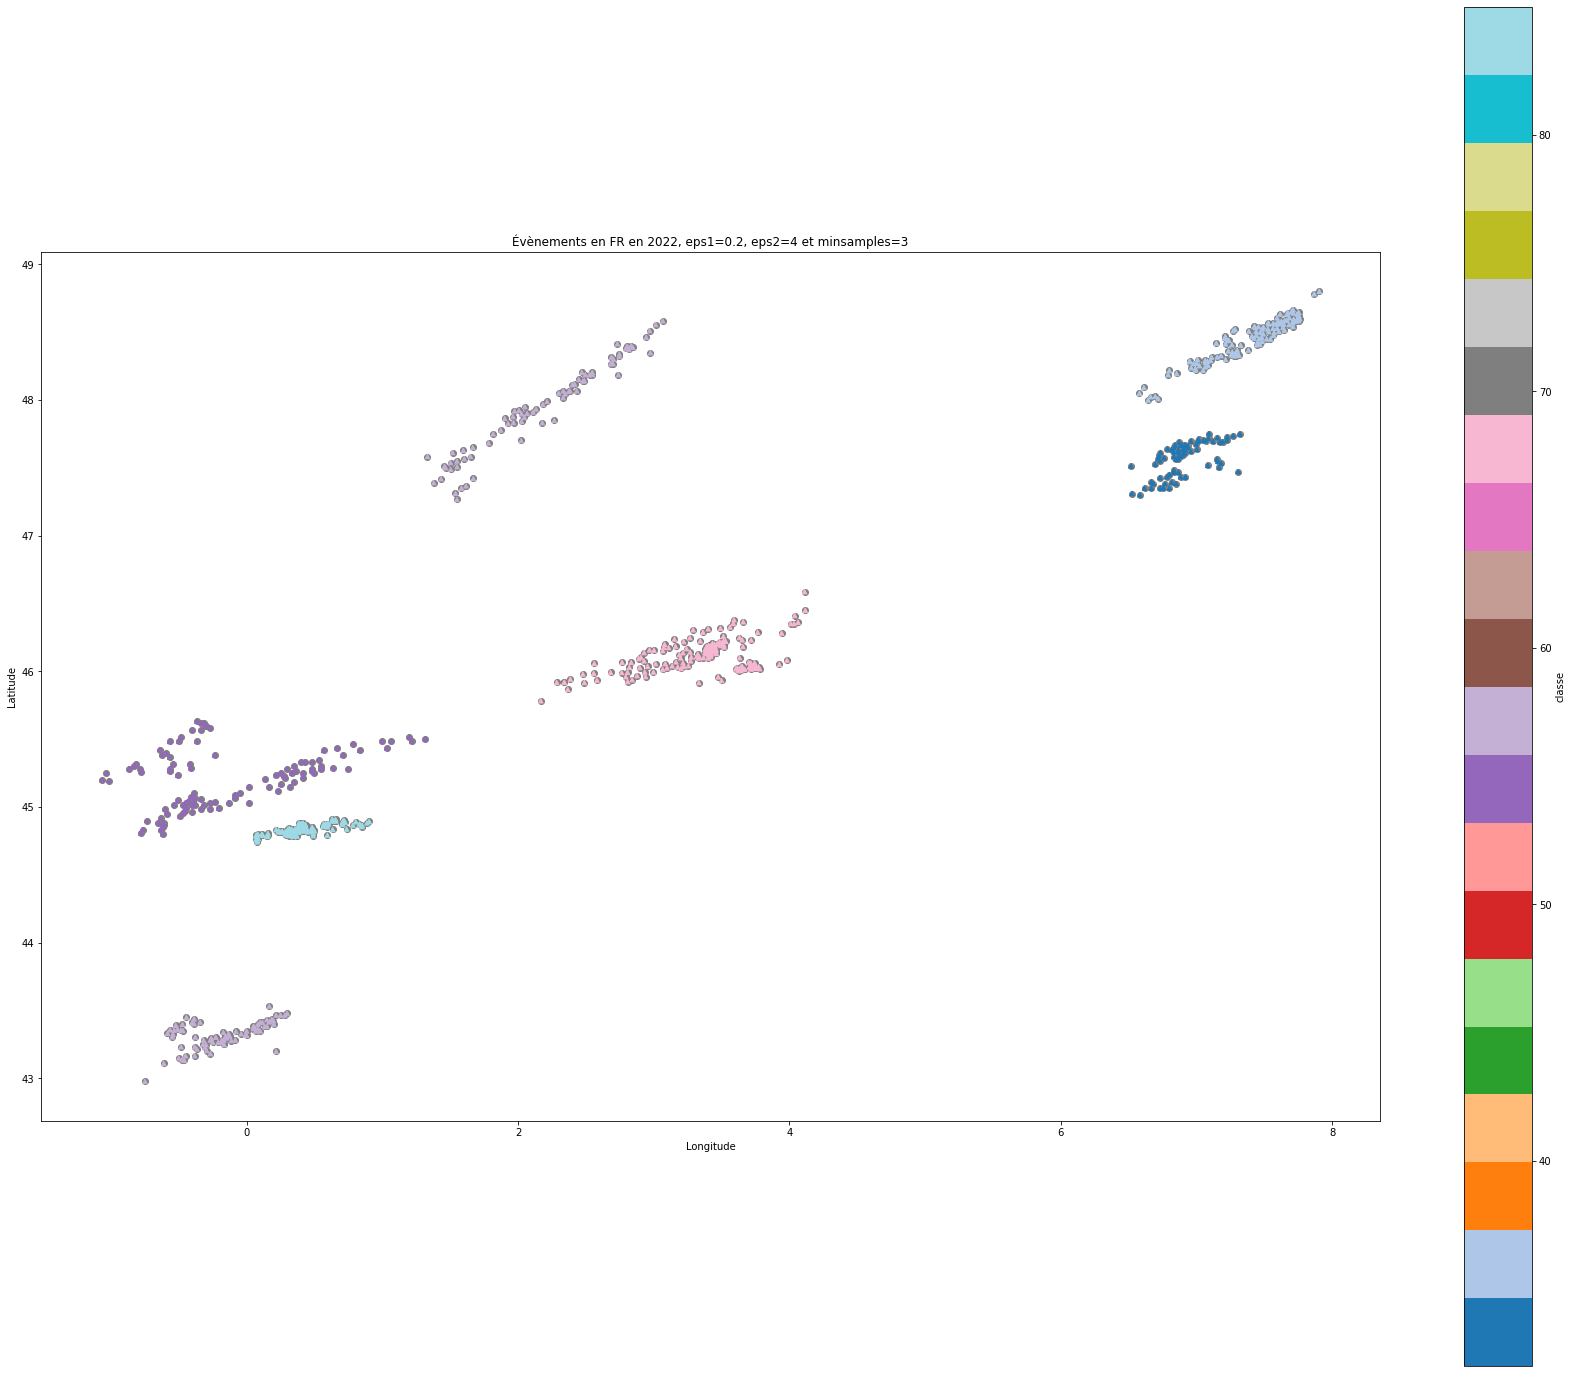

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            185       185        185      185
 0             26        26         26       26
 1             15        15         15       15
 2              6         6          6        6
 3              5         5          5        5
 4              3         3          3        3
 5              3         3          3        3
 6              4         4          4        4
 7             19        19         19       19
 8              3         3          3        3
 9             21        21         21       21
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            11        11         11       11
 15            21        21         21       21
 16            17        17         17       17
 17             4         4          4  

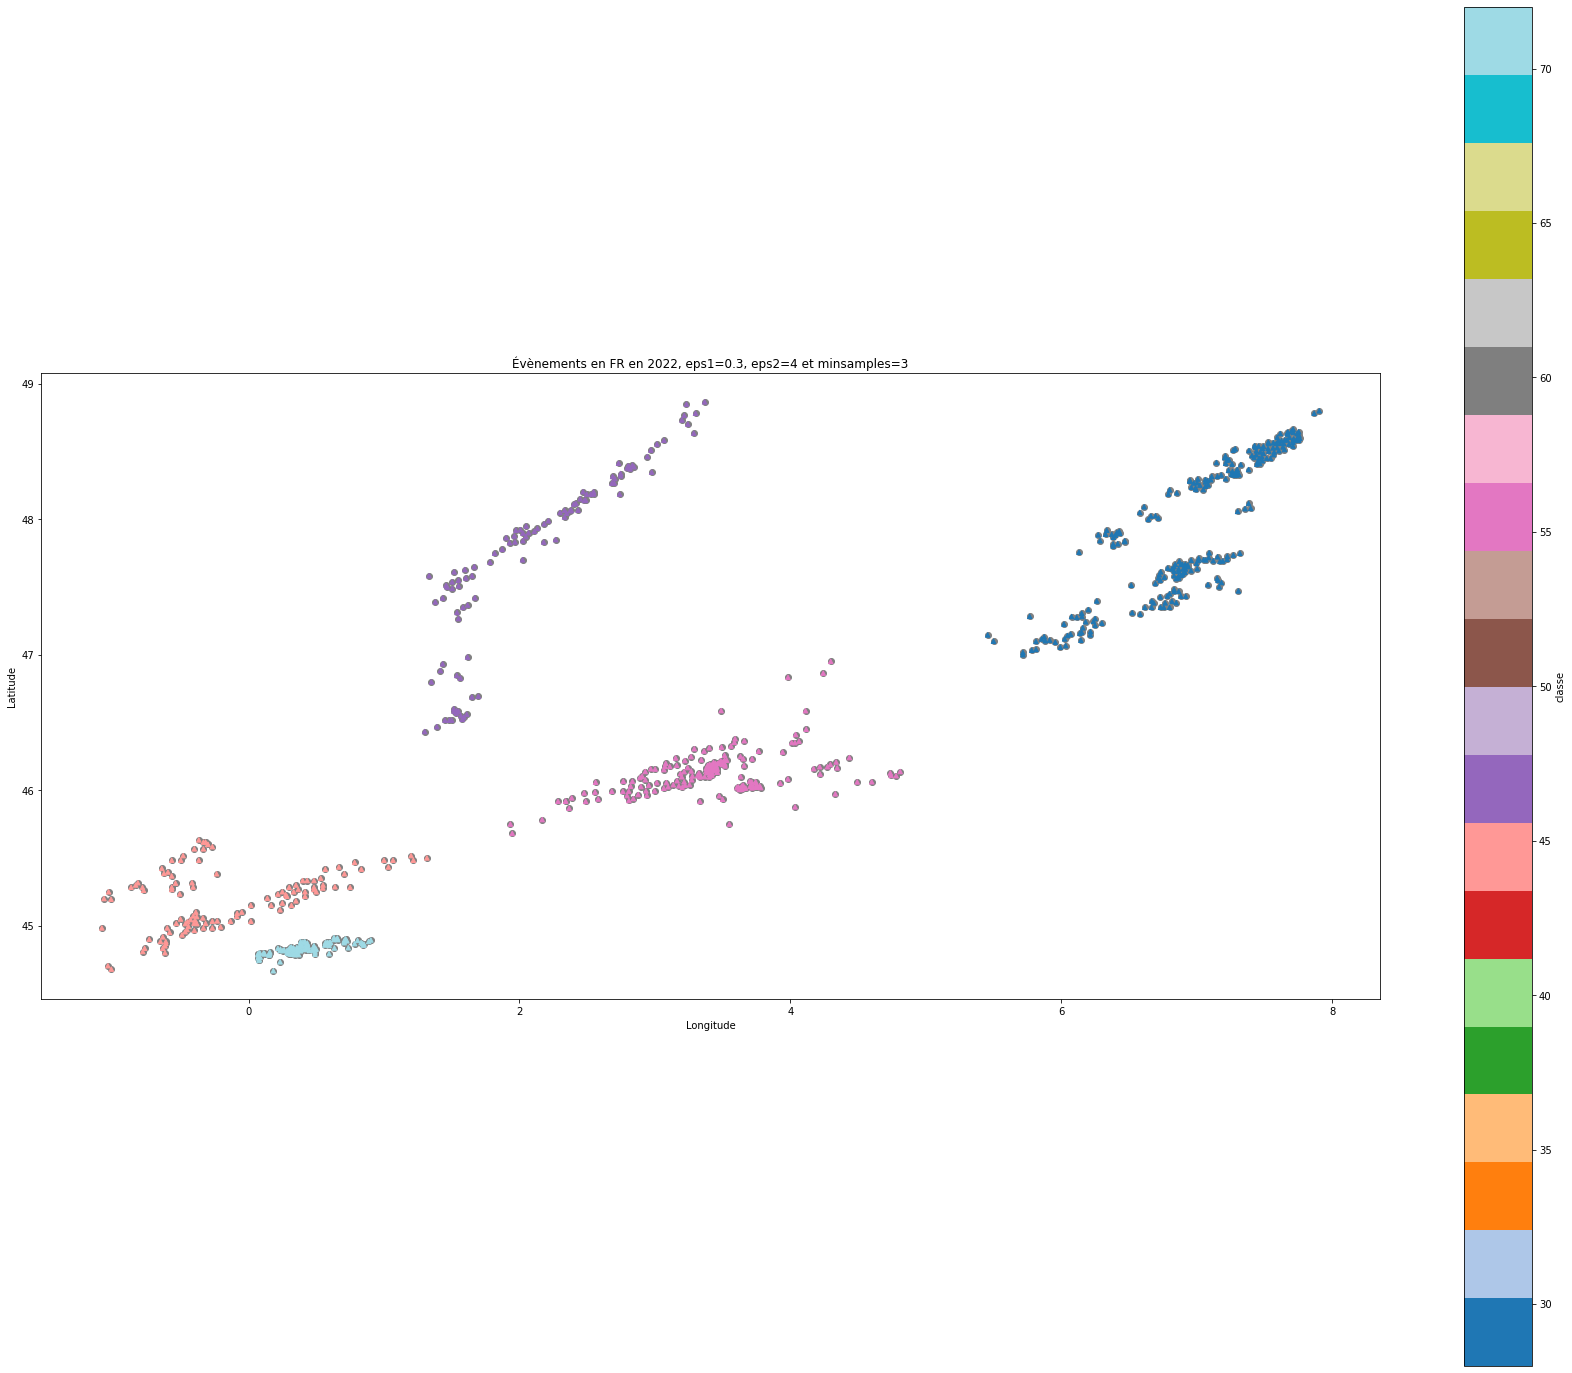

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            153       153        153      153
 0             26        26         26       26
 1             15        15         15       15
 2              6         6          6        6
 3              5         5          5        5
 4              3         3          3        3
 5              3         3          3        3
 6              4         4          4        4
 7             23        23         23       23
 8             19        19         19       19
 9              3         3          3        3
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            11        11         11       11
 15            21        21         21       21
 16            17        17         17       17
 17             4         4          4  

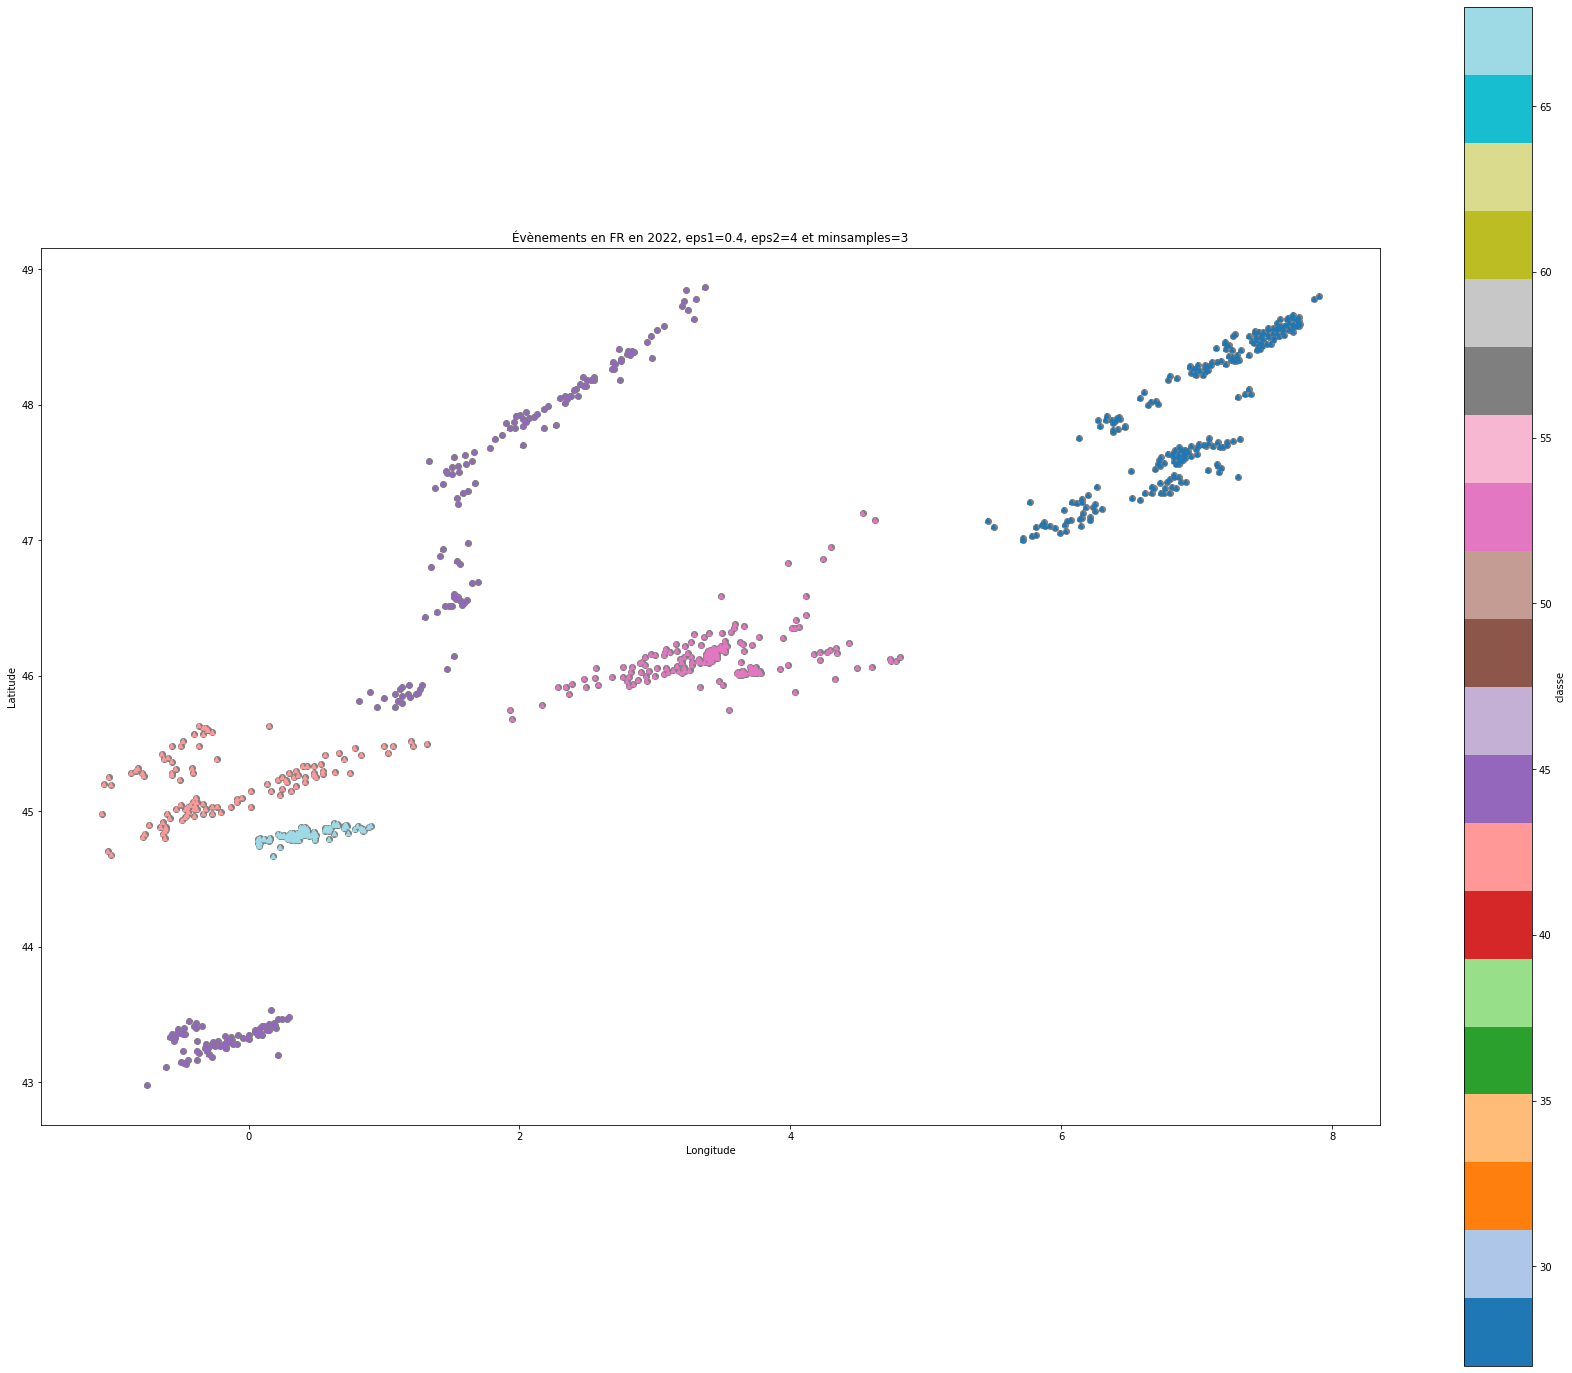

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            121       121        121      121
 0             26        26         26       26
 1             15        15         15       15
 2              8         8          8        8
 3              6         6          6        6
 4              4         4          4        4
 5              3         3          3        3
 6              4         4          4        4
 7              3         3          3        3
 8             23        23         23       23
 9             19        19         19       19
 10             3         3          3        3
 11             6         6          6        6
 12             3         3          3        3
 13             5         5          5        5
 14             5         5          5        5
 15            11        11         11       11
 16            21        21         21       21
 17            17        17         17  

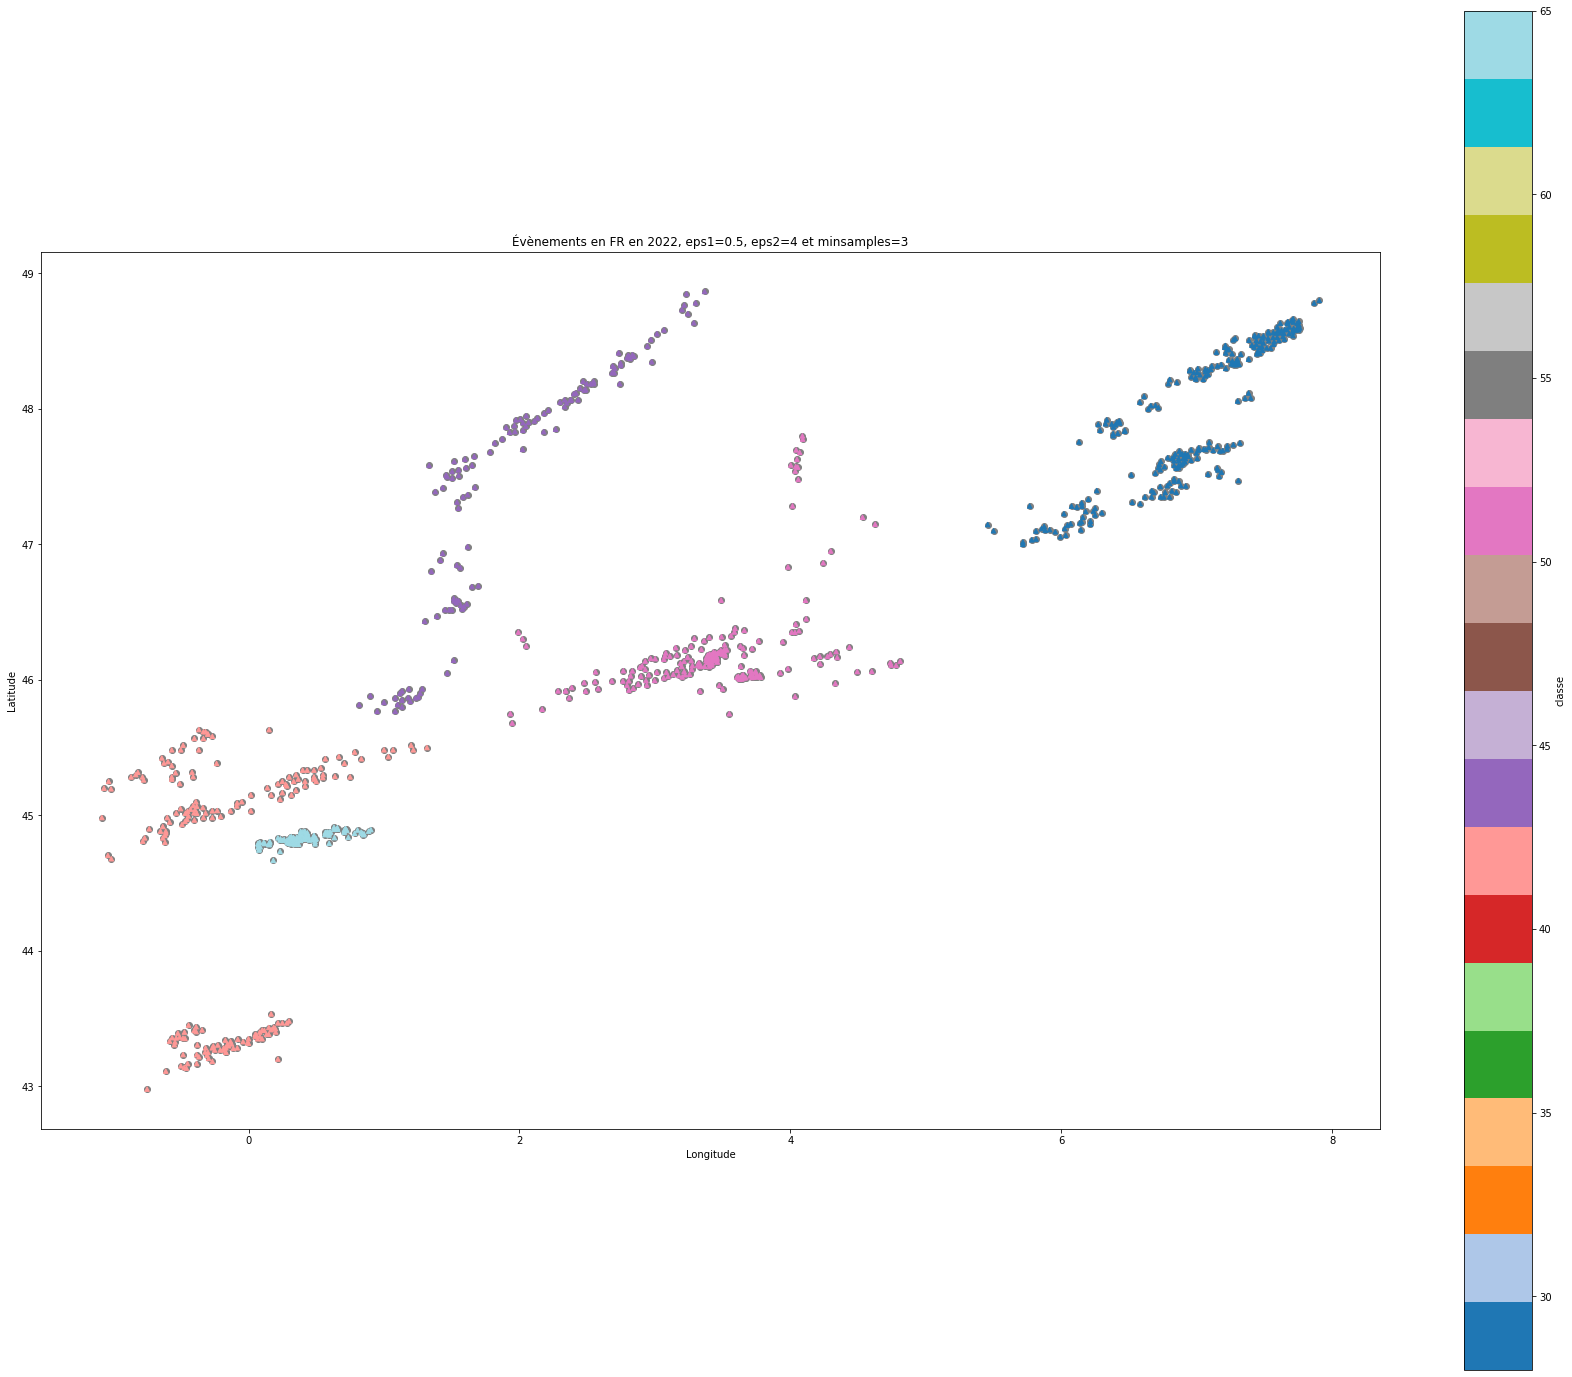

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            107       107        107      107
 0             26        26         26       26
 1             15        15         15       15
 2              8         8          8        8
 3              6         6          6        6
 4              4         4          4        4
 5              3         3          3        3
 6              6         6          6        6
 7              4         4          4        4
 8             26        26         26       26
 9             19        19         19       19
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            12        12         12       12
 15            21        21         21       21
 16            17        17         17       17
 17             4         4          4  

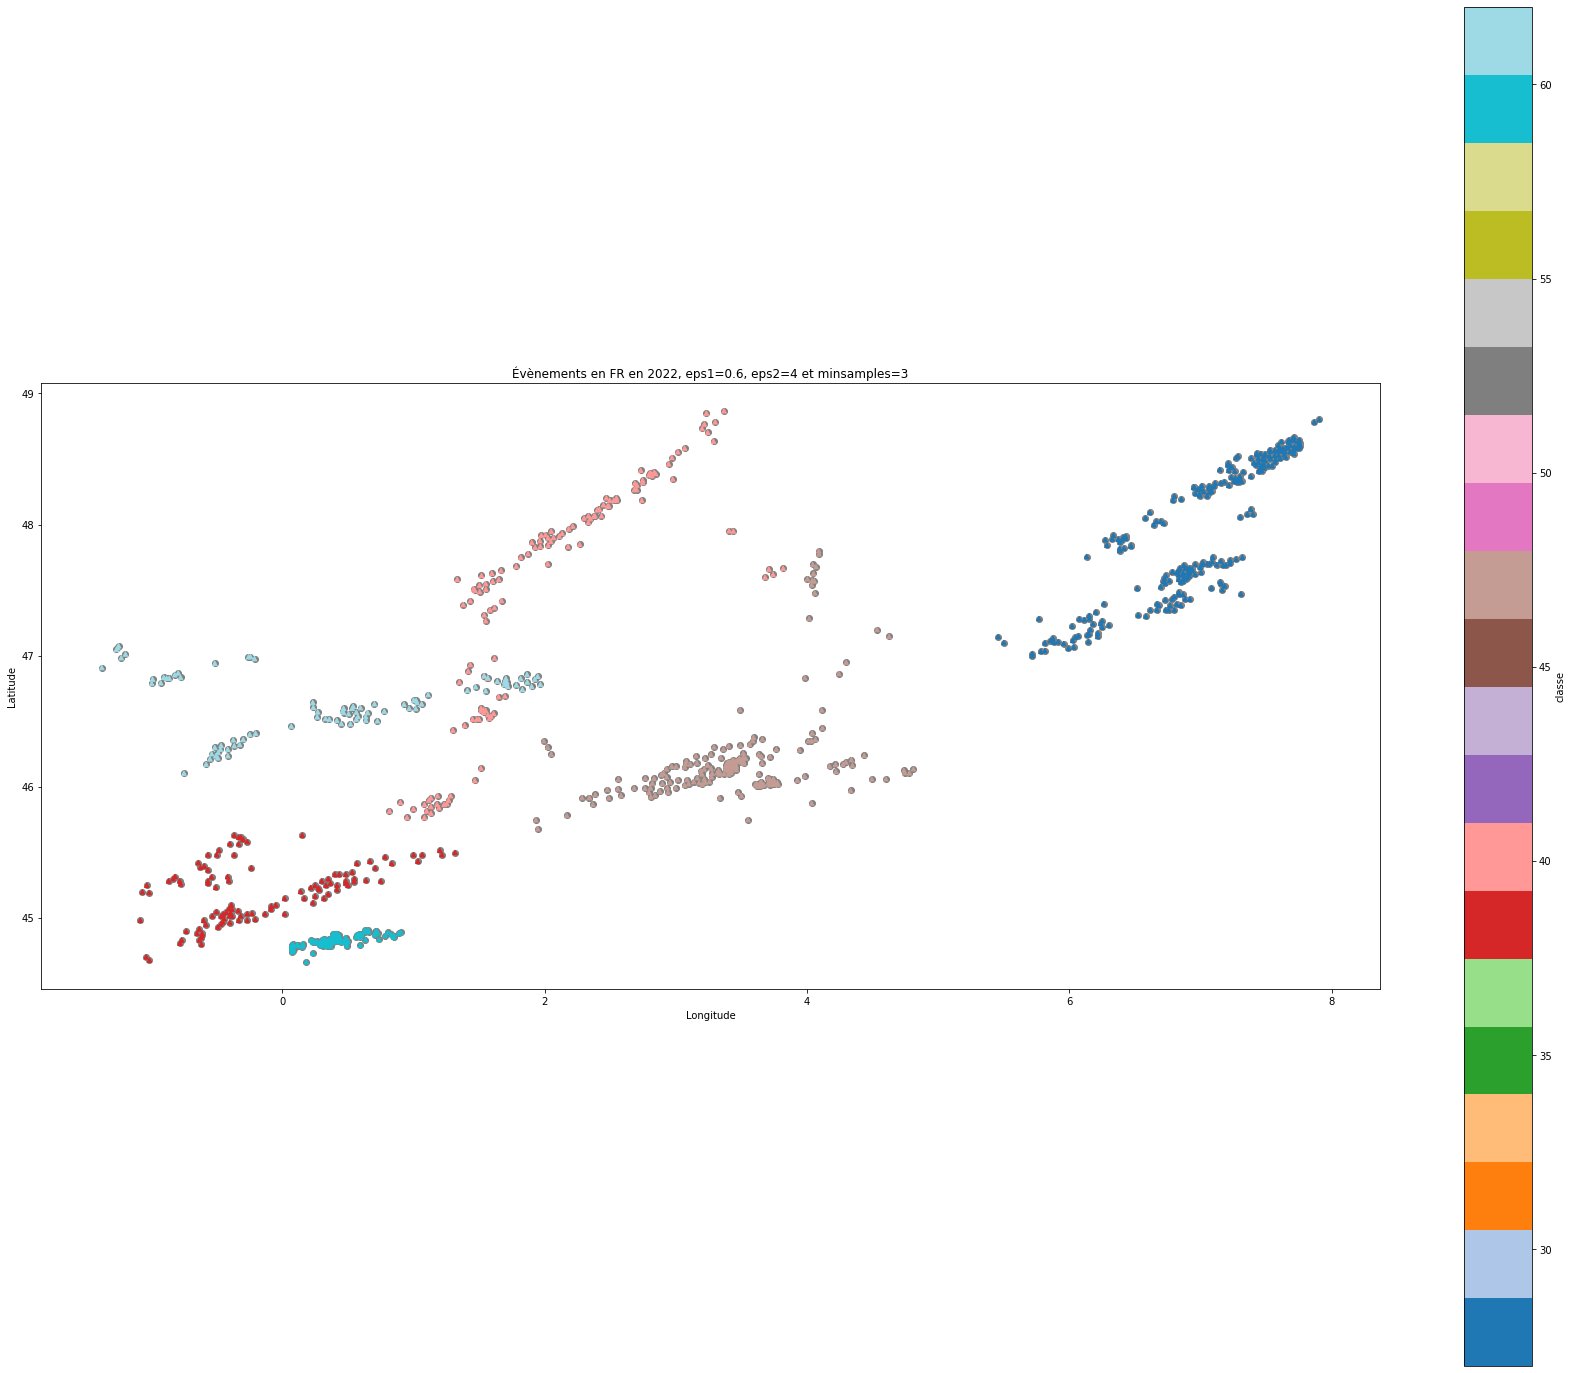

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             97        97         97       97
 0             26        26         26       26
 1             15        15         15       15
 2              8         8          8        8
 3              6         6          6        6
 4              4         4          4        4
 5              3         3          3        3
 6              6         6          6        6
 7              4         4          4        4
 8             26        26         26       26
 9             19        19         19       19
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            12        12         12       12
 15            21        21         21       21
 16            17        17         17       17
 17             4         4          4  

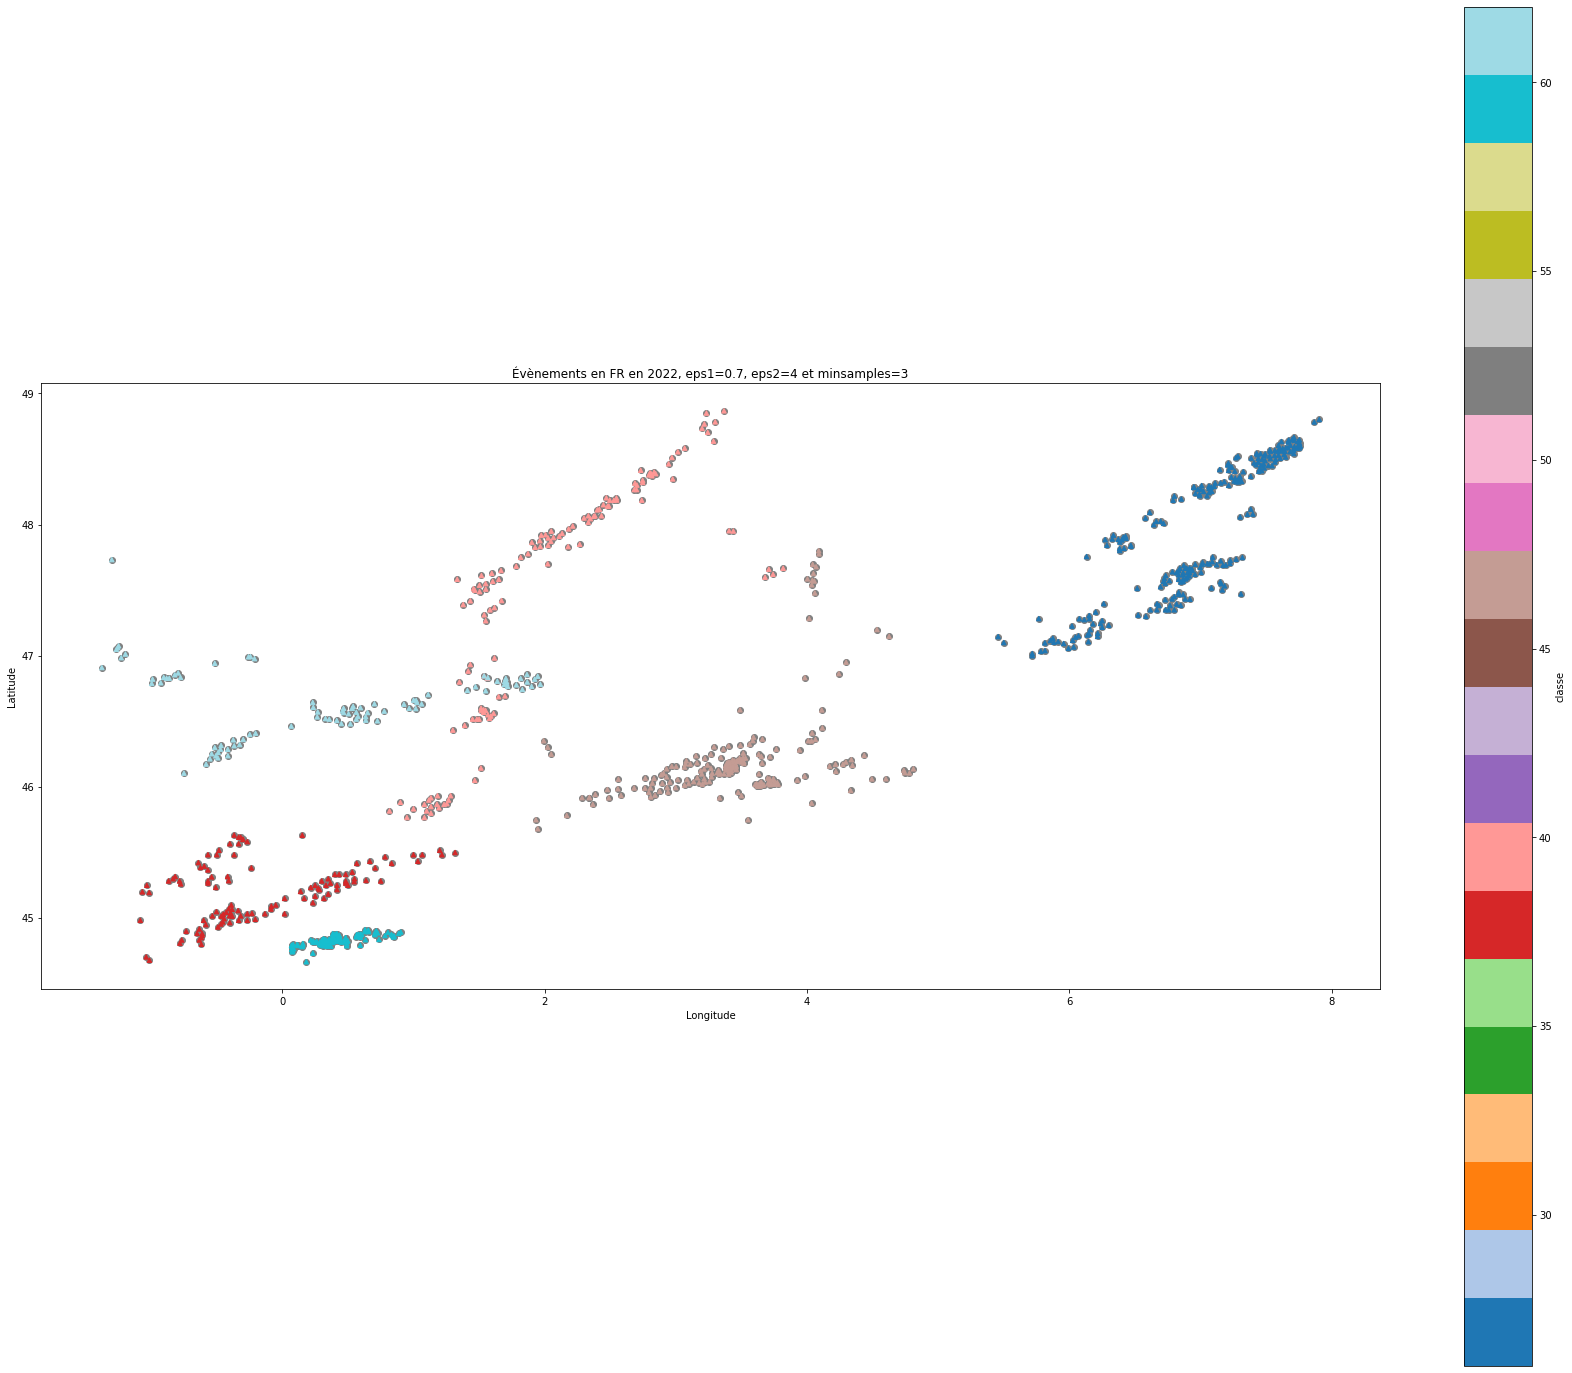

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             88        88         88       88
 0             41        41         41       41
 1              8         8          8        8
 2              6         6          6        6
 3              4         4          4        4
 4              3         3          3        3
 5              6         6          6        6
 6              4         4          4        4
 7             26        26         26       26
 8             19        19         19       19
 9              6         6          6        6
 10             3         3          3        3
 11             5         5          5        5
 12             5         5          5        5
 13            12        12         12       12
 14            21        21         21       21
 15            17        17         17       17
 16             4         4          4        4
 17             4         4          4  

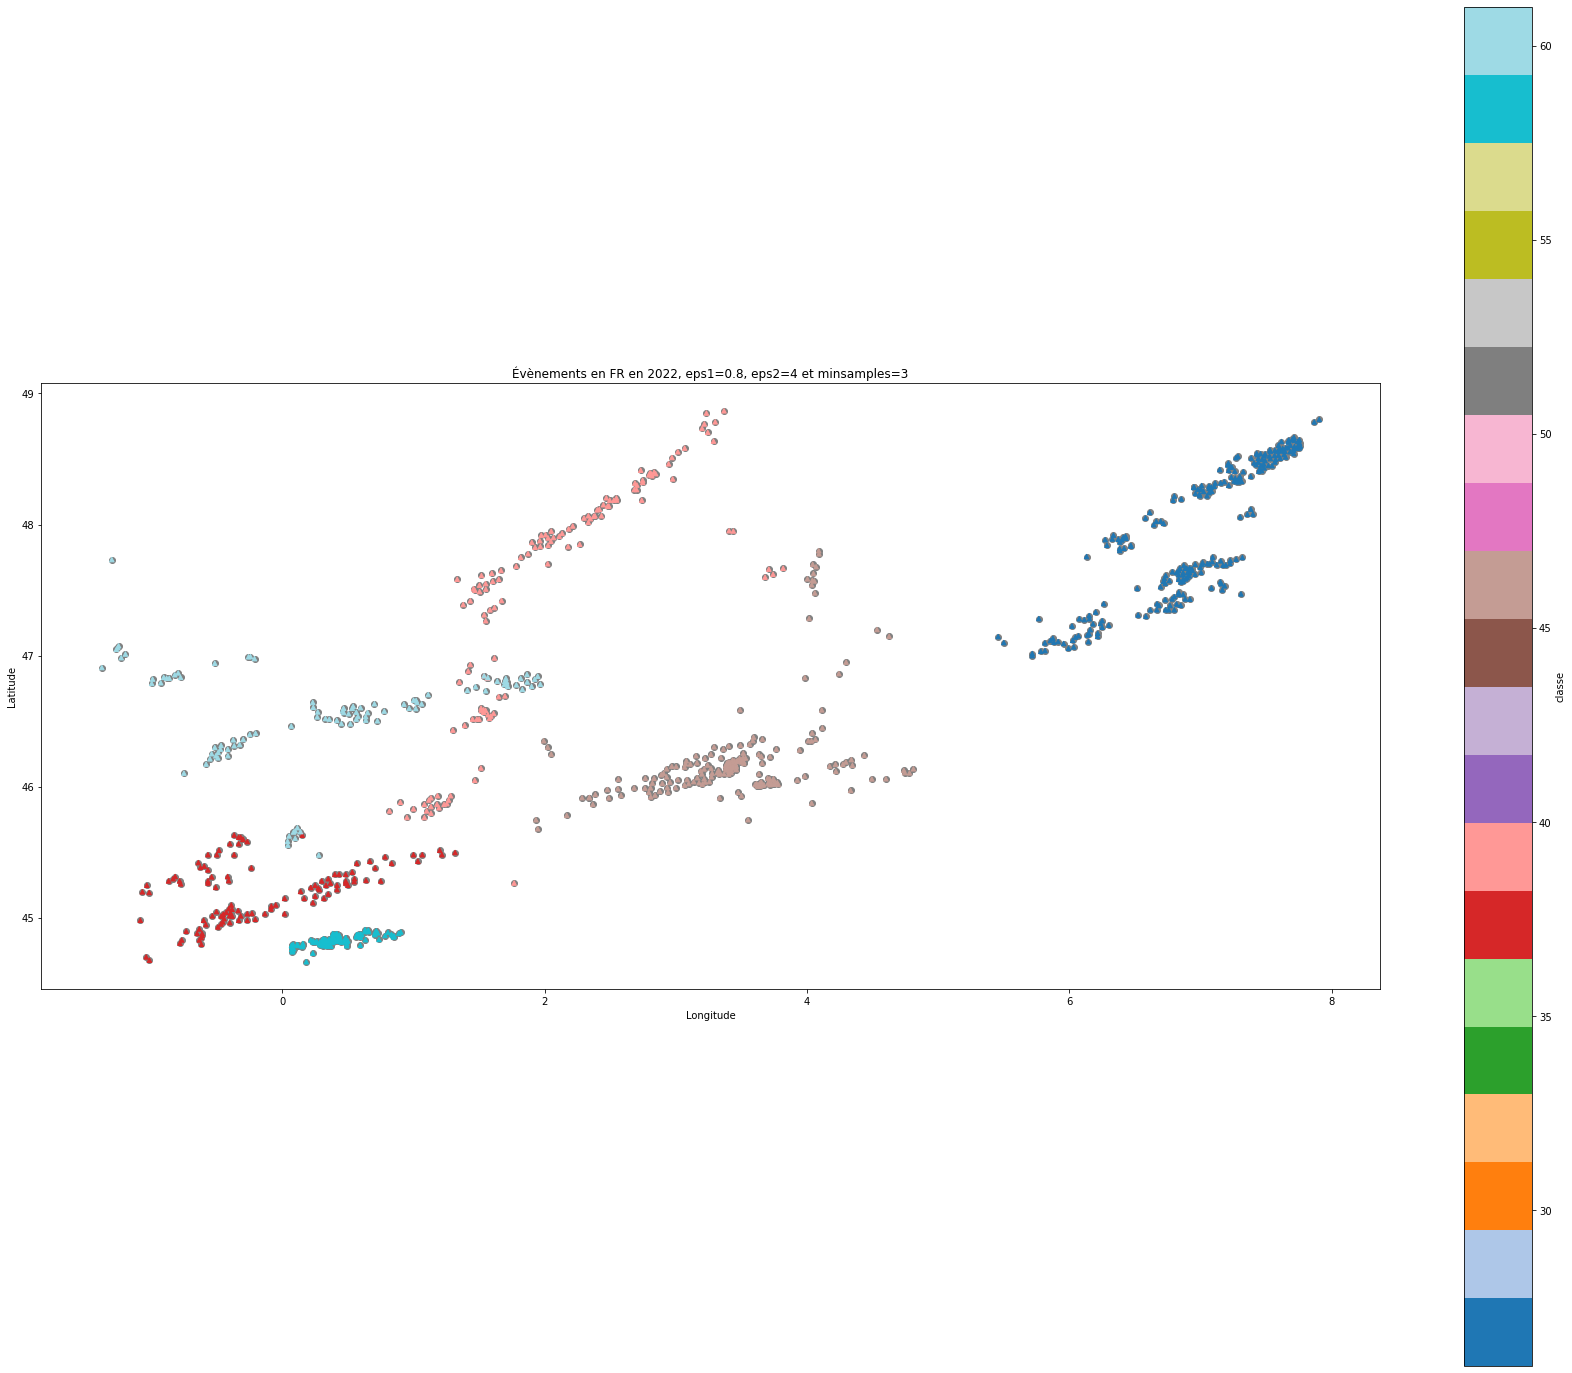

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             79        79         79       79
 0             41        41         41       41
 1              8         8          8        8
 2              6         6          6        6
 3              4         4          4        4
 4              3         3          3        3
 5              6         6          6        6
 6              4         4          4        4
 7             27        27         27       27
 8             19        19         19       19
 9              6         6          6        6
 10             3         3          3        3
 11             5         5          5        5
 12             7         7          7        7
 13            12        12         12       12
 14            21        21         21       21
 15            18        18         18       18
 16             4         4          4        4
 17             4         4          4  

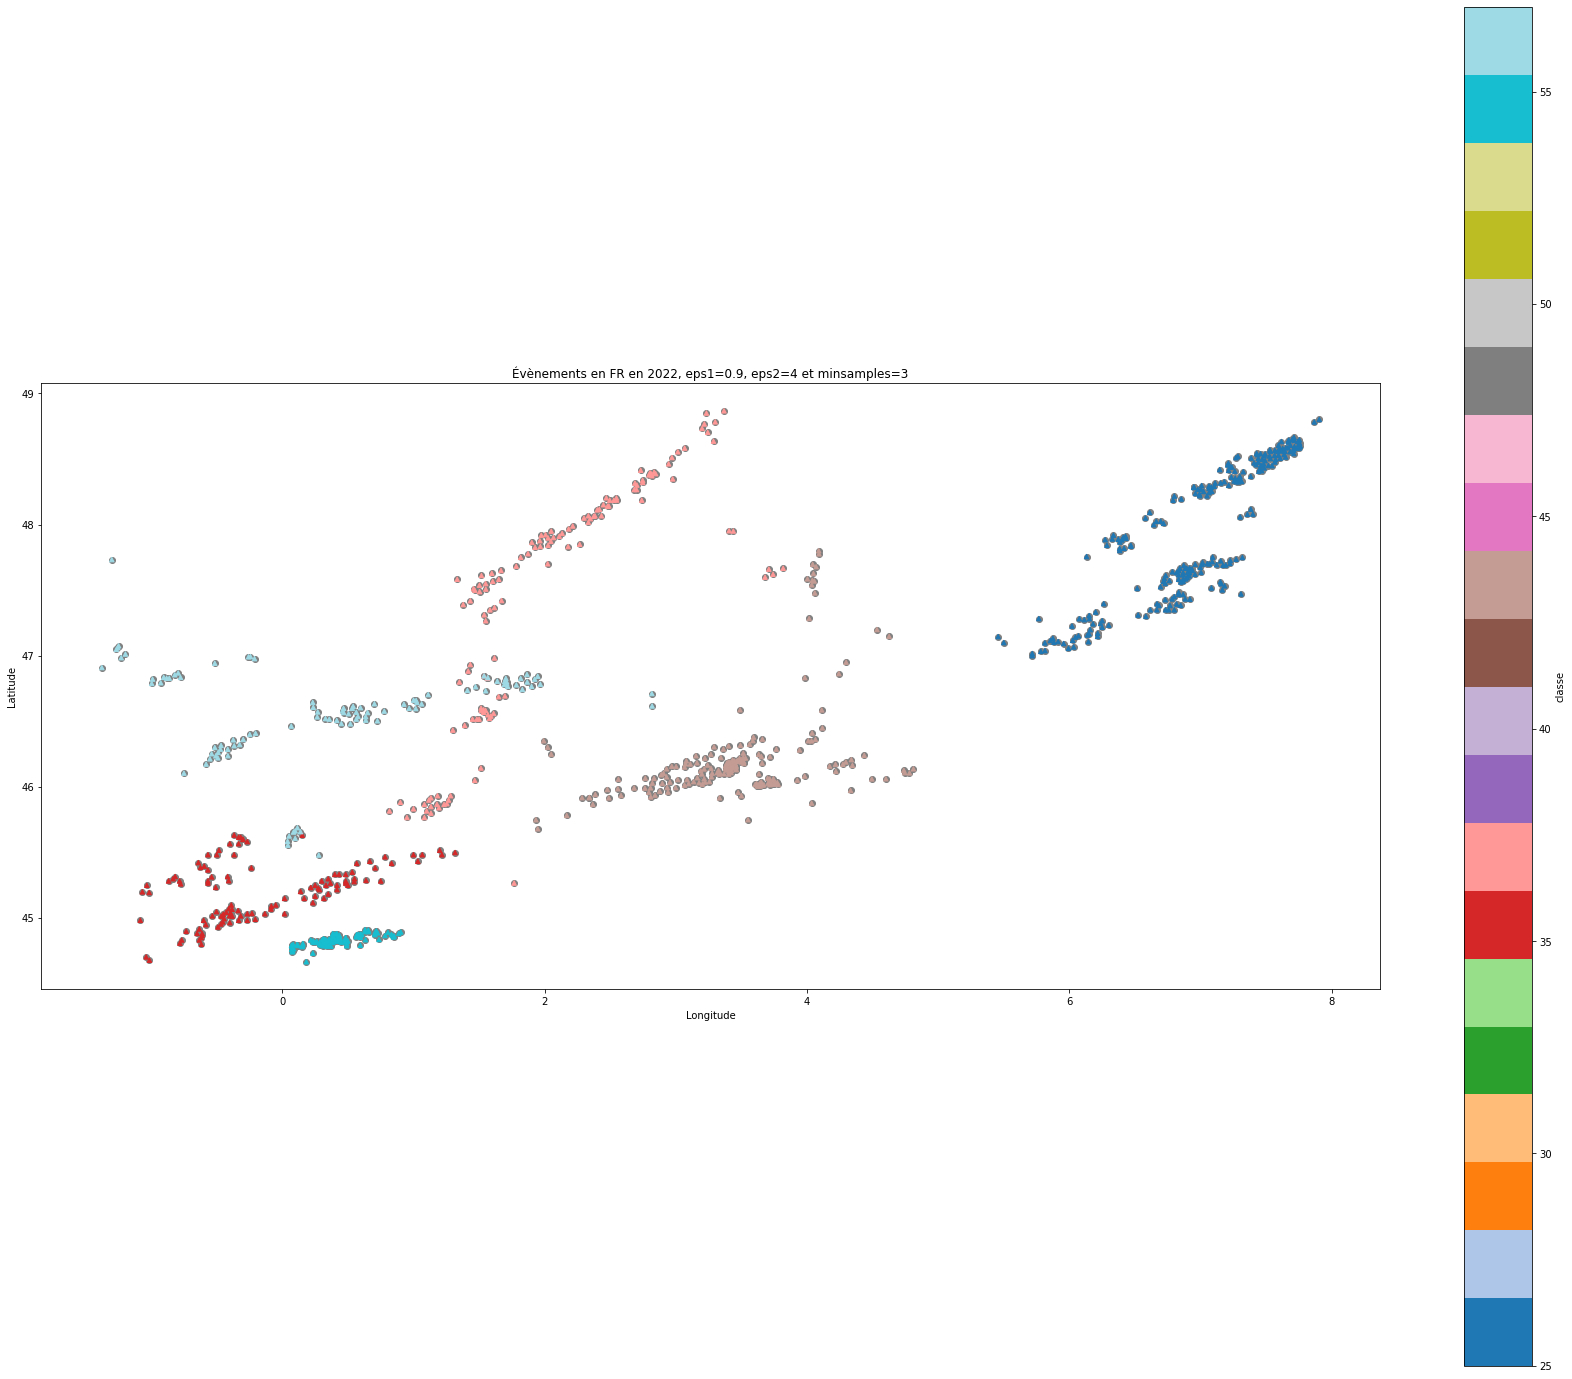

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             74        74         74       74
 0             41        41         41       41
 1              8         8          8        8
 2              6         6          6        6
 3              4         4          4        4
 4              3         3          3        3
 5              6         6          6        6
 6              4         4          4        4
 7             27        27         27       27
 8             19        19         19       19
 9              6         6          6        6
 10             3         3          3        3
 11             6         6          6        6
 12             7         7          7        7
 13            13        13         13       13
 14            21        21         21       21
 15            18        18         18       18
 16             4         4          4        4
 17             4         4          4  

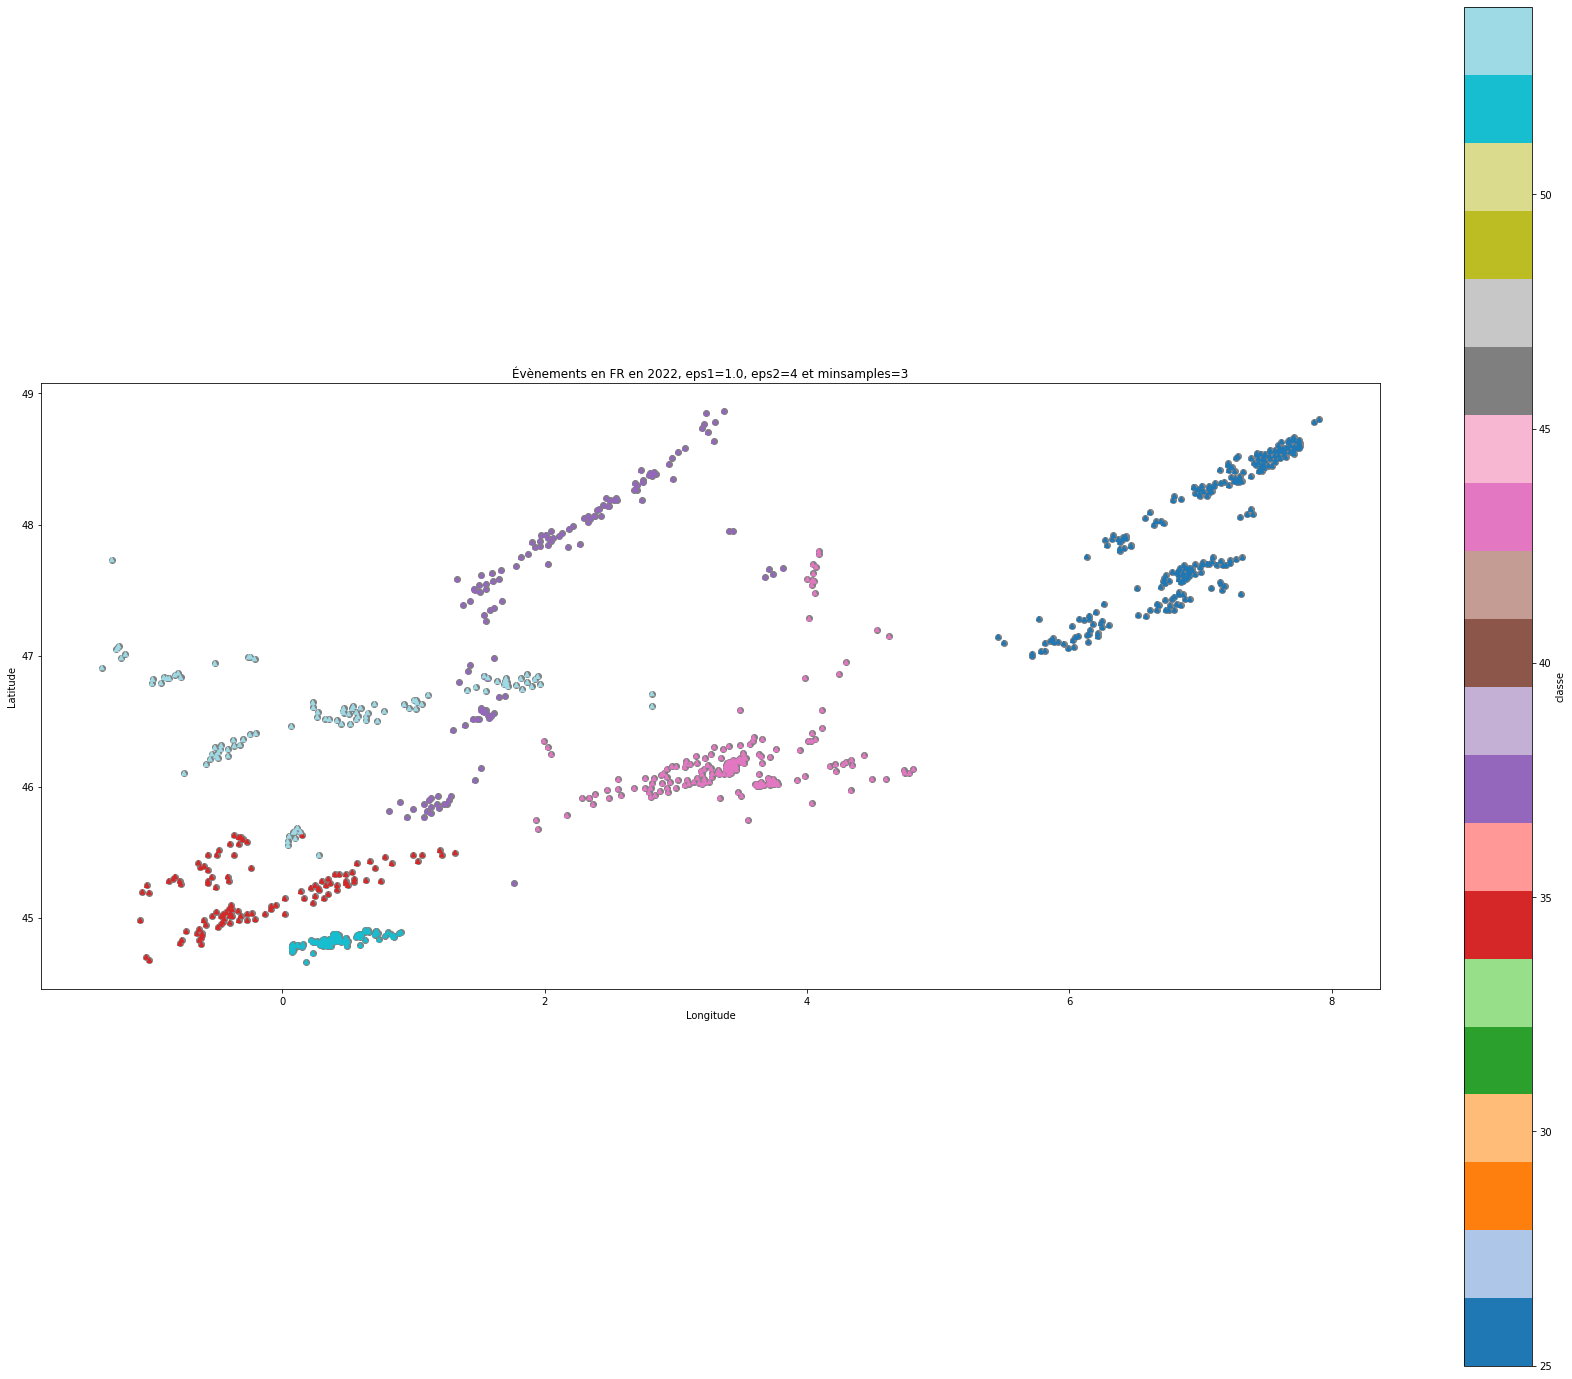

In [ ]:
x="FR"

for i in range(1,11,1):
    y=i/10
    
    clusterise_country_year(x, 2022, y, 4, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             83        83         83       83
 0              2         2          2        2
 1             26        26         26       26
 2             15        15         15       15
 3              6         6          6        6
 4              2         2          2        2
 5              5         5          5        5
 6              3         3          3        3
 7              3         3          3        3
 8              2         2          2        2
 9              4         4          4        4
 10             2         2          2        2
 11            23        23         23       23
 12            19        19         19       19
 13             3         3          3        3
 14             6         6          6        6
 15             2         2          2        2
 16             3         3          3        3
 17             2         2          2  

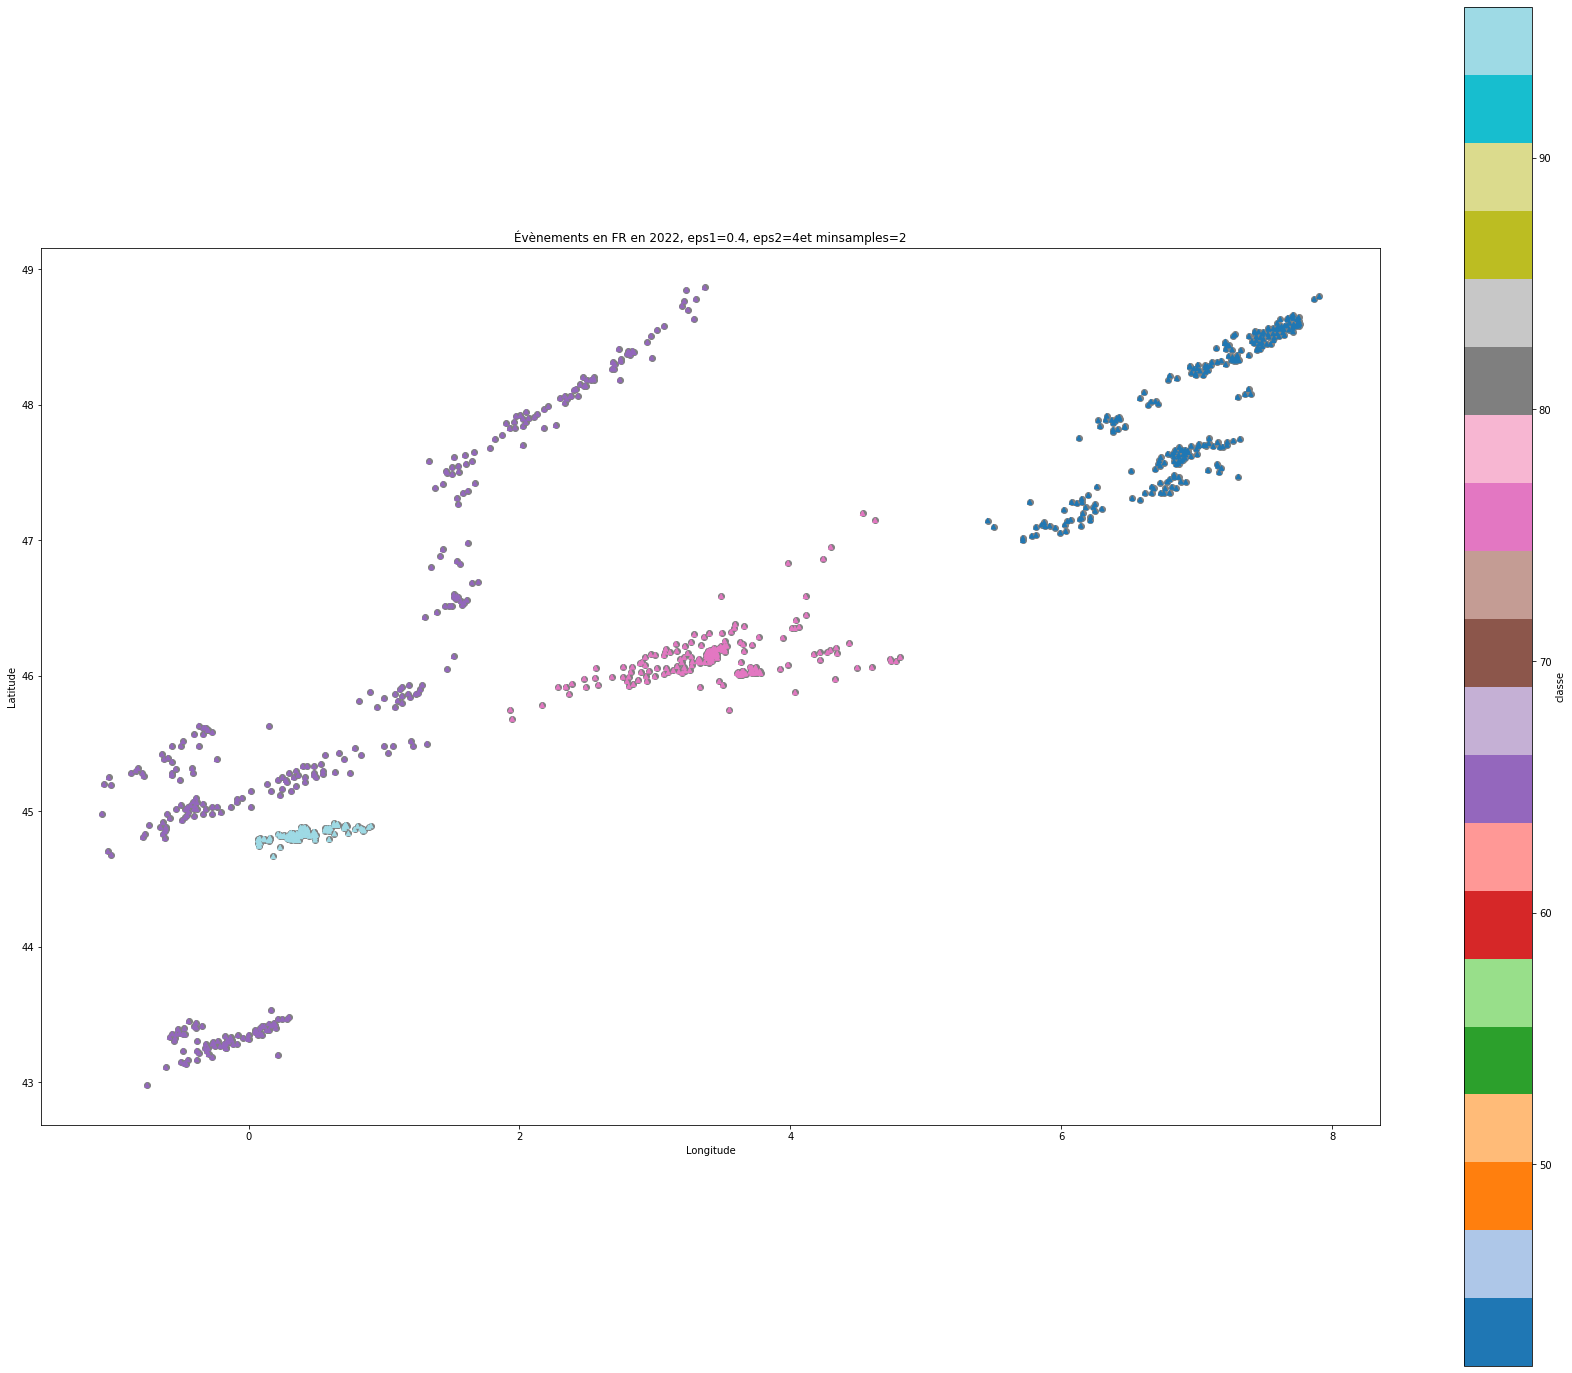

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            153       153        153      153
 0             26        26         26       26
 1             15        15         15       15
 2              6         6          6        6
 3              5         5          5        5
 4              3         3          3        3
 5              3         3          3        3
 6              4         4          4        4
 7             23        23         23       23
 8             19        19         19       19
 9              3         3          3        3
 10             6         6          6        6
 11             3         3          3        3
 12             5         5          5        5
 13             5         5          5        5
 14            11        11         11       11
 15            21        21         21       21
 16            17        17         17       17
 17             4         4          4  

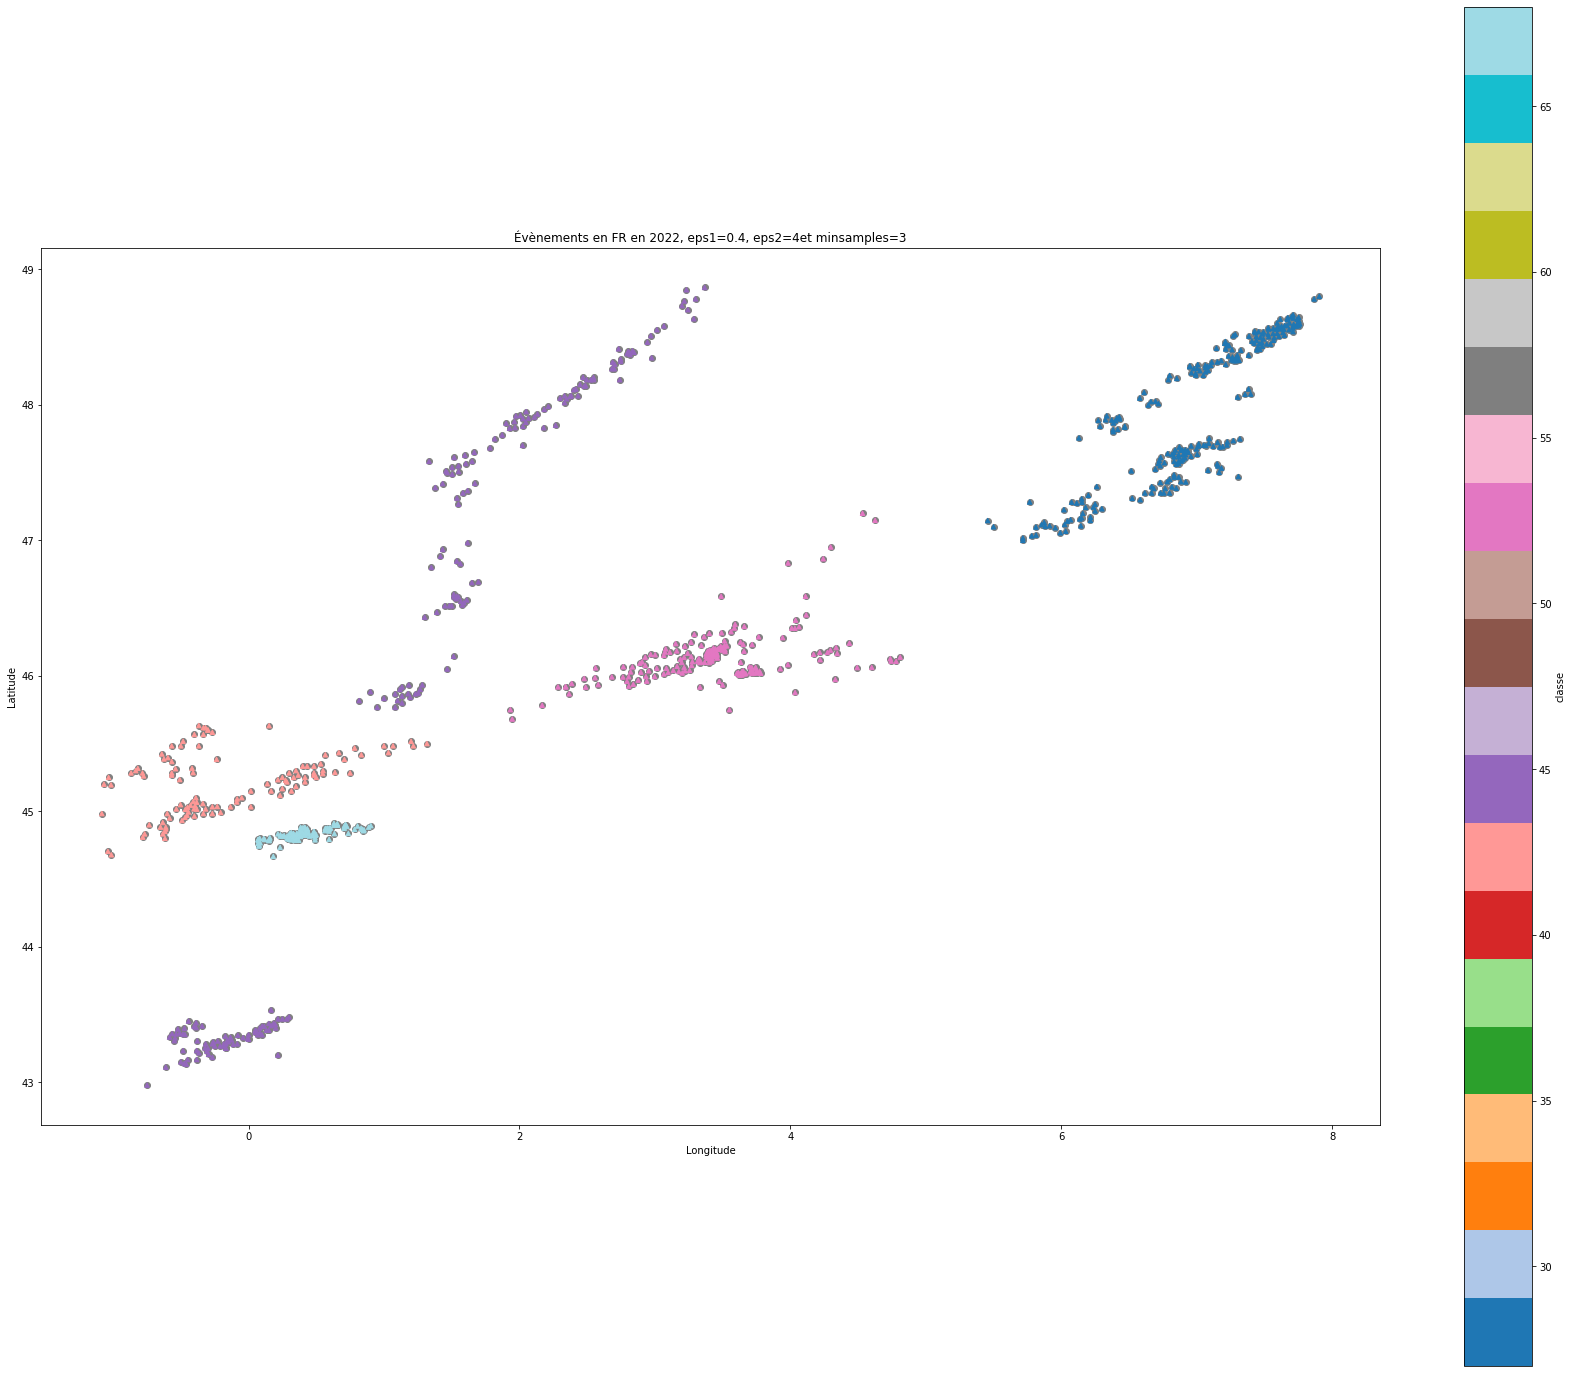

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            198       198        198      198
 0             26        26         26       26
 1             15        15         15       15
 2              6         6          6        6
 3              5         5          5        5
 4              4         4          4        4
 5             23        23         23       23
 6             19        19         19       19
 7              6         6          6        6
 8              5         5          5        5
 9              5         5          5        5
 10            11        11         11       11
 11            21        21         21       21
 12            17        17         17       17
 13             4         4          4        4
 14            15        15         15       15
 15            67        67         67       67
 16             8         8          8        8
 17             7         7          7  

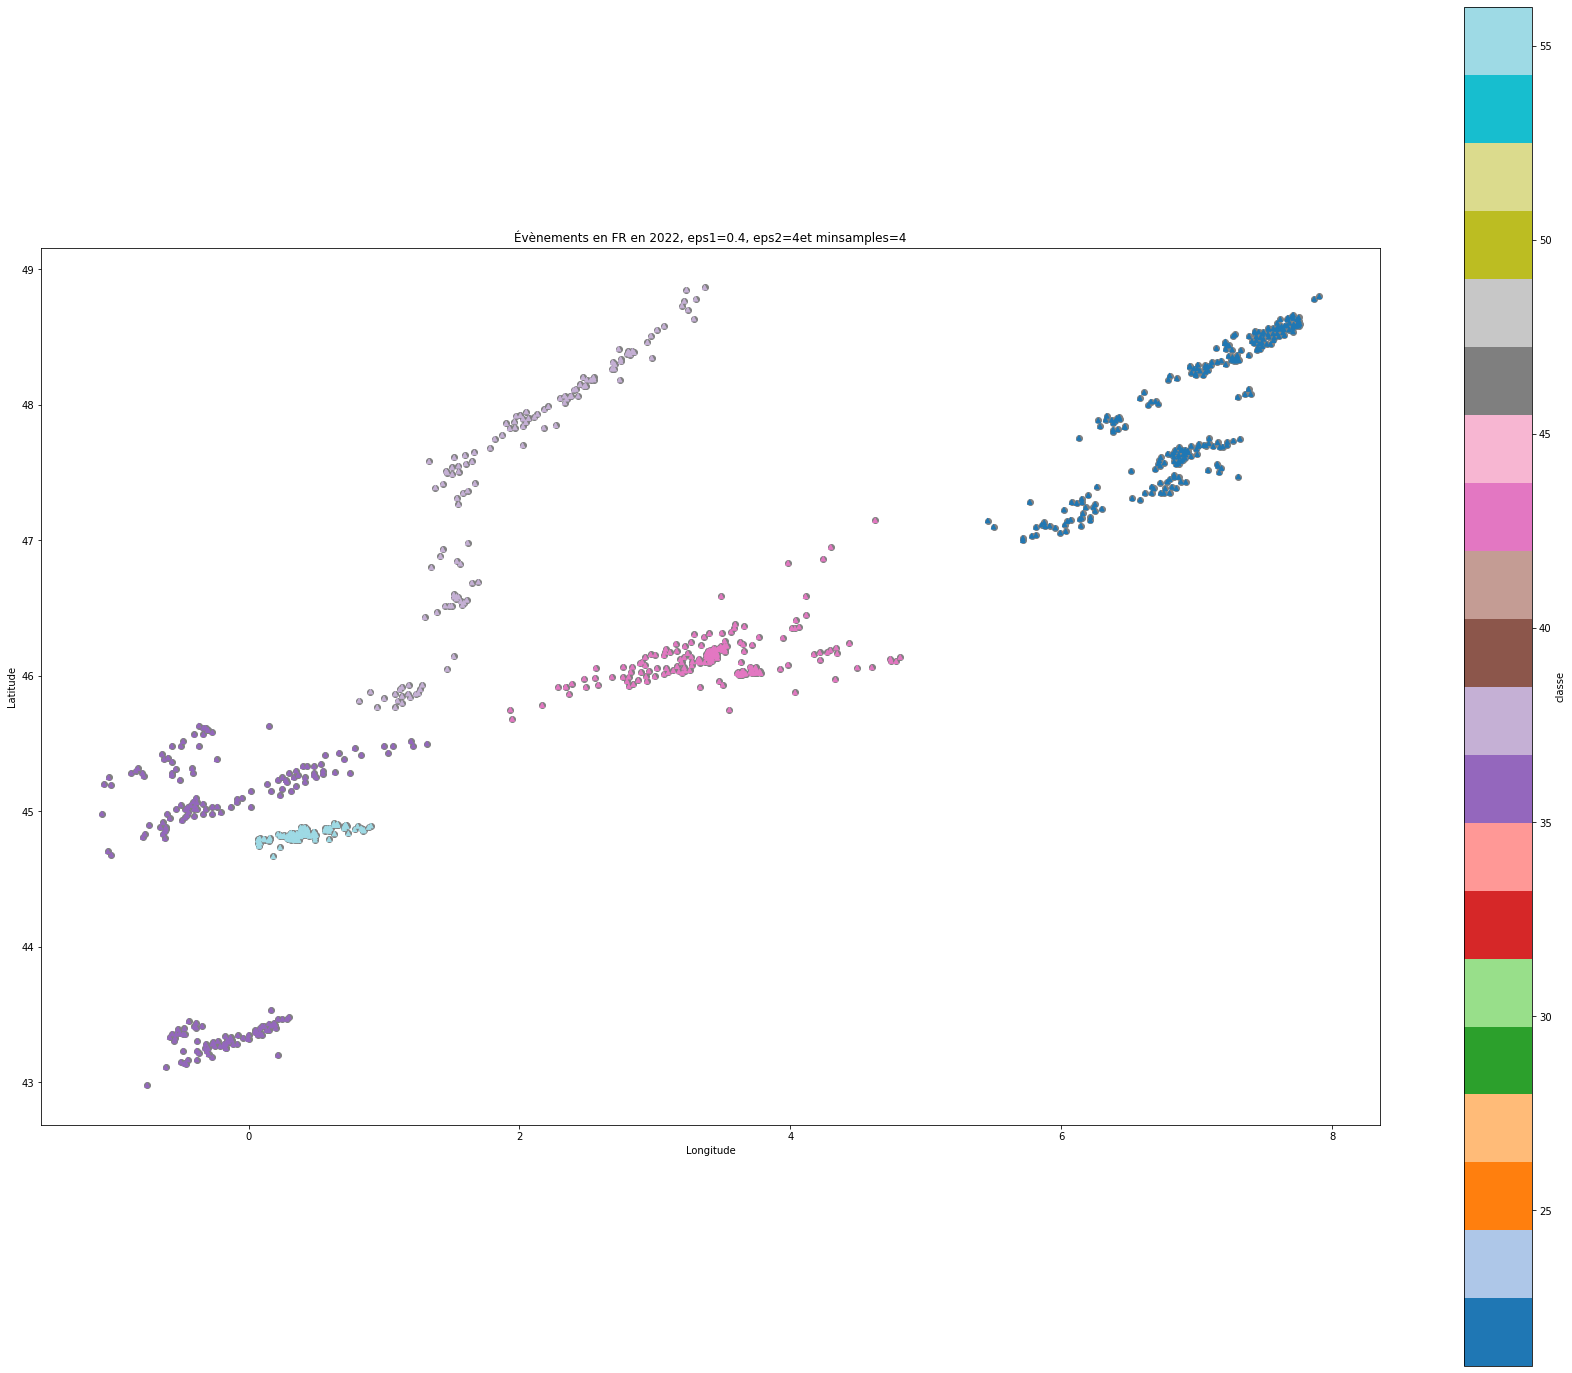

In [ ]:
x="FR"

for i in range(2,5):    
    clusterise_country_year(x, 2022,0.4, 4,i)

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            897       897        897      897
 0              5         5          5        5
 1              6         6          6        6
 2              3         3          3        3
 3              6         6          6        6
 4              5         5          5        5
 5              6         6          6        6
 6              3         3          3        3
 7              6         6          6        6
 8              4         4          4        4
 9              5         5          5        5
 10             3         3          3        3
 11             3         3          3        3
 12             5         5          5        5
 13             3         3          3        3
 14             6         6          6        6
 15             3         3          3        3
 16             9         9          9        9
 17             3         3          3  

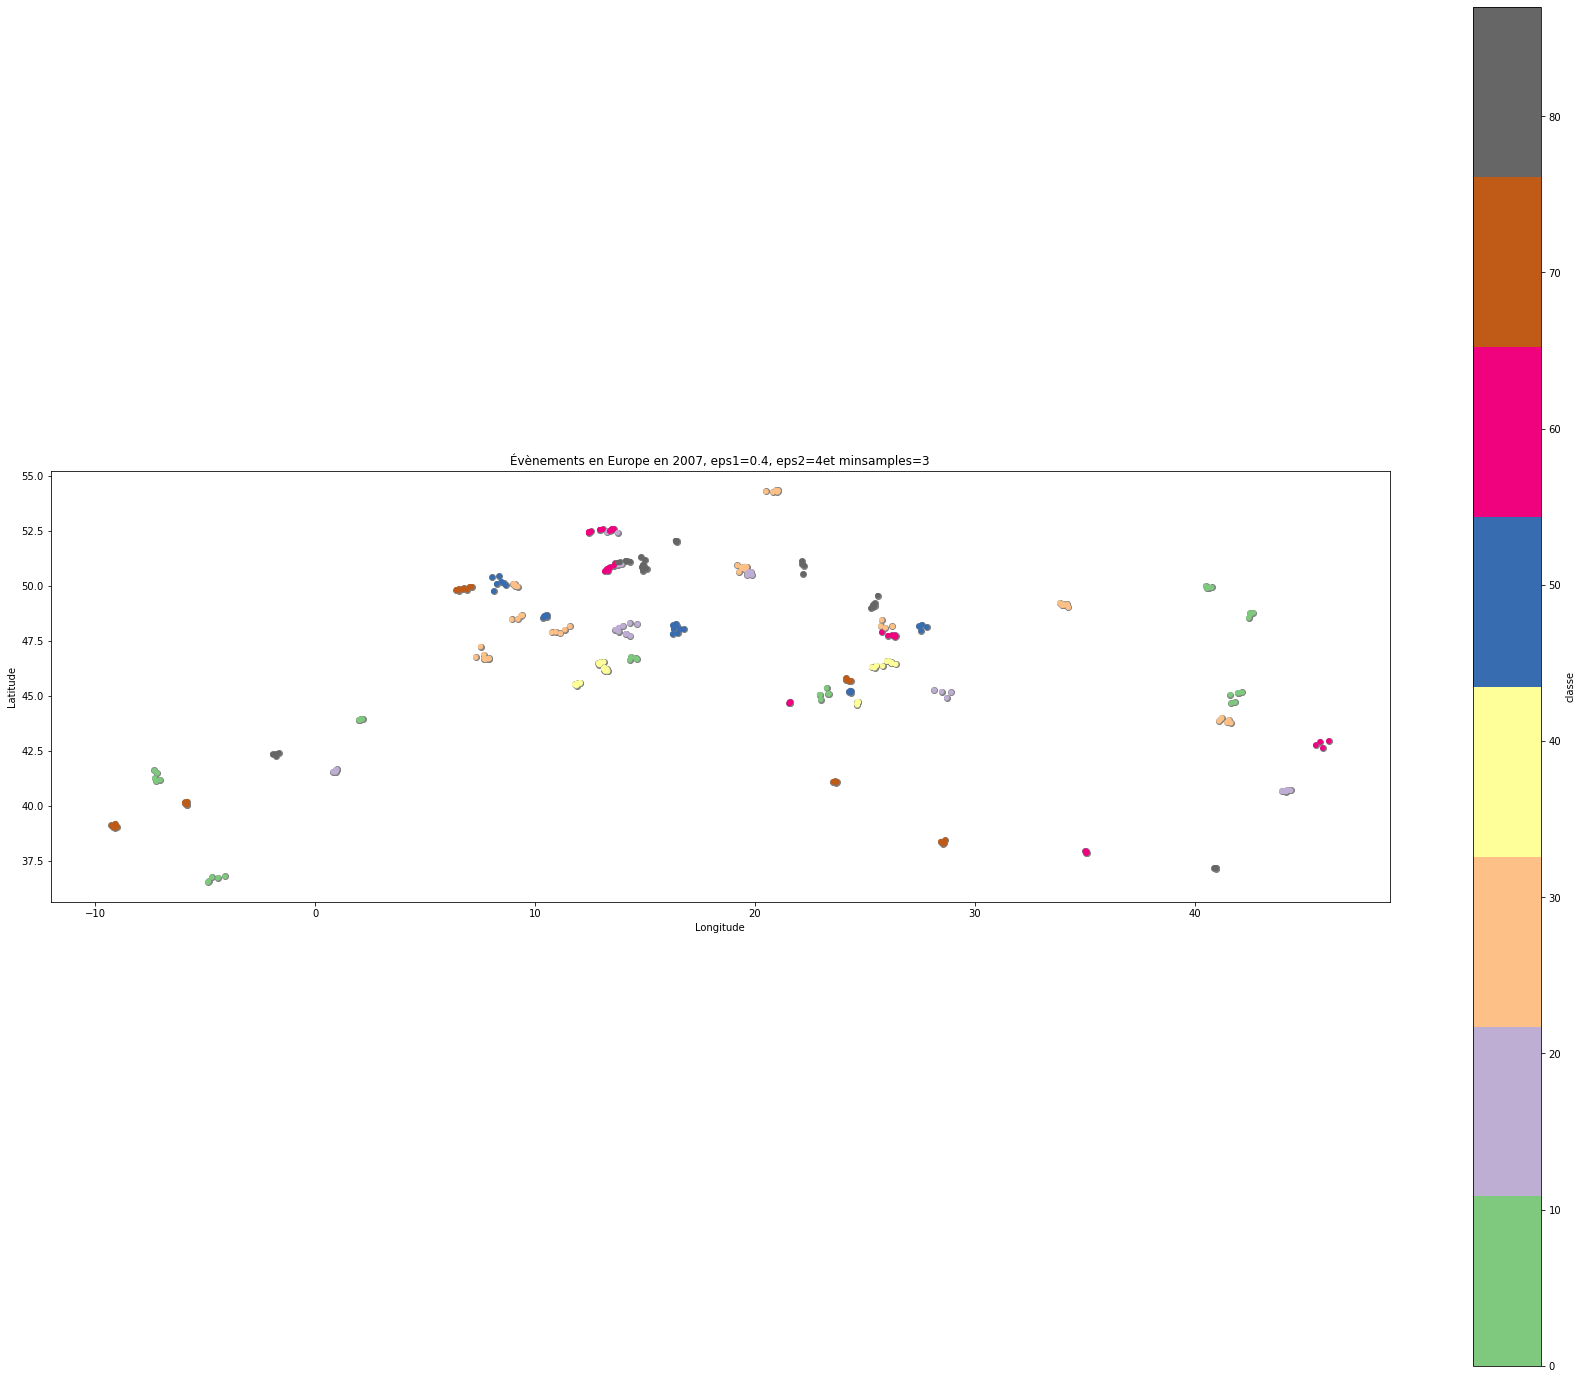

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            872       872        872      872
 0              3         3          3        3
 1              5         5          5        5
 2              5         5          5        5
 3              4         4          4        4
 4             11        11         11       11
 5              5         5          5        5
 6              3         3          3        3
 7              4         4          4        4
 8              5         5          5        5
 9              3         3          3        3
 10             6         6          6        6
 11             3         3          3        3
 12             3         3          3        3
 13             9         9          9        9
 14             6         6          6        6
 15             3         3          3        3
 16             3         3          3        3
 17             6         6          6  

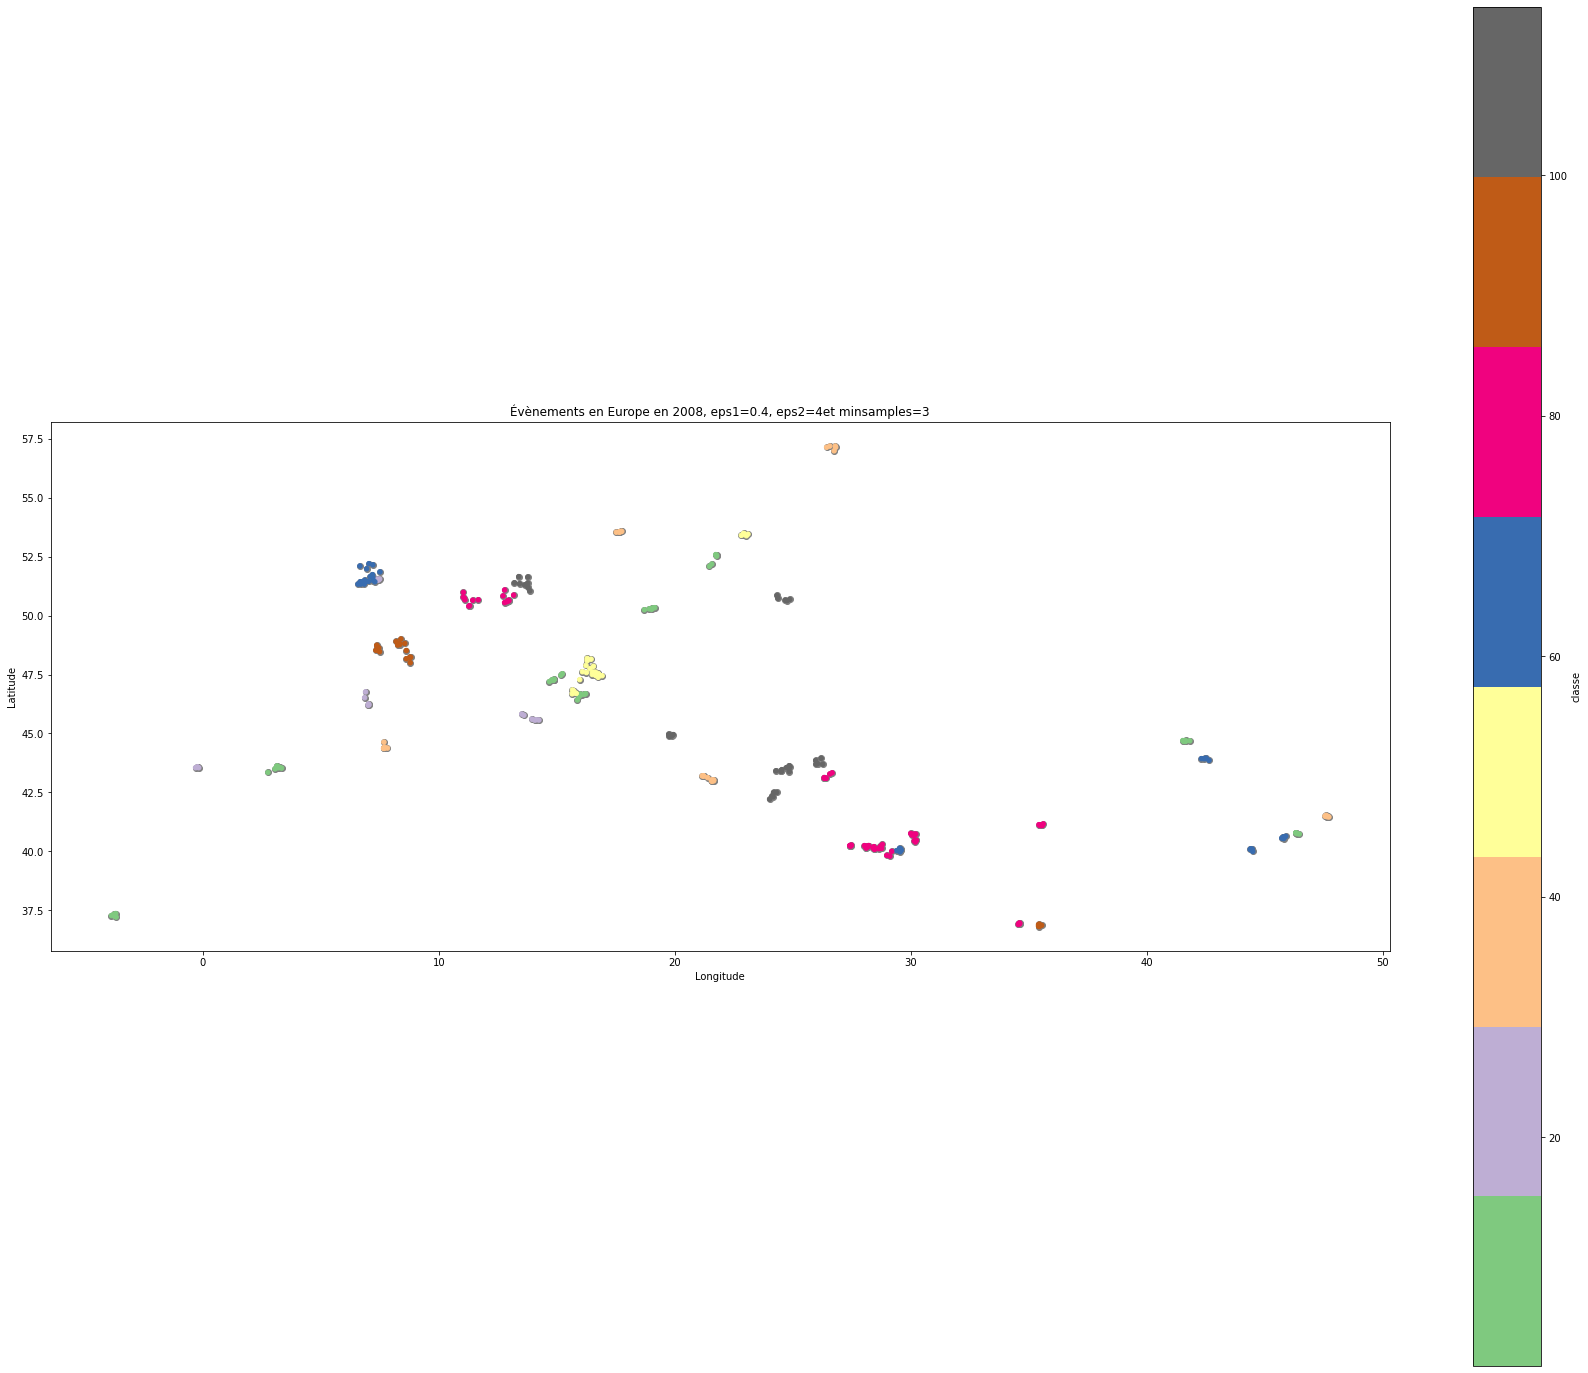

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            650       650        650      650
 0              3         3          3        3
 1              7         7          7        7
 2              3         3          3        3
 3              3         3          3        3
 4              5         5          5        5
 5              3         3          3        3
 6              3         3          3        3
 7              4         4          4        4
 8             11        11         11       11
 9              3         3          3        3
 10             5         5          5        5
 11            11        11         11       11
 12             3         3          3        3
 13            21        21         21       21
 14             5         5          5        5
 15             3         3          3        3
 16             3         3          3        3
 17             3         3          3  

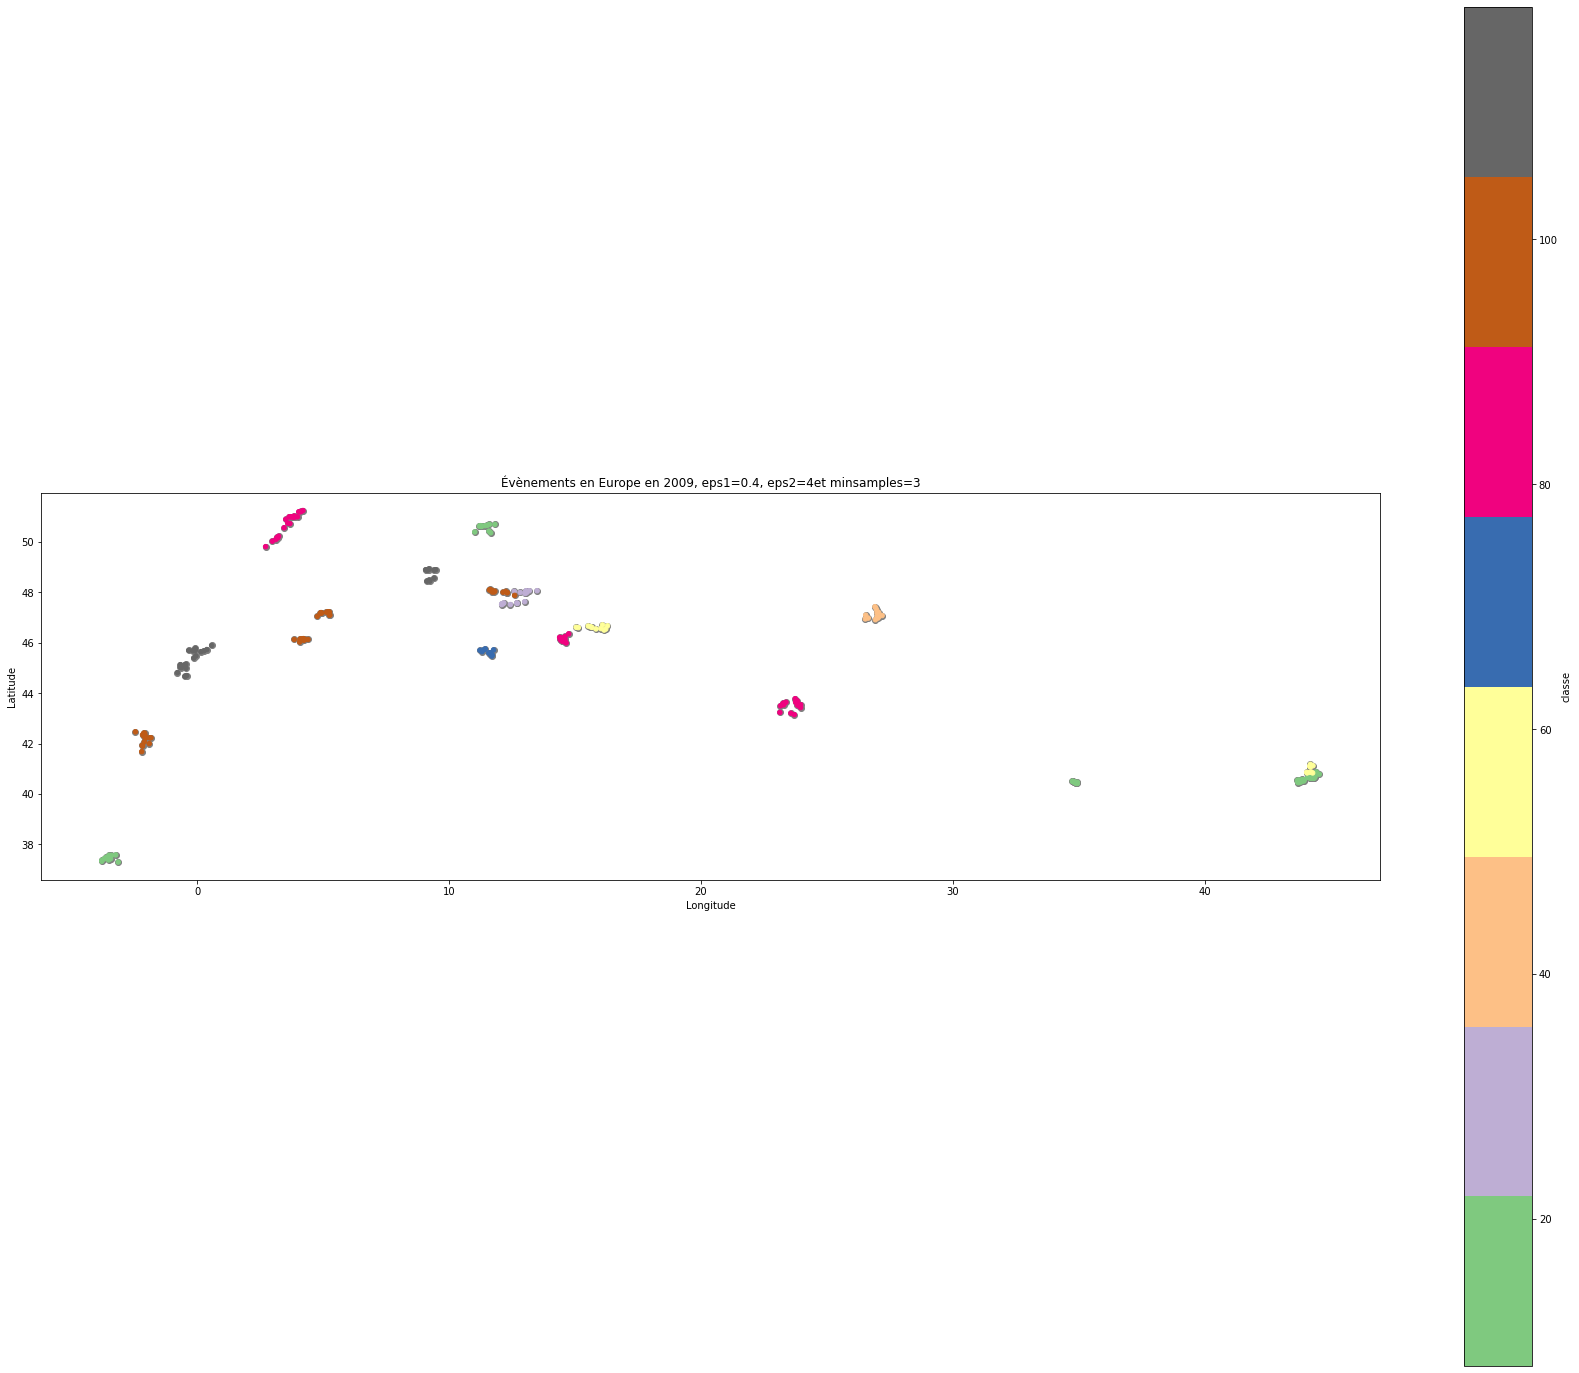

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            711       711        711      711
 0              3         3          3        3
 1              3         3          3        3
 2              7         7          7        7
 3              5         5          5        5
 4             19        19         19       19
 5              4         4          4        4
 6              7         7          7        7
 7              8         8          8        8
 8              3         3          3        3
 9              3         3          3        3
 10             3         3          3        3
 11             4         4          4        4
 12            40        40         40       40
 13             3         3          3        3
 14             3         3          3        3
 15             5         5          5        5
 16             9         9          9        9
 17             3         3          3  

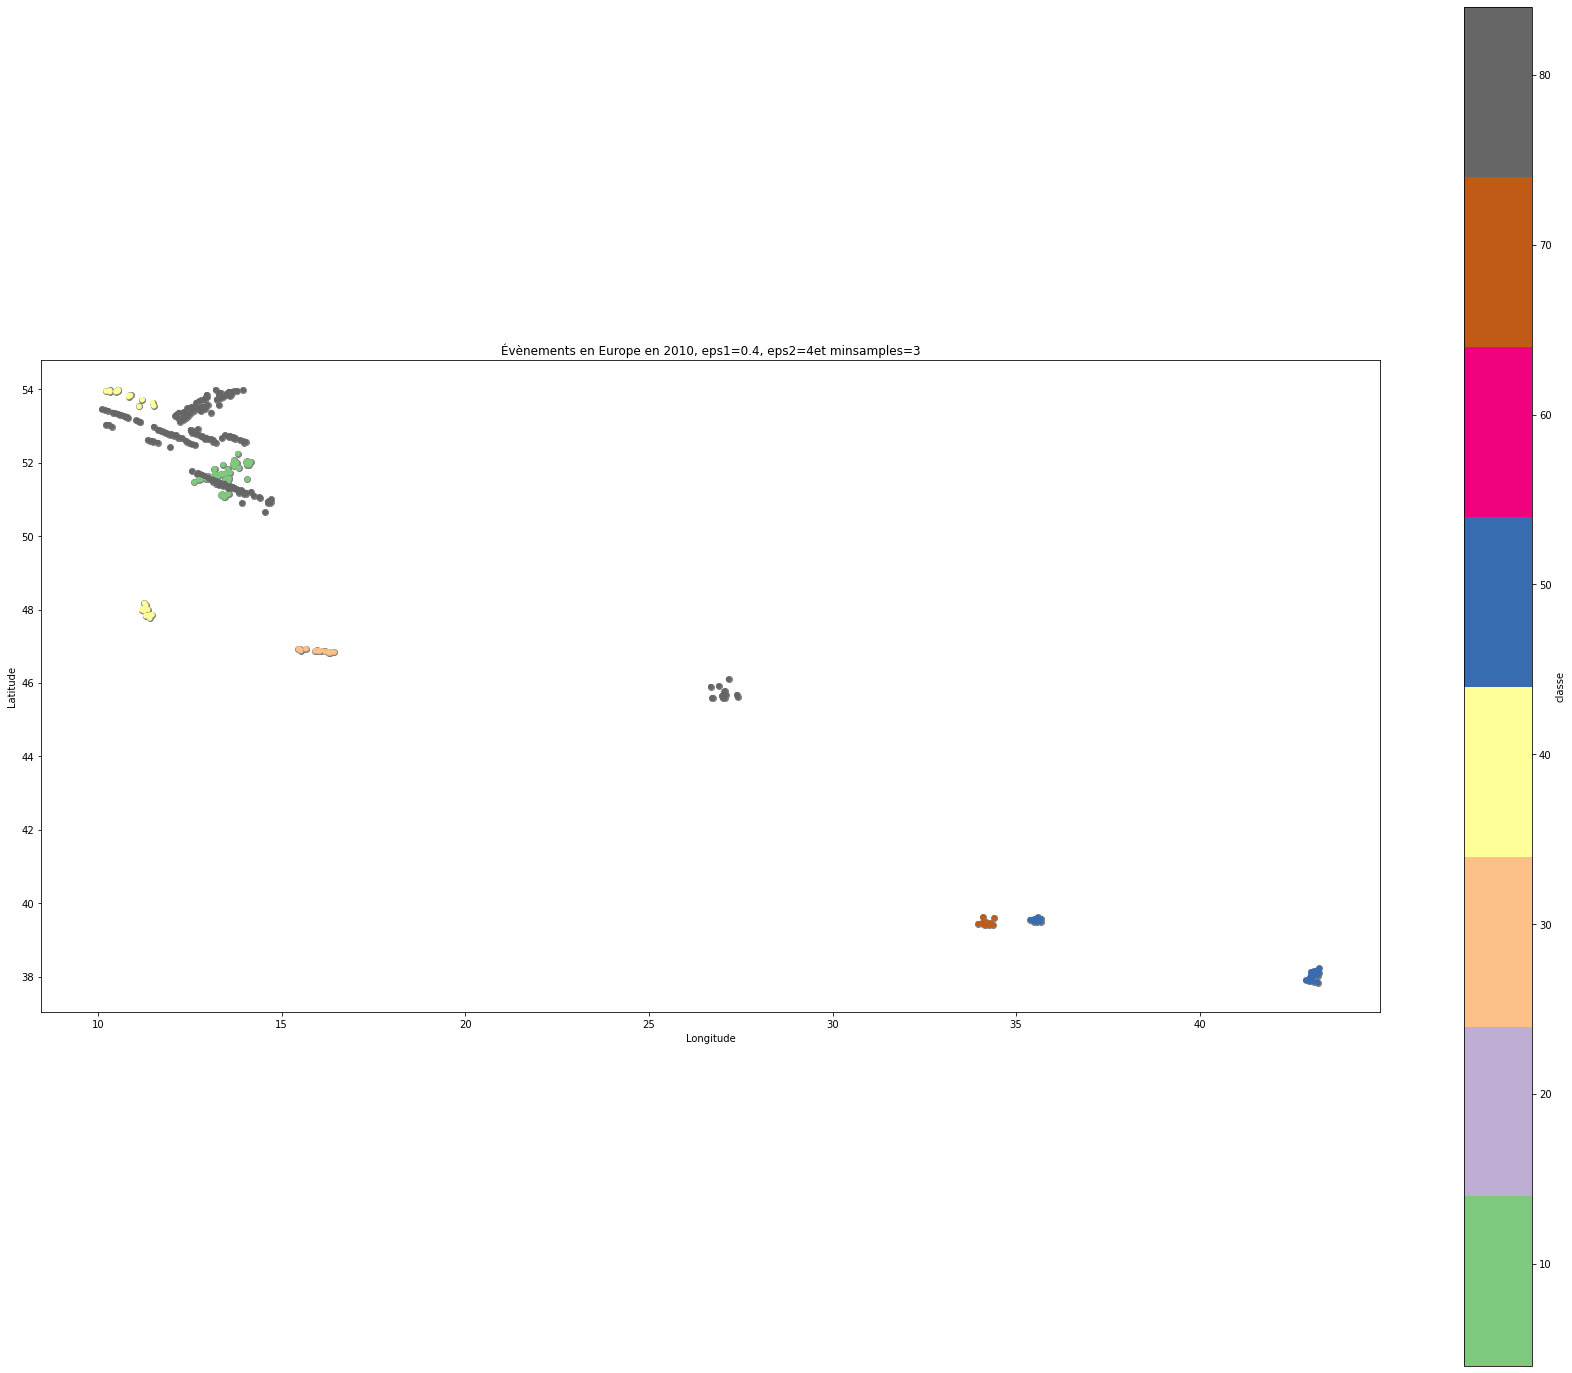

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            860       860        860      860
 0              3         3          3        3
 1              3         3          3        3
 2              3         3          3        3
 3              3         3          3        3
 4             56        56         56       56
 5              3         3          3        3
 6             13        13         13       13
 7             16        16         16       16
 8              5         5          5        5
 9             10        10         10       10
 10             3         3          3        3
 11             4         4          4        4
 12             9         9          9        9
 13             8         8          8        8
 14             3         3          3        3
 15             8         8          8        8
 16             3         3          3        3
 17             3         3          3  

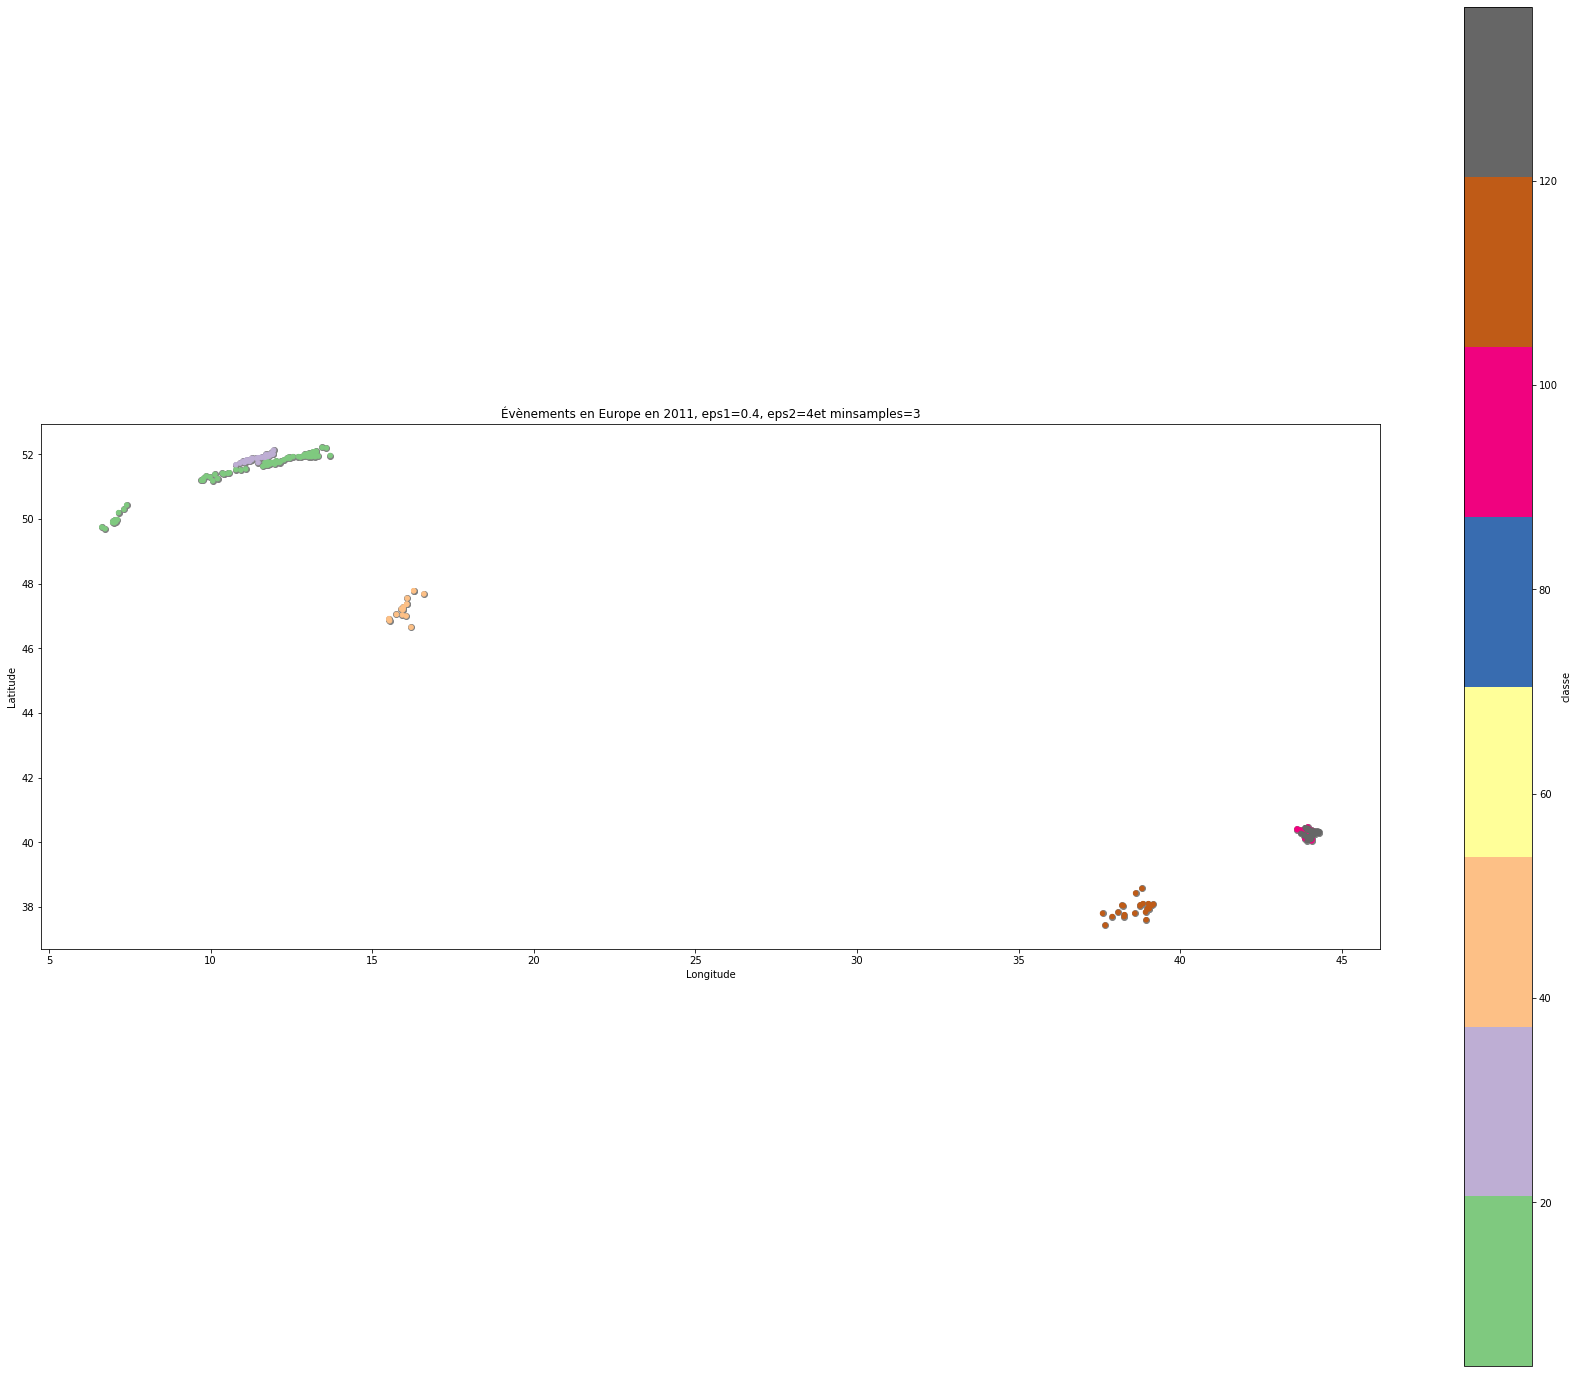

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            997       997        997      997
 0              3         3          3        3
 1              5         5          5        5
 2              5         5          5        5
 3              3         3          3        3
 4              3         3          3        3
 5              4         4          4        4
 6              4         4          4        4
 7              3         3          3        3
 8              7         7          7        7
 9             11        11         11       11
 10             3         3          3        3
 11             6         6          6        6
 12             8         8          8        8
 13             7         7          7        7
 14             6         6          6        6
 15             5         5          5        5
 16             4         4          4        4
 17             3         3          3  

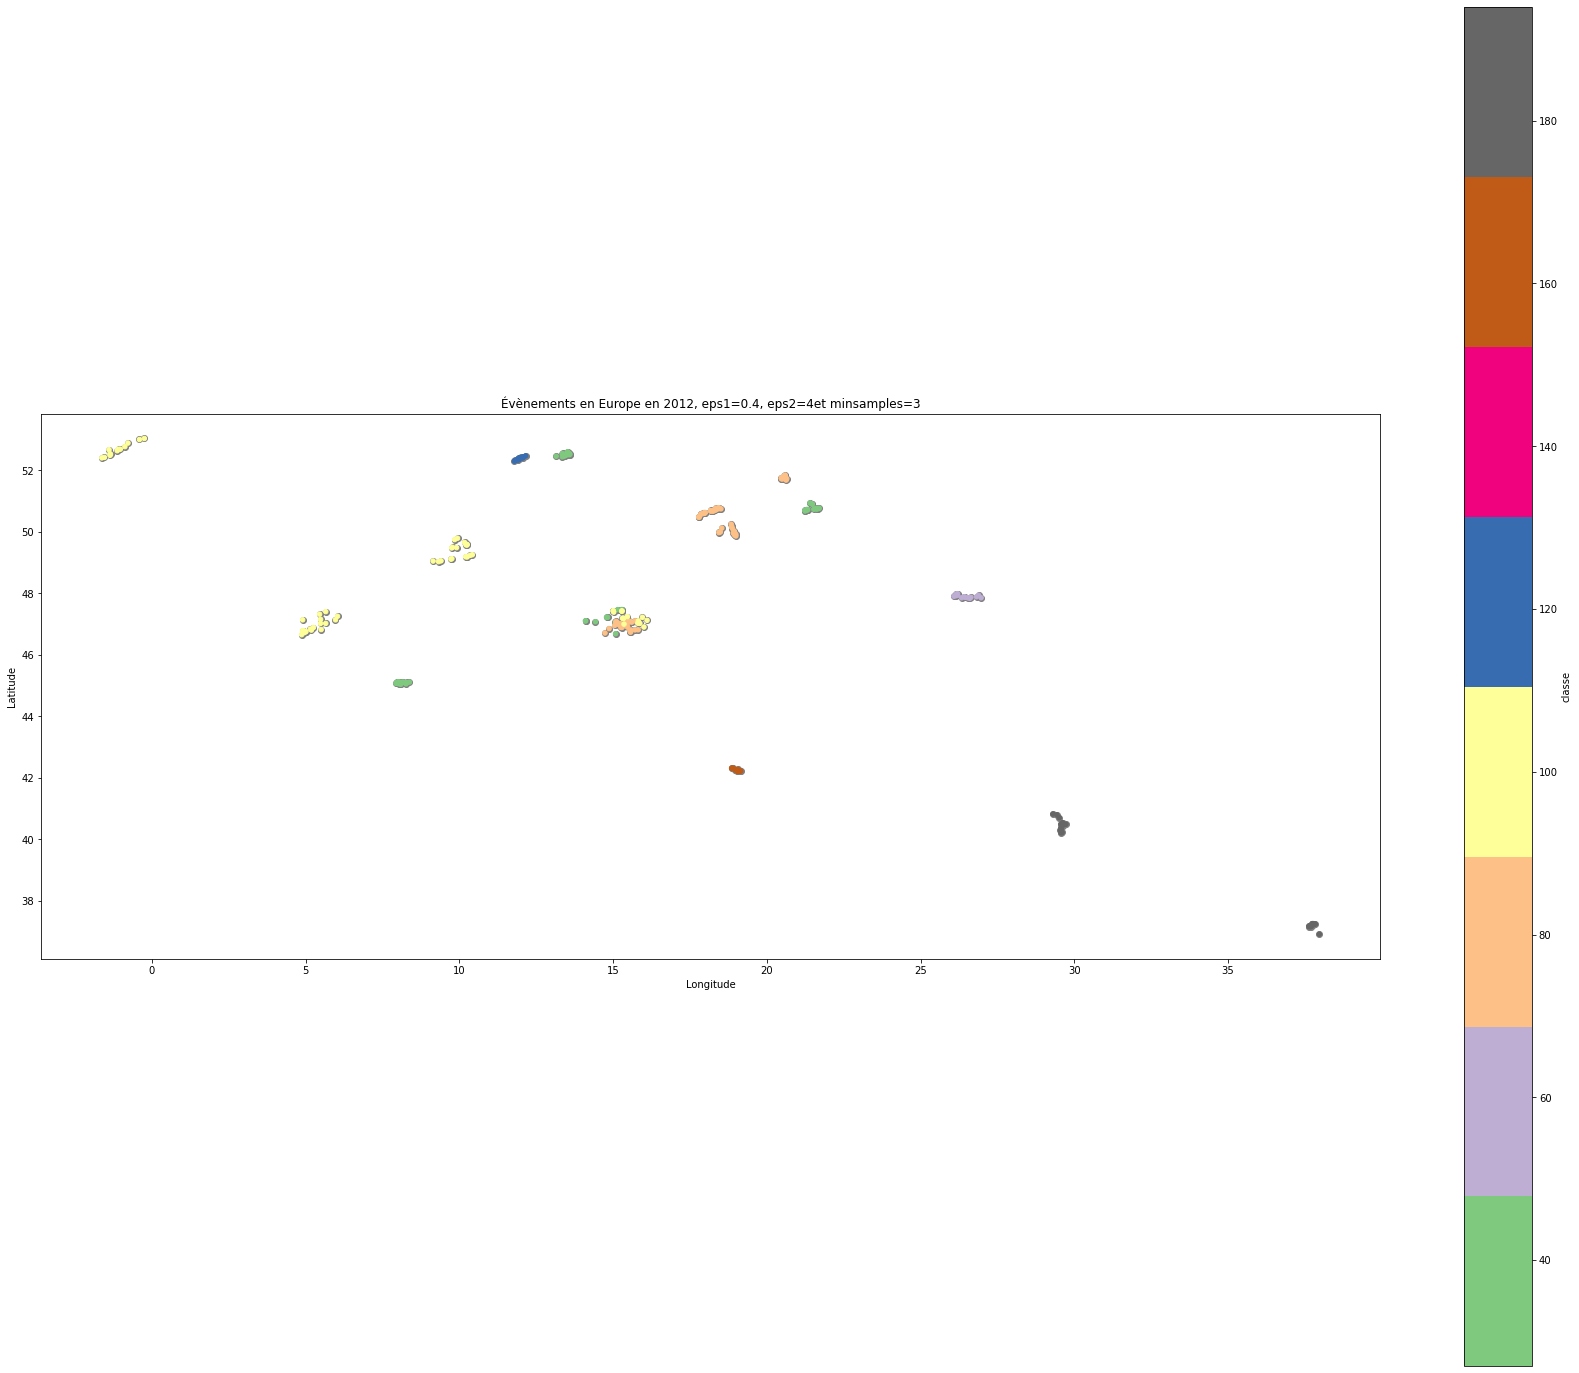

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            864       864        864      864
 0              4         4          4        4
 1              8         8          8        8
 2              5         5          5        5
 3             20        20         20       20
 4              6         6          6        6
 5              7         7          7        7
 6              3         3          3        3
 7              3         3          3        3
 8              3         3          3        3
 9              4         4          4        4
 10             6         6          6        6
 11             3         3          3        3
 12             6         6          6        6
 13            13        13         13       13
 14            10        10         10       10
 15            10        10         10       10
 16             3         3          3        3
 17            21        21         21  

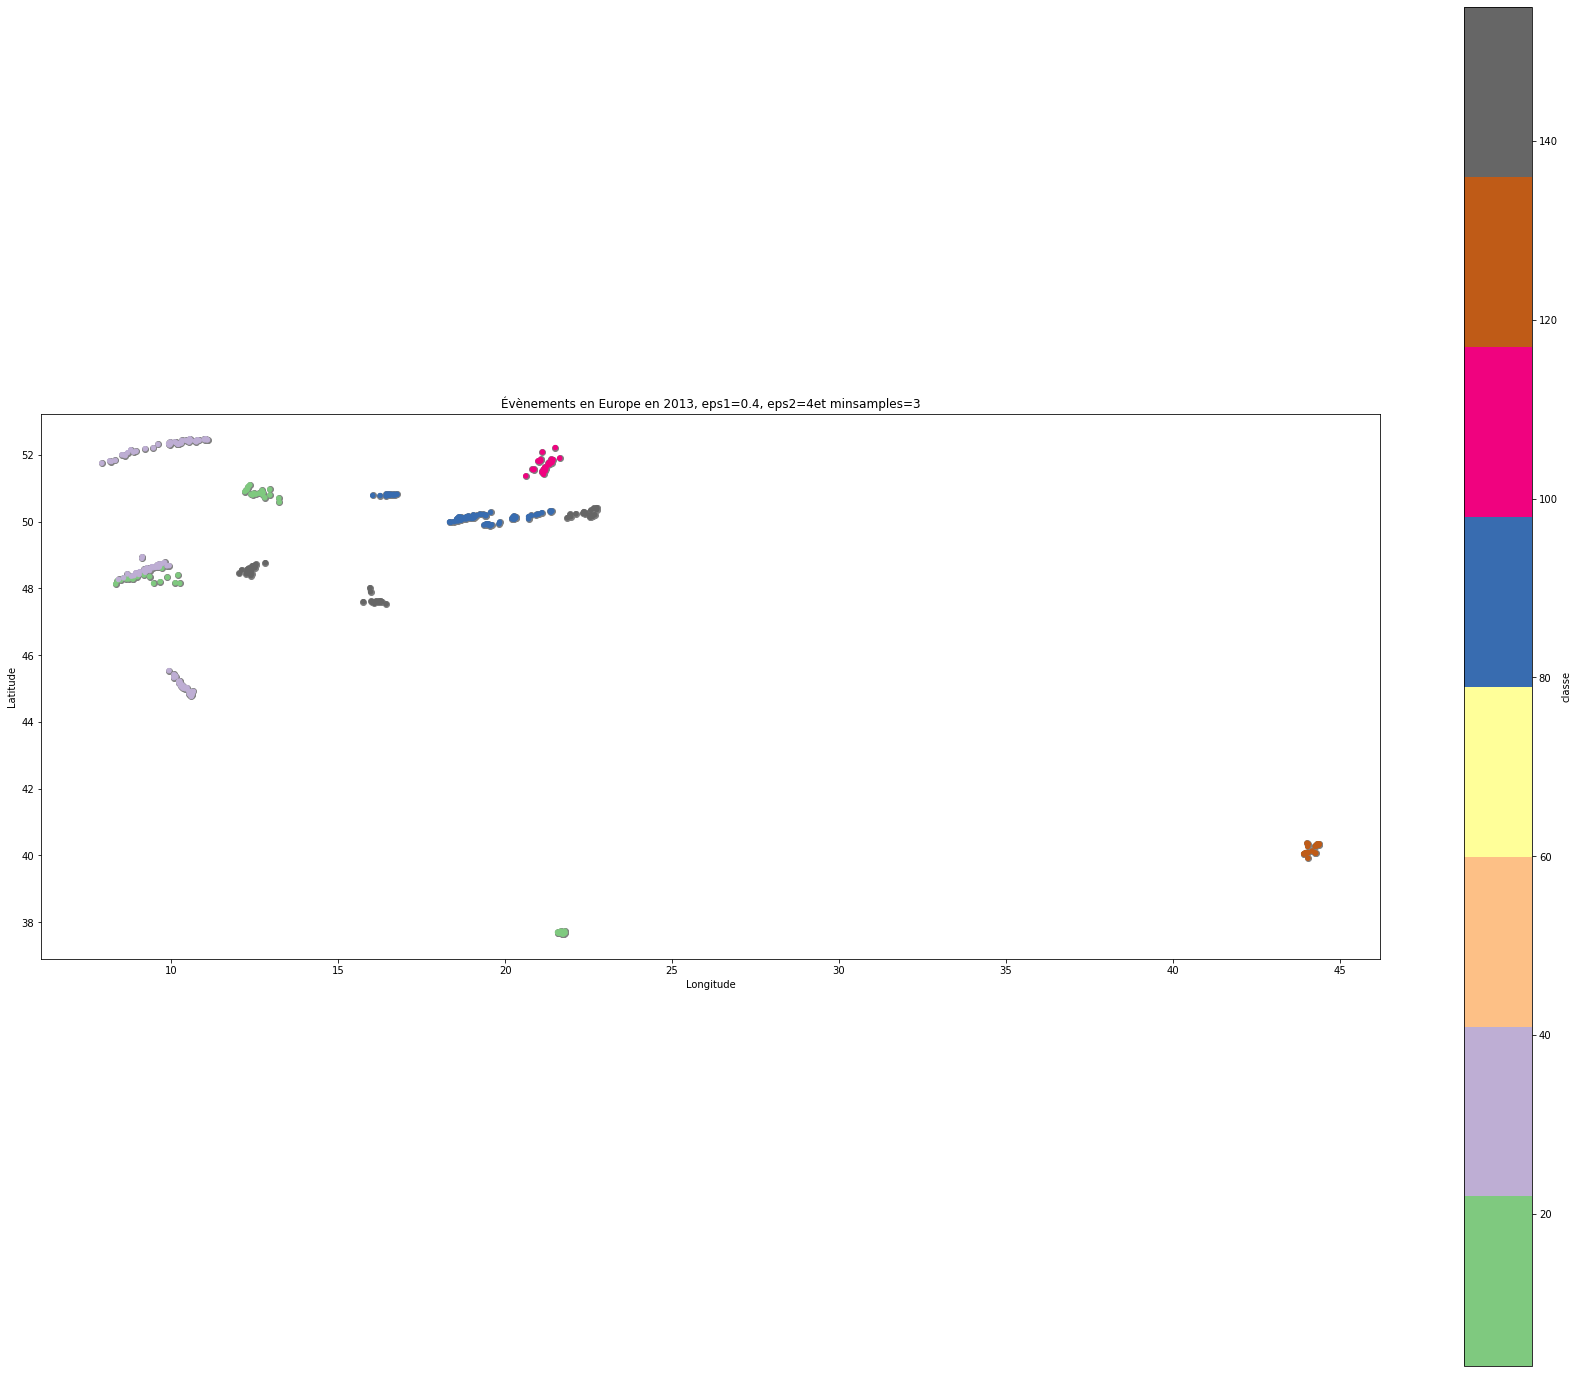

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1           1125      1125       1125     1125
 0              3         3          3        3
 1              4         4          4        4
 2              4         4          4        4
 3              3         3          3        3
 4              4         4          4        4
 5              5         5          5        5
 6              3         3          3        3
 7              5         5          5        5
 8              9         9          9        9
 9              3         3          3        3
 10            11        11         11       11
 11             7         7          7        7
 12             7         7          7        7
 13             3         3          3        3
 14             3         3          3        3
 15             3         3          3        3
 16             3         3          3        3
 17             3         3          3  

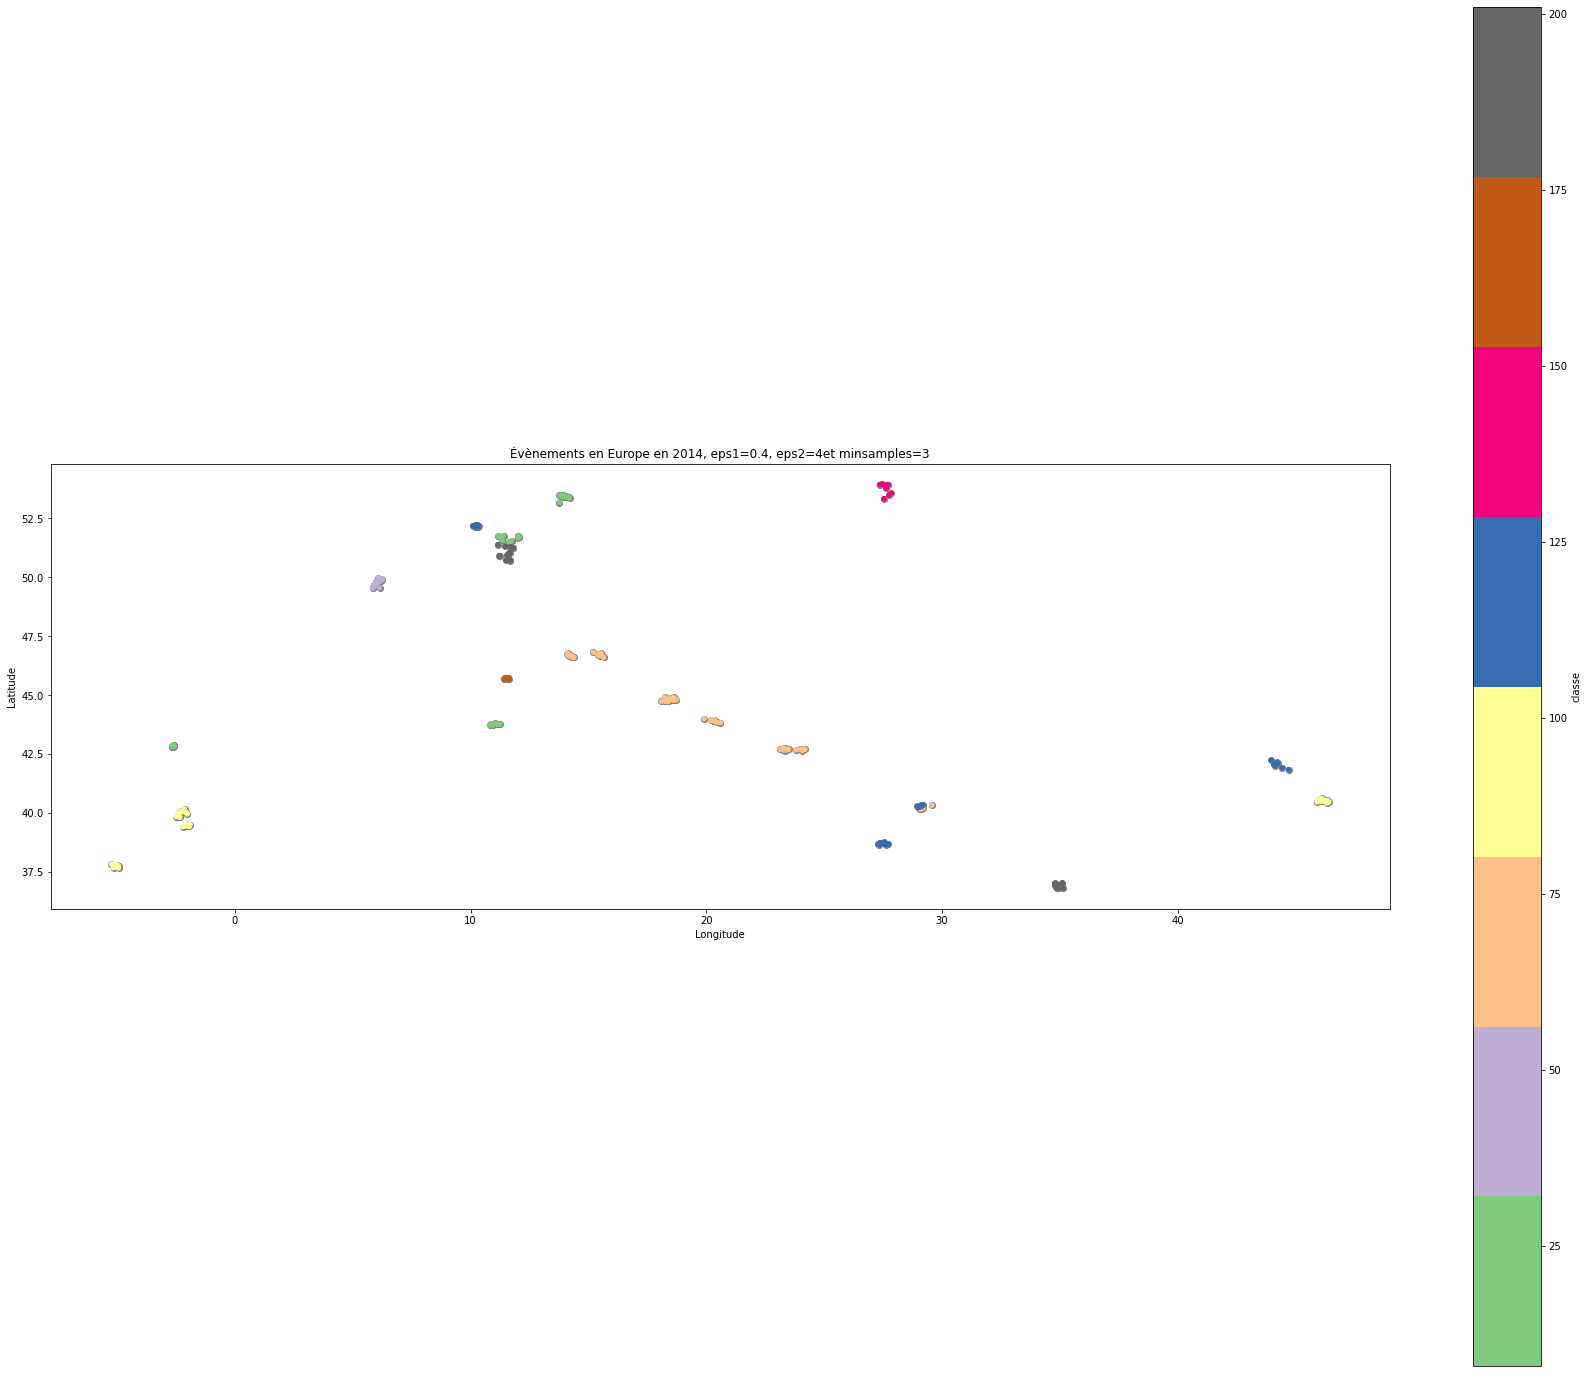

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            871       871        871      871
 0              6         6          6        6
 1              3         3          3        3
 2              3         3          3        3
 3              6         6          6        6
 4              4         4          4        4
 5             13        13         13       13
 6              5         5          5        5
 7              3         3          3        3
 8              6         6          6        6
 9              5         5          5        5
 10             5         5          5        5
 11             5         5          5        5
 12             3         3          3        3
 13             4         4          4        4
 14             7         7          7        7
 15             9         9          9        9
 16             5         5          5        5
 17             3         3          3  

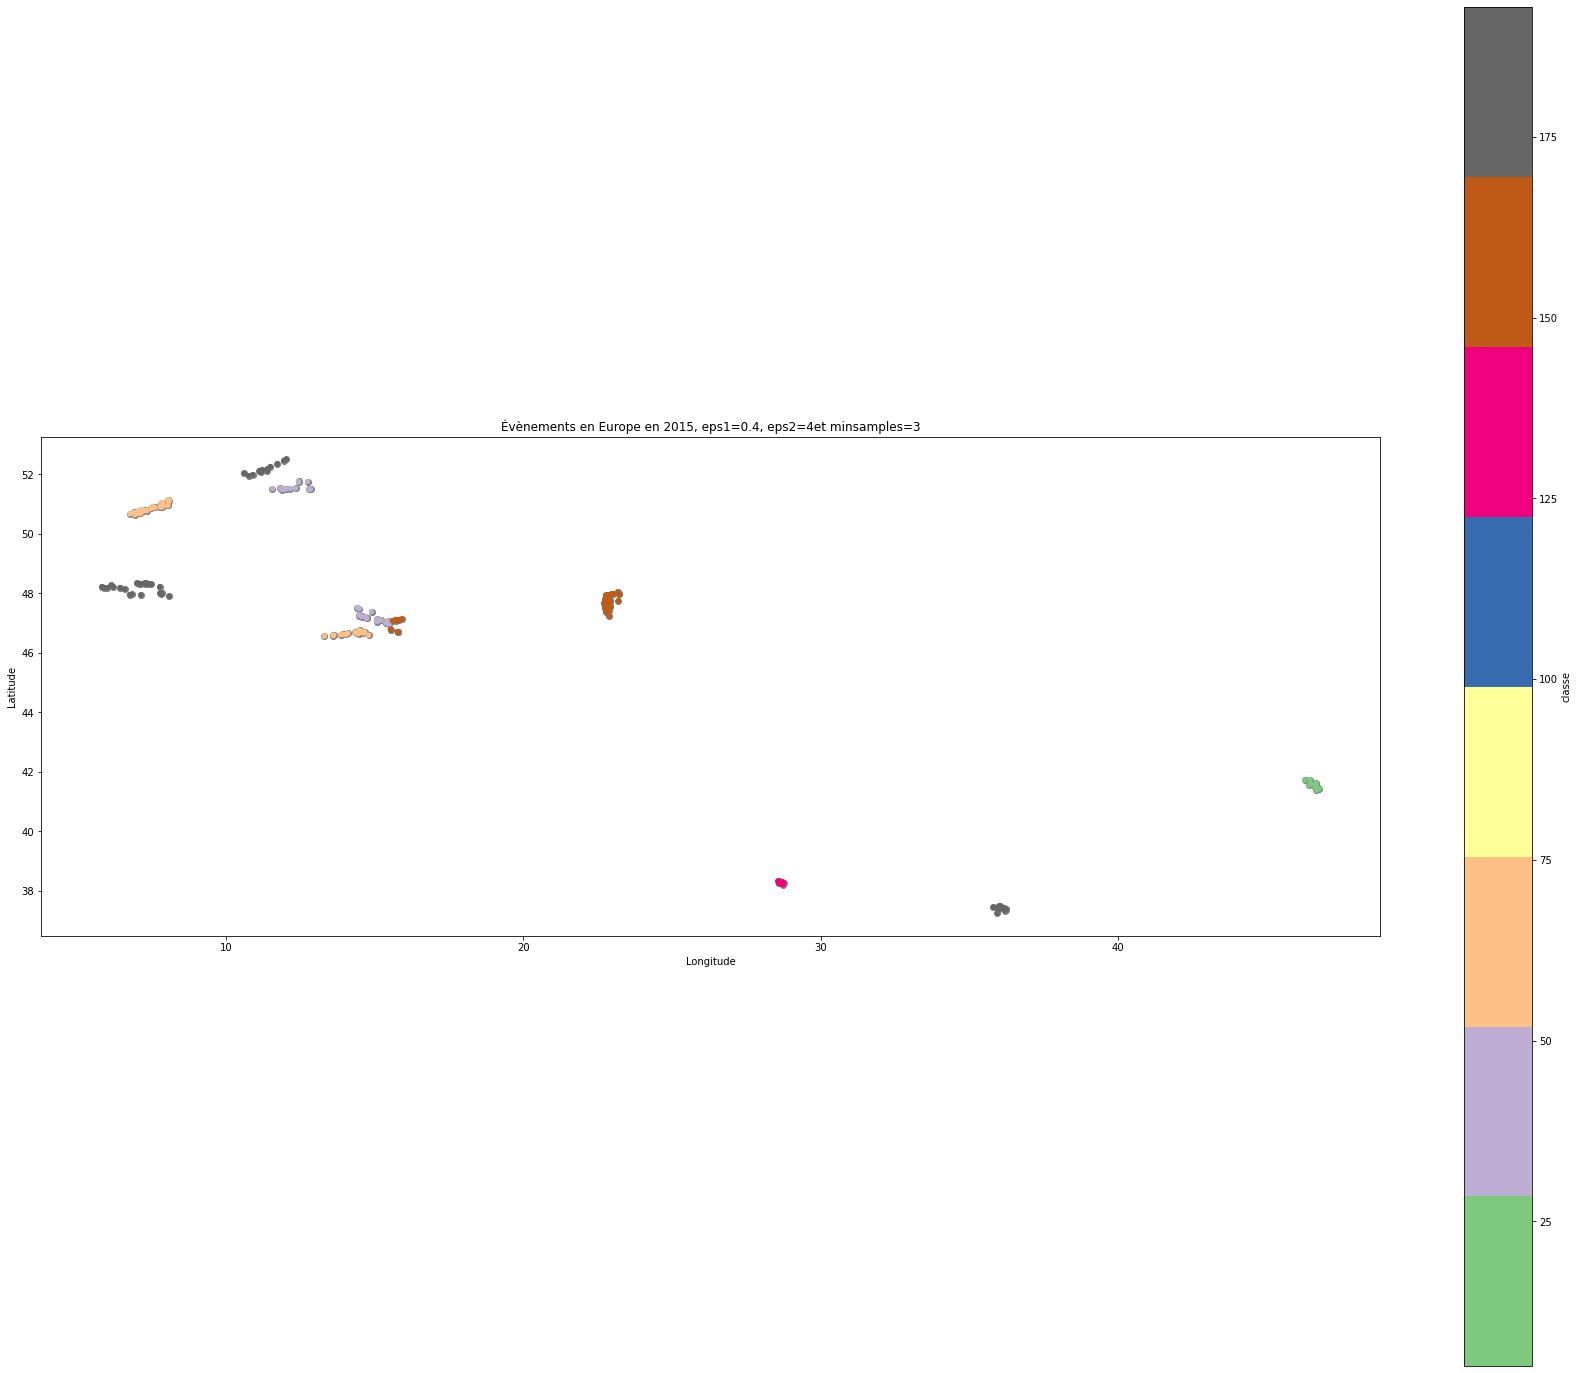

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1           1098      1098       1098     1098
 0              3         3          3        3
 1              8         8          8        8
 2              3         3          3        3
 3              6         6          6        6
 4              5         5          5        5
 5              5         5          5        5
 6              4         4          4        4
 7              4         4          4        4
 8             67        67         67       67
 9              4         4          4        4
 10             4         4          4        4
 11             3         3          3        3
 12            13        13         13       13
 13            23        23         23       23
 14             3         3          3        3
 15             3         3          3        3
 16             3         3          3        3
 17             6         6          6  

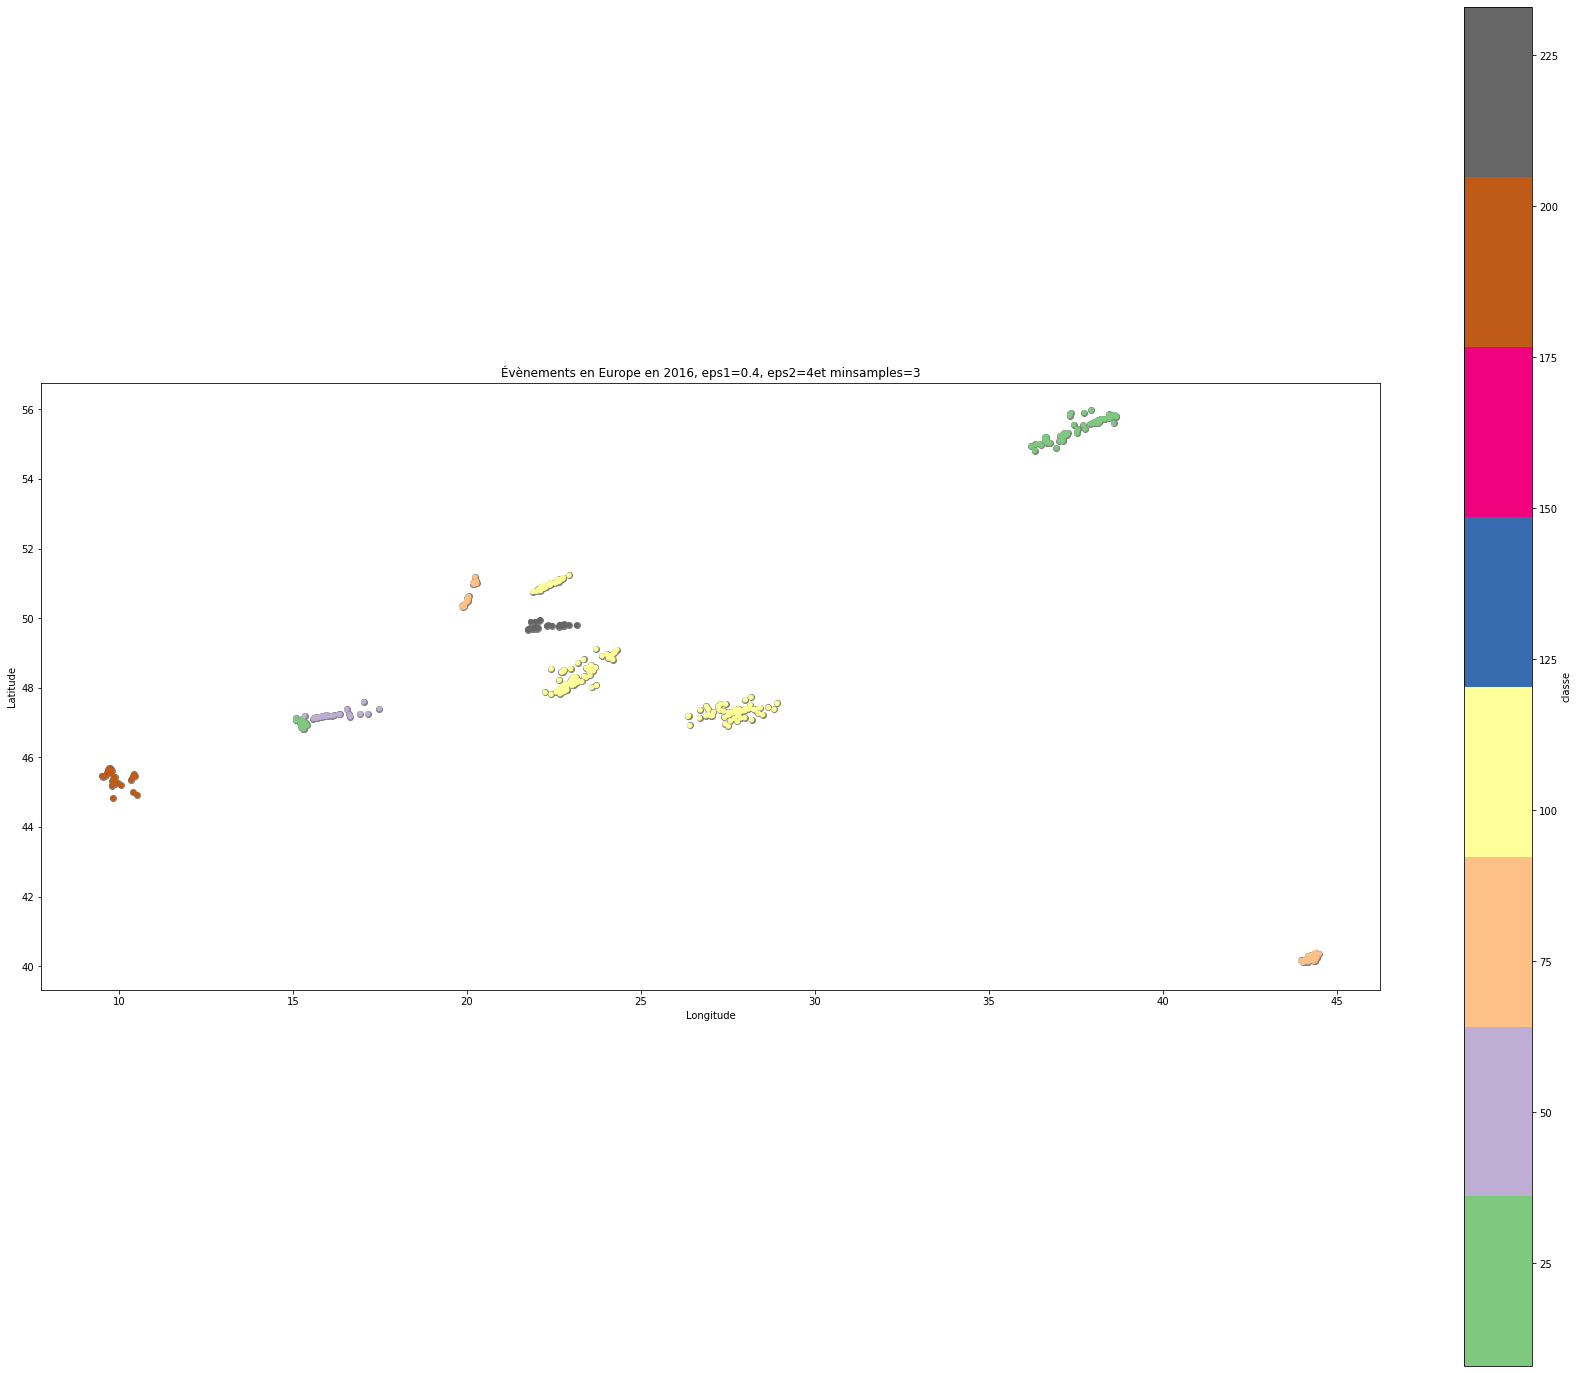

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1           1079      1079       1079     1079
 0              8         8          8        8
 1              7         7          7        7
 2              3         3          3        3
 3              8         8          8        8
 4              3         3          3        3
 5              5         5          5        5
 6              6         6          6        6
 7              3         3          3        3
 8              3         3          3        3
 9              6         6          6        6
 10             5         5          5        5
 11             3         3          3        3
 12             4         4          4        4
 13             4         4          4        4
 14             5         5          5        5
 15             3         3          3        3
 16             9         9          9        9
 17             4         4          4  

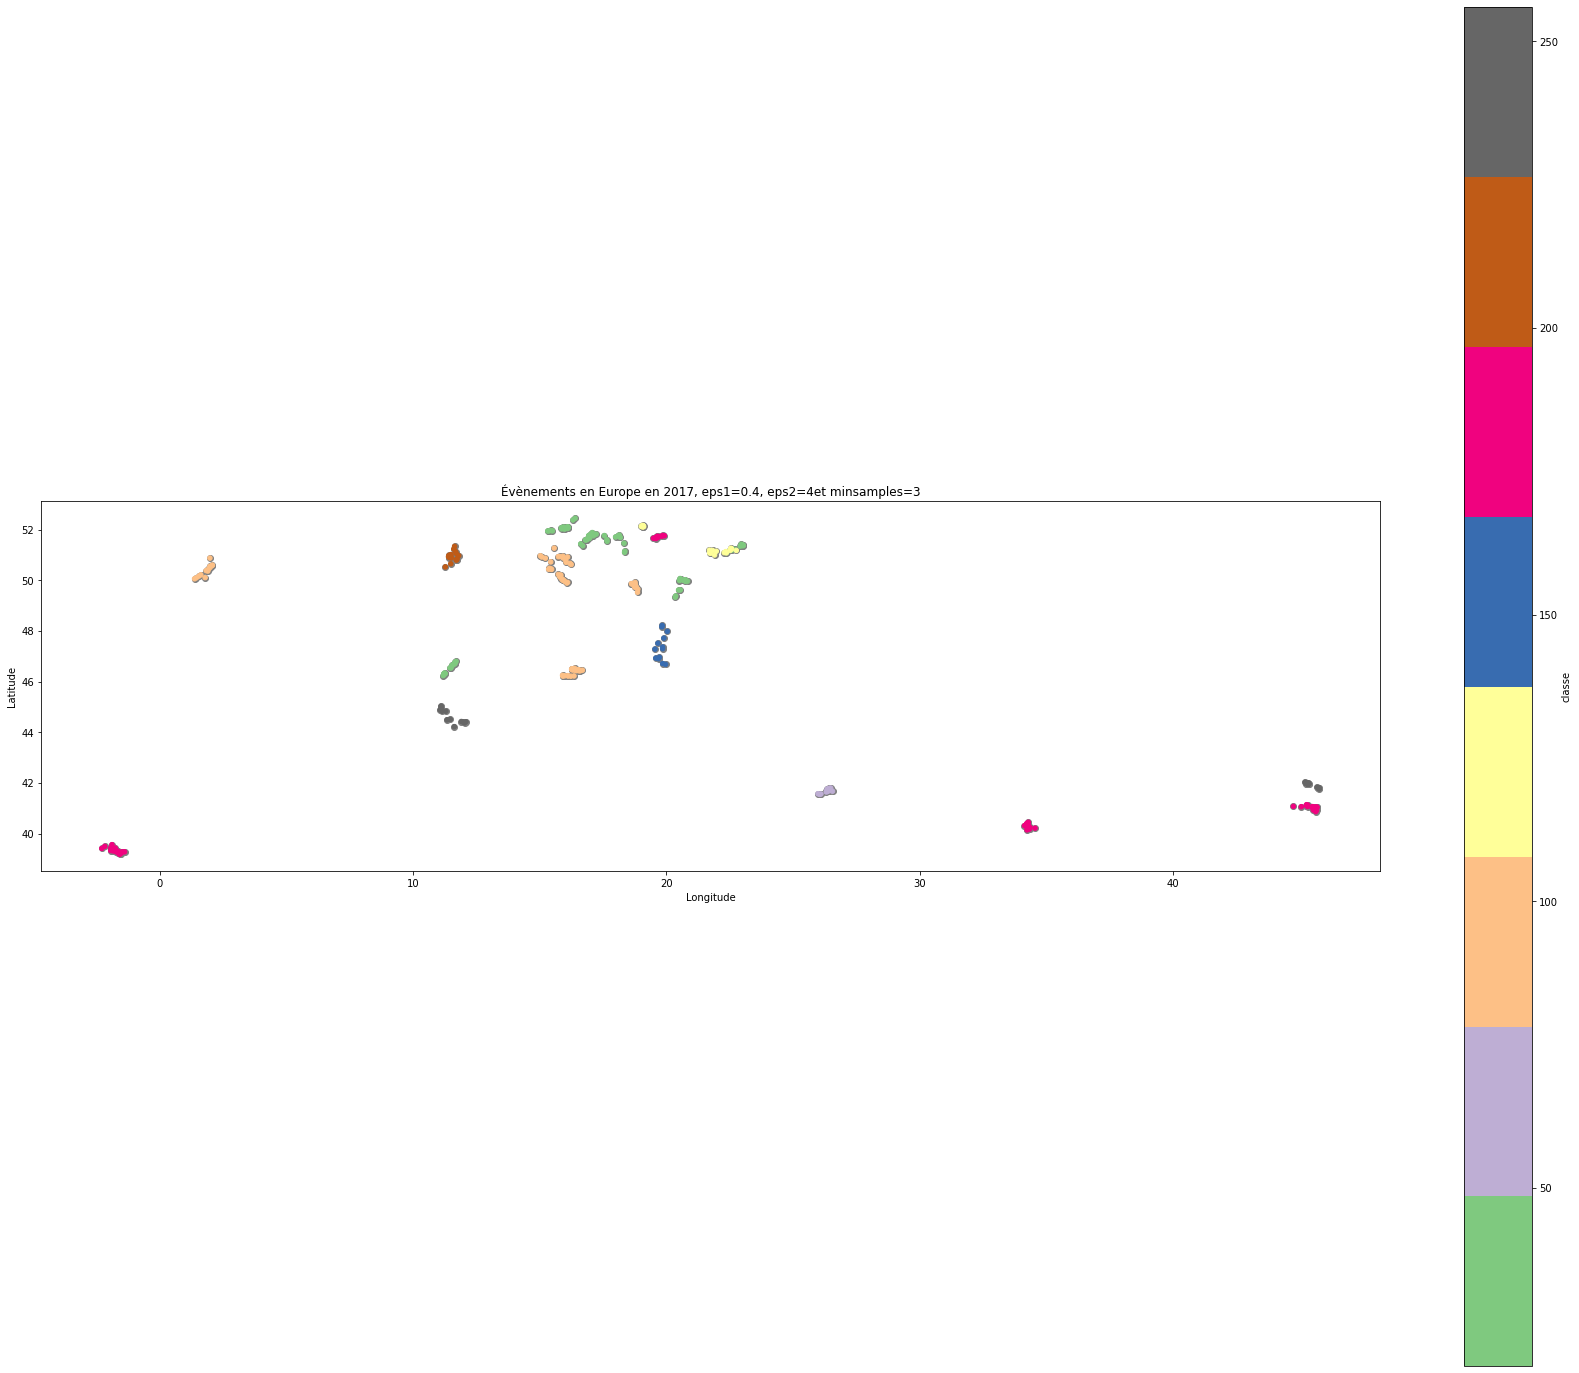

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1           1084      1084       1084     1084
 0              8         8          8        8
 1             15        15         15       15
 2              7         7          7        7
 3              5         5          5        5
 4              8         8          8        8
 5              6         6          6        6
 6              3         3          3        3
 7              3         3          3        3
 8              3         3          3        3
 9              8         8          8        8
 10             5         5          5        5
 11             3         3          3        3
 12             3         3          3        3
 13             4         4          4        4
 14             6         6          6        6
 15             3         3          3        3
 16             5         5          5        5
 17             6         6          6  

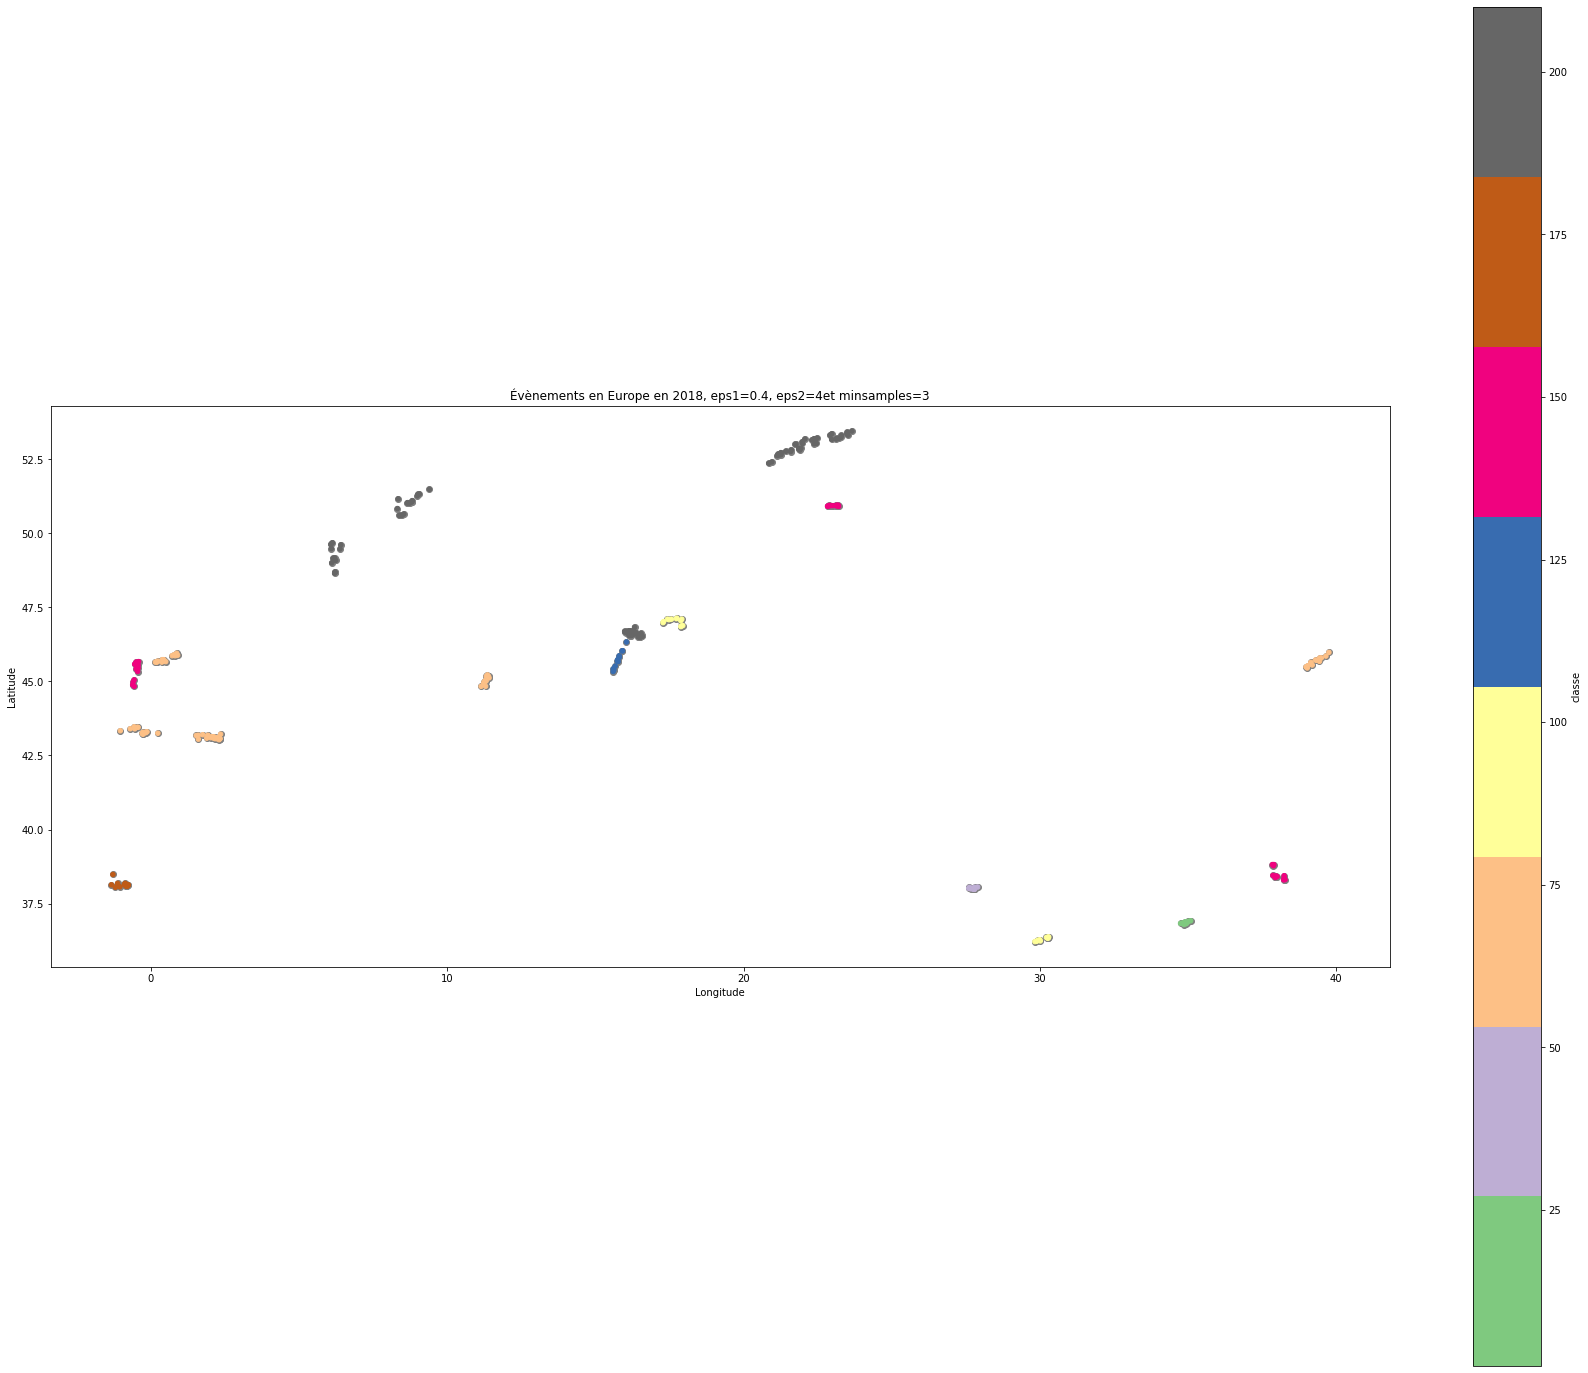

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1           1167      1167       1167     1167
 0              3         3          3        3
 1             19        19         19       19
 2              3         3          3        3
 3              3         3          3        3
 4              4         4          4        4
 5              3         3          3        3
 6              3         3          3        3
 7              4         4          4        4
 8              3         3          3        3
 9              5         5          5        5
 10             4         4          4        4
 11             3         3          3        3
 12             3         3          3        3
 13             5         5          5        5
 14            26        26         26       26
 15             4         4          4        4
 16             3         3          3        3
 17             7         7          7  

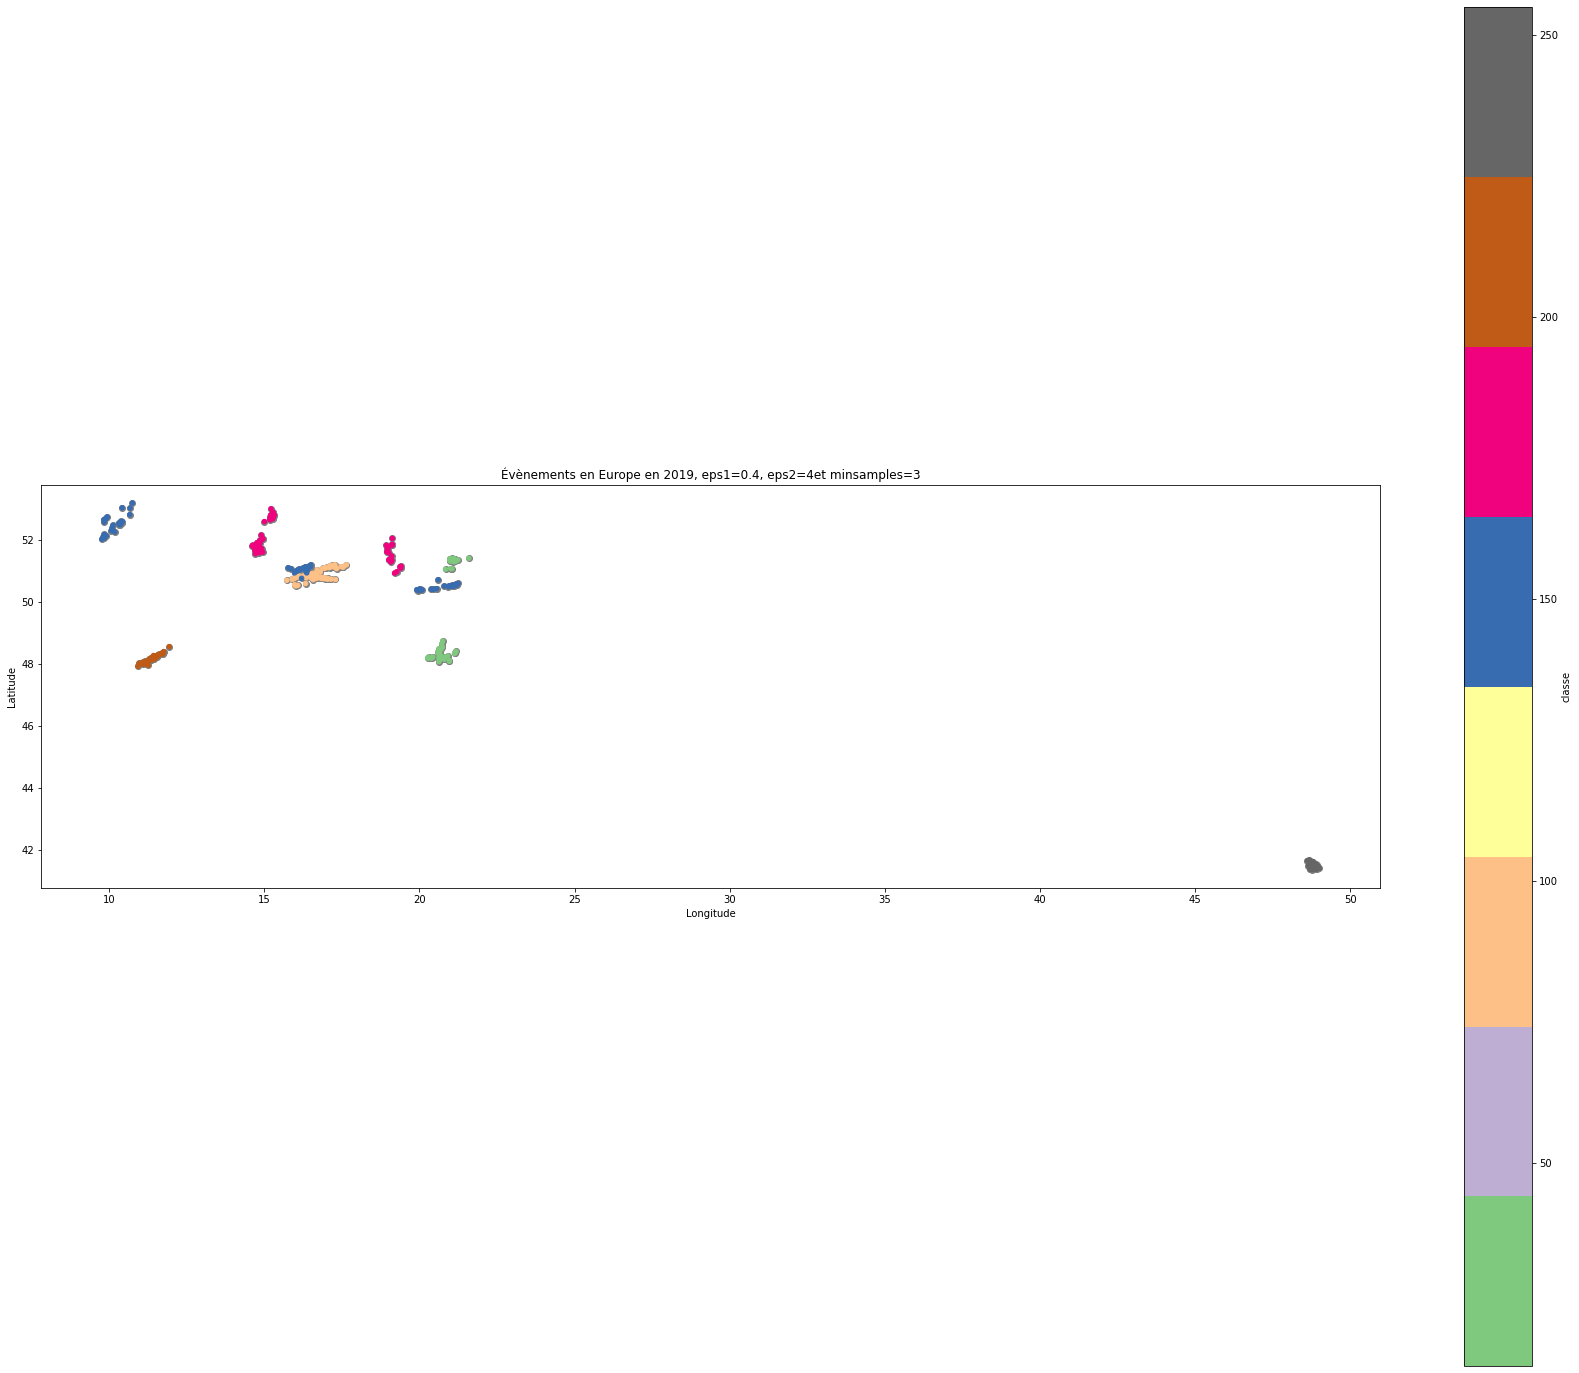

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1           1226      1226       1226     1226
 0              3         3          3        3
 1              5         5          5        5
 2              3         3          3        3
 3              3         3          3        3
 4              6         6          6        6
 5              5         5          5        5
 6              5         5          5        5
 7              3         3          3        3
 8             14        14         14       14
 9              5         5          5        5
 10             6         6          6        6
 11             4         4          4        4
 12             4         4          4        4
 13             3         3          3        3
 14             3         3          3        3
 15            12        12         12       12
 16            14        14         14       14
 17             4         4          4  

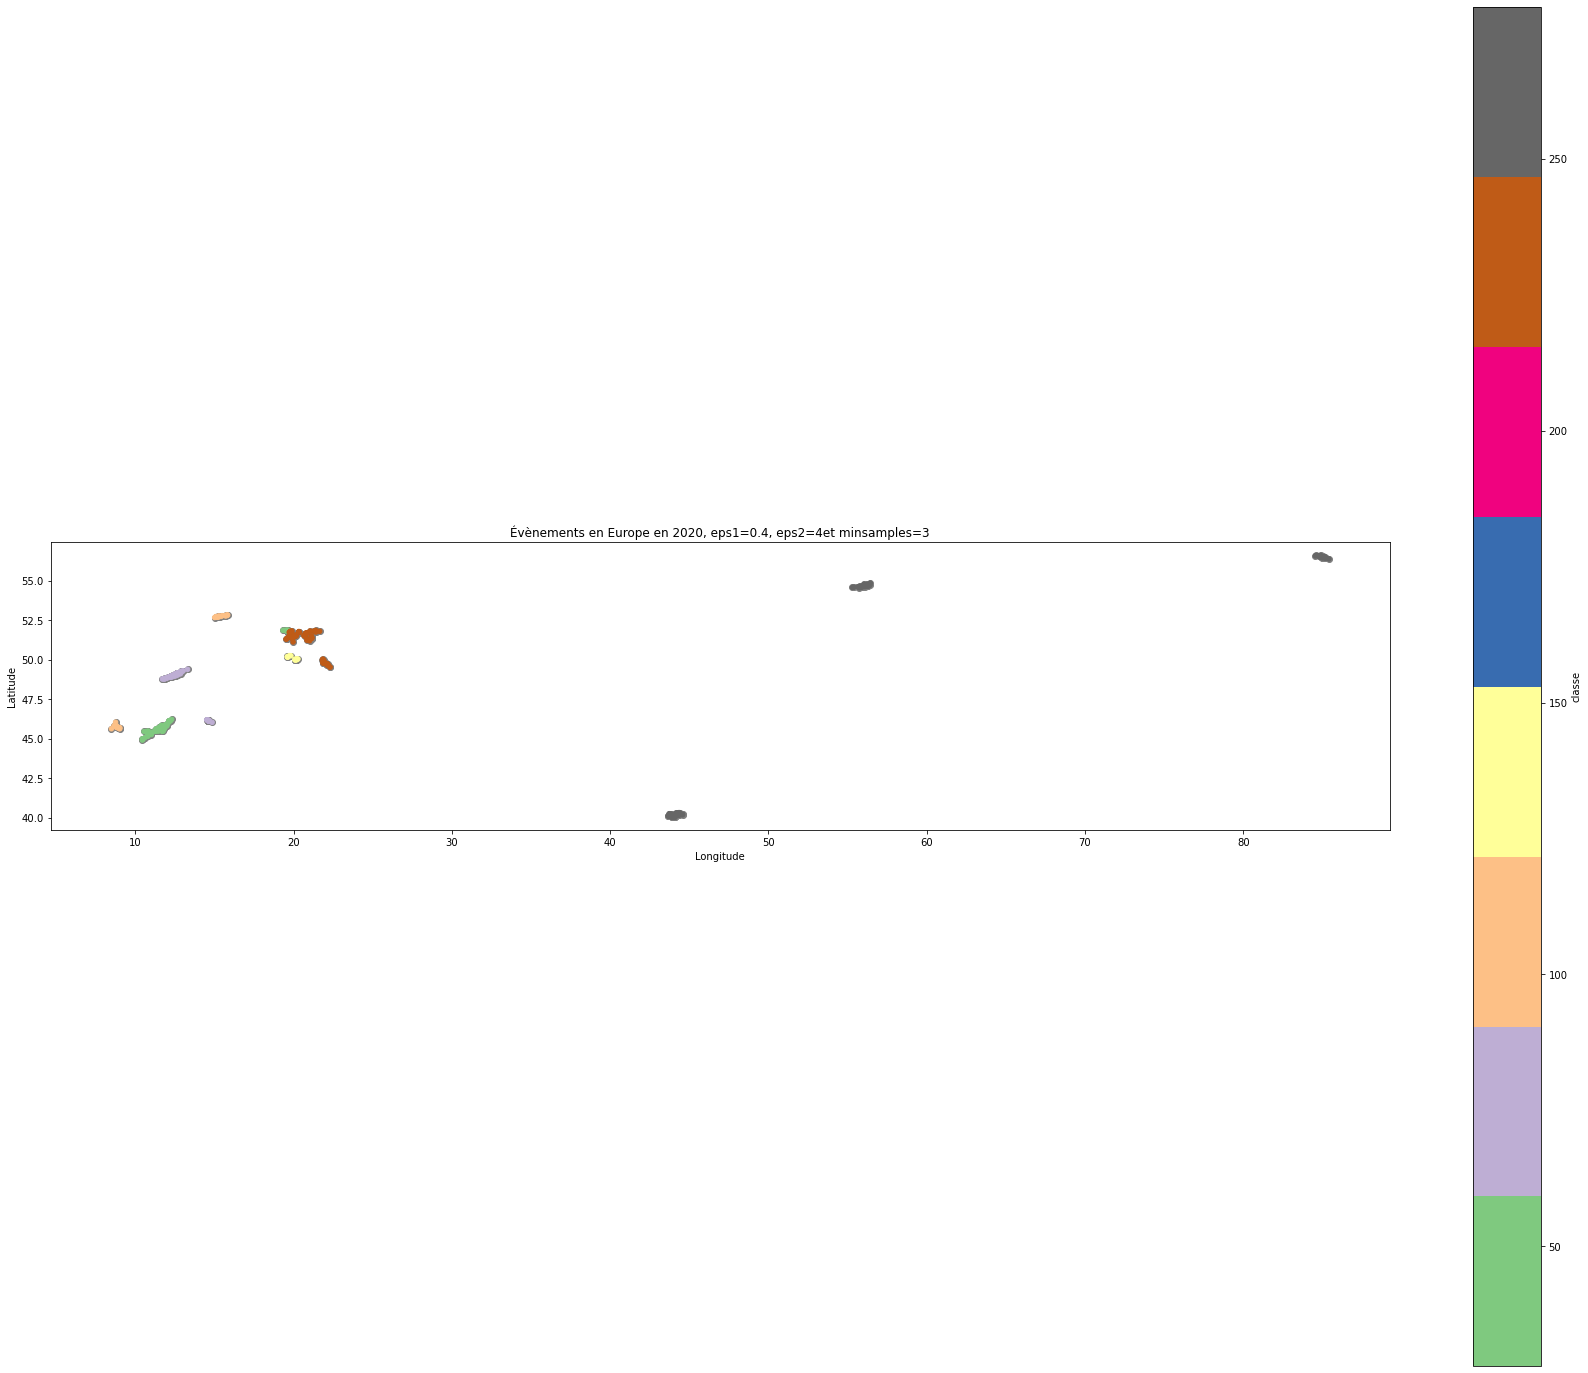

<ipython-input-8-e8ad8171f65d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1           1274      1274       1274     1274
 0              6         6          6        6
 1              3         3          3        3
 2              7         7          7        7
 3              6         6          6        6
 4              7         7          7        7
 5              3         3          3        3
 6              6         6          6        6
 7              3         3          3        3
 8              4         4          4        4
 9              3         3          3        3
 10             6         6          6        6
 11            11        11         11       11
 12             6         6          6        6
 13             7         7          7        7
 14             7         7          7        7
 15             3         3          3        3
 16             7         7          7        7
 17             7         7          7  

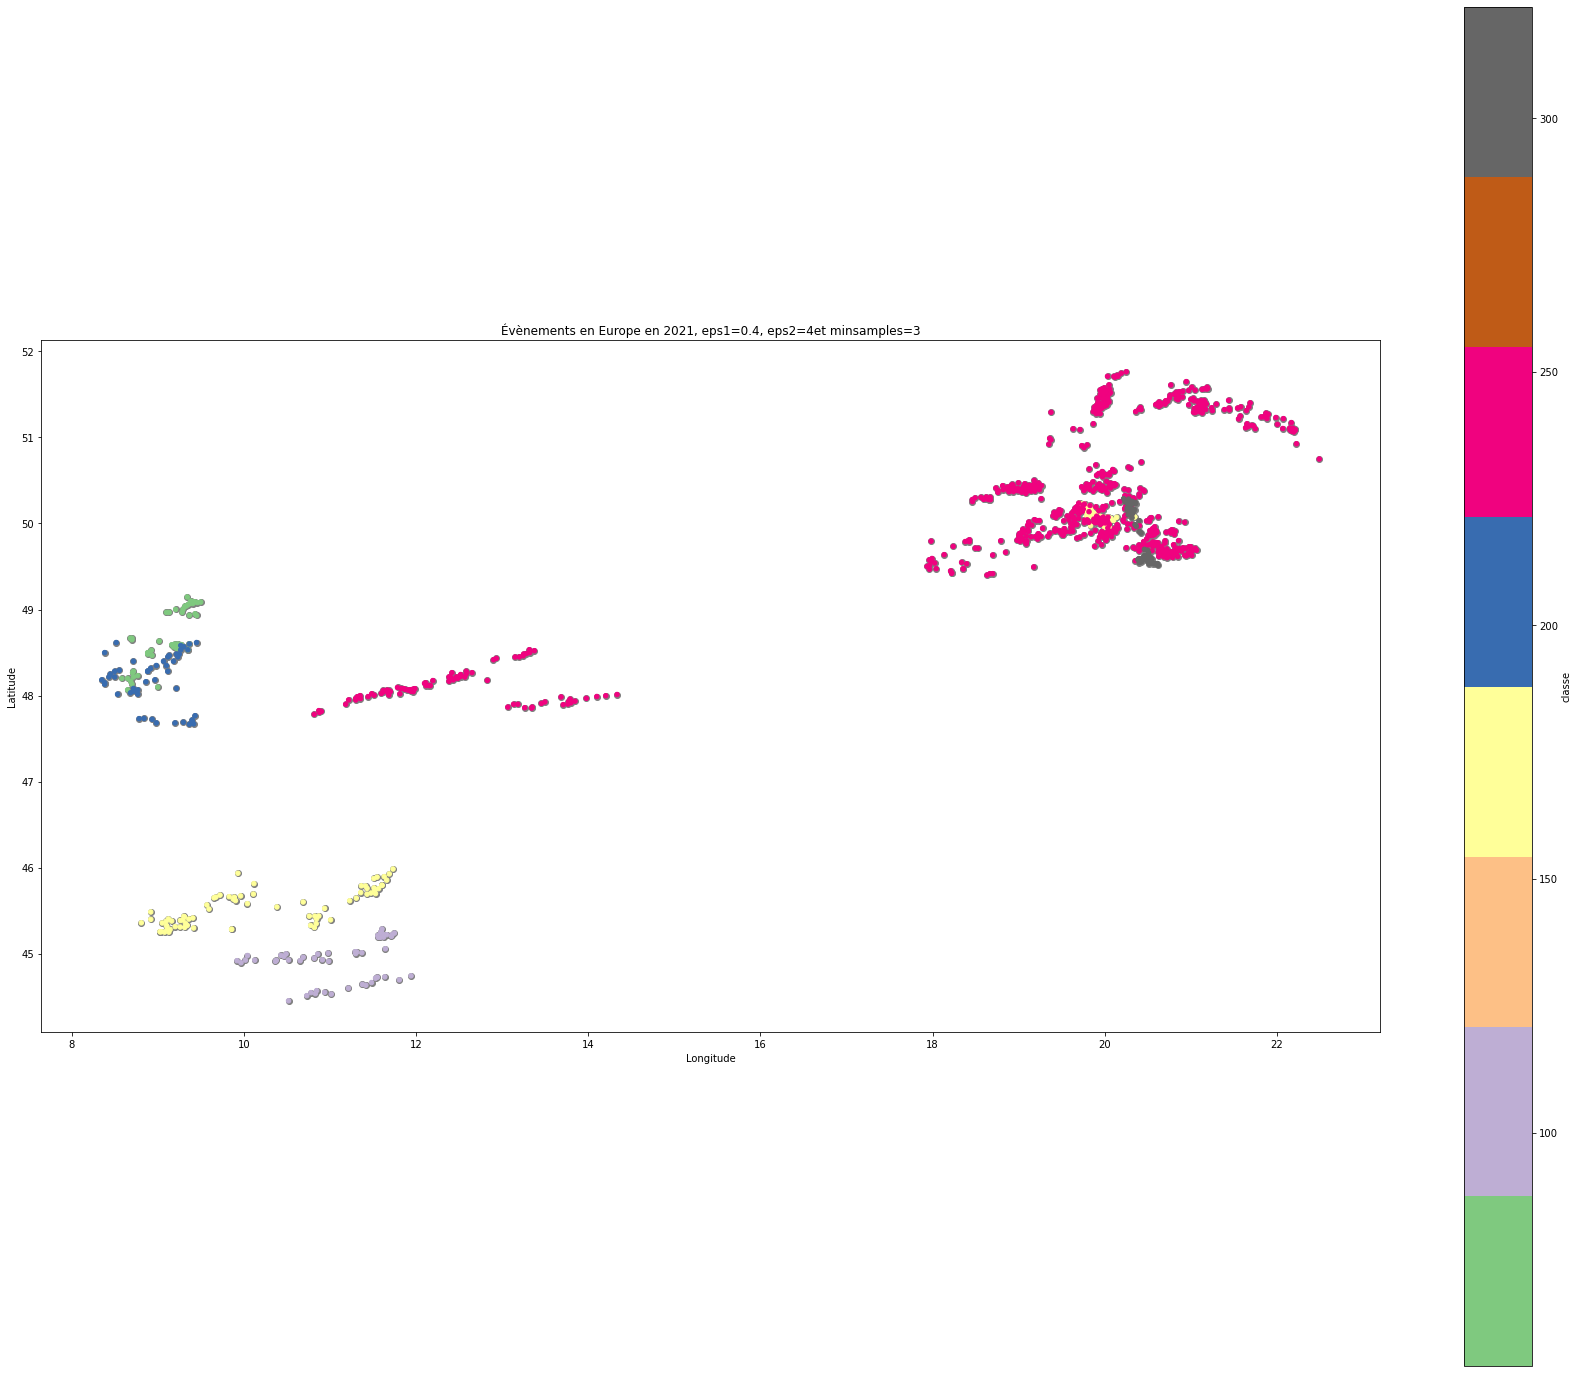

In [ ]:
for i in range(2007,2022):
    clusterise_per_year(i,0.4, 4,3)

In [ ]:
def cluster2(data,classi):
    orages = []
    n = len(data)
    p = len(np.unique(classi))
    for j in range(p):
        L = np.where(classi == j-1)[0]
        orages.append(L)
    return orages

In [ ]:
def constru(X,orages,j,l):
    m = len(orages)
    figure = plt.figure(figsize = (20, 10))
    if j == -1:
        j = m
    for o in range(1,j):
        longitude = [X.iloc[i,2] for i in orages[o]]
        latitude = [X.iloc[i,1] for i in orages[o]]
        plt.scatter(longitude,latitude)
    if j<len(l)-2 :
      plt.title('tracé des n='+str(j-1)+' premiers orages sans le cluster -1')
    else:
      plt.title('tracé de tous les orages sans le cluster -1')
    plt.xlabel('LONGITUDE')
    plt.ylabel('LATITUDE')
    plt.legend()
    plt.show()

In [ ]:
def visu(df5,country,year,var_eps1,var_eps2,var_min_samples):
  print('model = spatial: ',var_eps1,', time :',var_eps2,', min_samples :',var_min_samples )
  data = df5[df5.YEAR == year]
  data = data[data.COUNTRY == country]
  data_visu = data[['TIME_EVENT','LATITUDE','LONGITUDE']]
  model_visu = ST_DBSCAN(eps1=var_eps1, eps2=var_eps2,
                         min_samples=var_min_samples)
  model_visu.fit(data_visu)
  classi_visu = model_visu.labels
  visu_results = data_visu.copy()
  visu_results['CLASSI'] = classi_visu
  orages_visu = cluster2(data_visu,classi_visu)
  #stats about clustering distribution 
  # l_visu : list with number of observations per orage without the -1
  l_visu = np.unique(classi_visu, return_counts = True)[1]
  #number of clusters
  print('we cluster',len(l_visu)-1,'orages in',country,'during the year',year)
  percentage = round((l_visu[0]/len(data_visu))*100,1)
  print("we can't cluster", l_visu[0],'obsverations over',len(data_visu),'(',percentage,'%)')
  #mean observations per orage
  print('In',country,'during the year',year,'the mean number of observations per orage is', round(np.mean(l_visu[1:]),3))
  print('In',country,'during the year',year,'the median number of observations per orage is', np.median(l_visu[1:]))
  # max obsverations for an orage
  orage_max = l_visu.tolist().index(np.max(l_visu[1:]))
  print('the biggest orage has been reported',np.max(l_visu[1:]),'times')
  data_max = visu_results[visu_results.CLASSI == (orage_max -1)]
  #we check the size of this orage
  large = round(data_max.describe().iloc[-1,1] - data_max.describe().iloc[3,1],3)
  high = round(data_max.describe().iloc[-1,0] - data_max.describe().iloc[3,0],3)
  time = data_max.iloc[0,0] - data_max.iloc[-1,0]
  hours = int(time)
  minutes = int((time - hours)*60)
  print('the biggest orage has moved :',large,'longitude degrees and',high,'latitude degrees')
  print('the biggest orage has last ',hours,'hours and',minutes,'minutes')
  #we plot this orage_max
  plt.figure(1)
  longitude = [data_max.iloc[i,2] for i in range(len(data_max))]
  latitude = [data_max.iloc[i,1] for i in range(len(data_max))]
  plt.scatter(longitude,latitude)
  plt.title('track of the biggest orage')
  plt.show()
  #plot the distribution of the number of obsverations per cluster
  sns.distplot(l_visu,bins = 100).set_title("distribution of the number of observations per cluster")
  #we plot all of the orages
  constru(data_visu,orages_visu,len(l_visu)-2,l_visu)
  return visu_results
